# Running Individual Tests

This notebook shows how to run individual metrics or thresholds tests, and how to pass custom parameters to them.

In [1]:
%load_ext dotenv
%dotenv dev.env

import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  project = "clh0yyhg700825x8h4ocp5i3u"
)

True

## Train a Model for Testing

We train a simple customer churn model for our test.

In [3]:
df = pd.read_csv("./datasets/bank_customer_churn.csv")

In [4]:
df.drop(["RowNumber", "CustomerId", "Surname", "CreditScore"], axis=1, inplace=True)

genders = {"Male": 0, "Female": 1}
df.replace({"Gender": genders}, inplace=True)

df = pd.concat([df, pd.get_dummies(df["Geography"], prefix="Geography")], axis=1)
df.drop("Geography", axis=1, inplace=True)

train_df, test_df = train_test_split(df, test_size=0.20)

# This guarantees a 60/20/20 split
train_ds, val_ds = train_test_split(train_df, test_size=0.25)

# For training
x_train = train_ds.drop("Exited", axis=1)
y_train = train_ds.loc[:, "Exited"].astype(int)
x_val = val_ds.drop("Exited", axis=1)
y_val = val_ds.loc[:, "Exited"].astype(int)

# For testing
x_test = test_df.drop("Exited", axis=1)
y_test = test_df.loc[:, "Exited"].astype(int)

In [5]:
model = xgb.XGBClassifier(early_stopping_rounds=10)
model.set_params(
    eval_metric=["error", "logloss", "auc"],
)
model.fit(
    x_train,
    y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    verbose=False,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['error', 'logloss', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [6]:
vm_model = vm.init_model(model)
vm_train_ds = vm.init_dataset(dataset=train_ds, type="generic", target_column="Exited")
vm_test_ds = vm.init_dataset(dataset=test_df, type="generic", target_column="Exited")

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...
Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


## Import and Run the Individual Test

We can now import the individual test and pass the required context and config parameters to it.

In [7]:
from validmind.vm_models.test_context import TestContext
from validmind.model_validation.sklearn.threshold_tests import WeakspotsDiagnosisTest

In [12]:
test_context = TestContext(model=vm_model, train_ds=vm_train_ds, test_ds=vm_test_ds)
ws_diagnostic = WeakspotsDiagnosisTest(test_context)

In [13]:
ws_diagnostic.run()

Mean of empty slice.
invalid value encountered in double_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Mean of empty slice.
invalid value encountered in double_scalars
Precision is ill-defi

TestPlanTestResult(result_id="weak_spots", test_results)


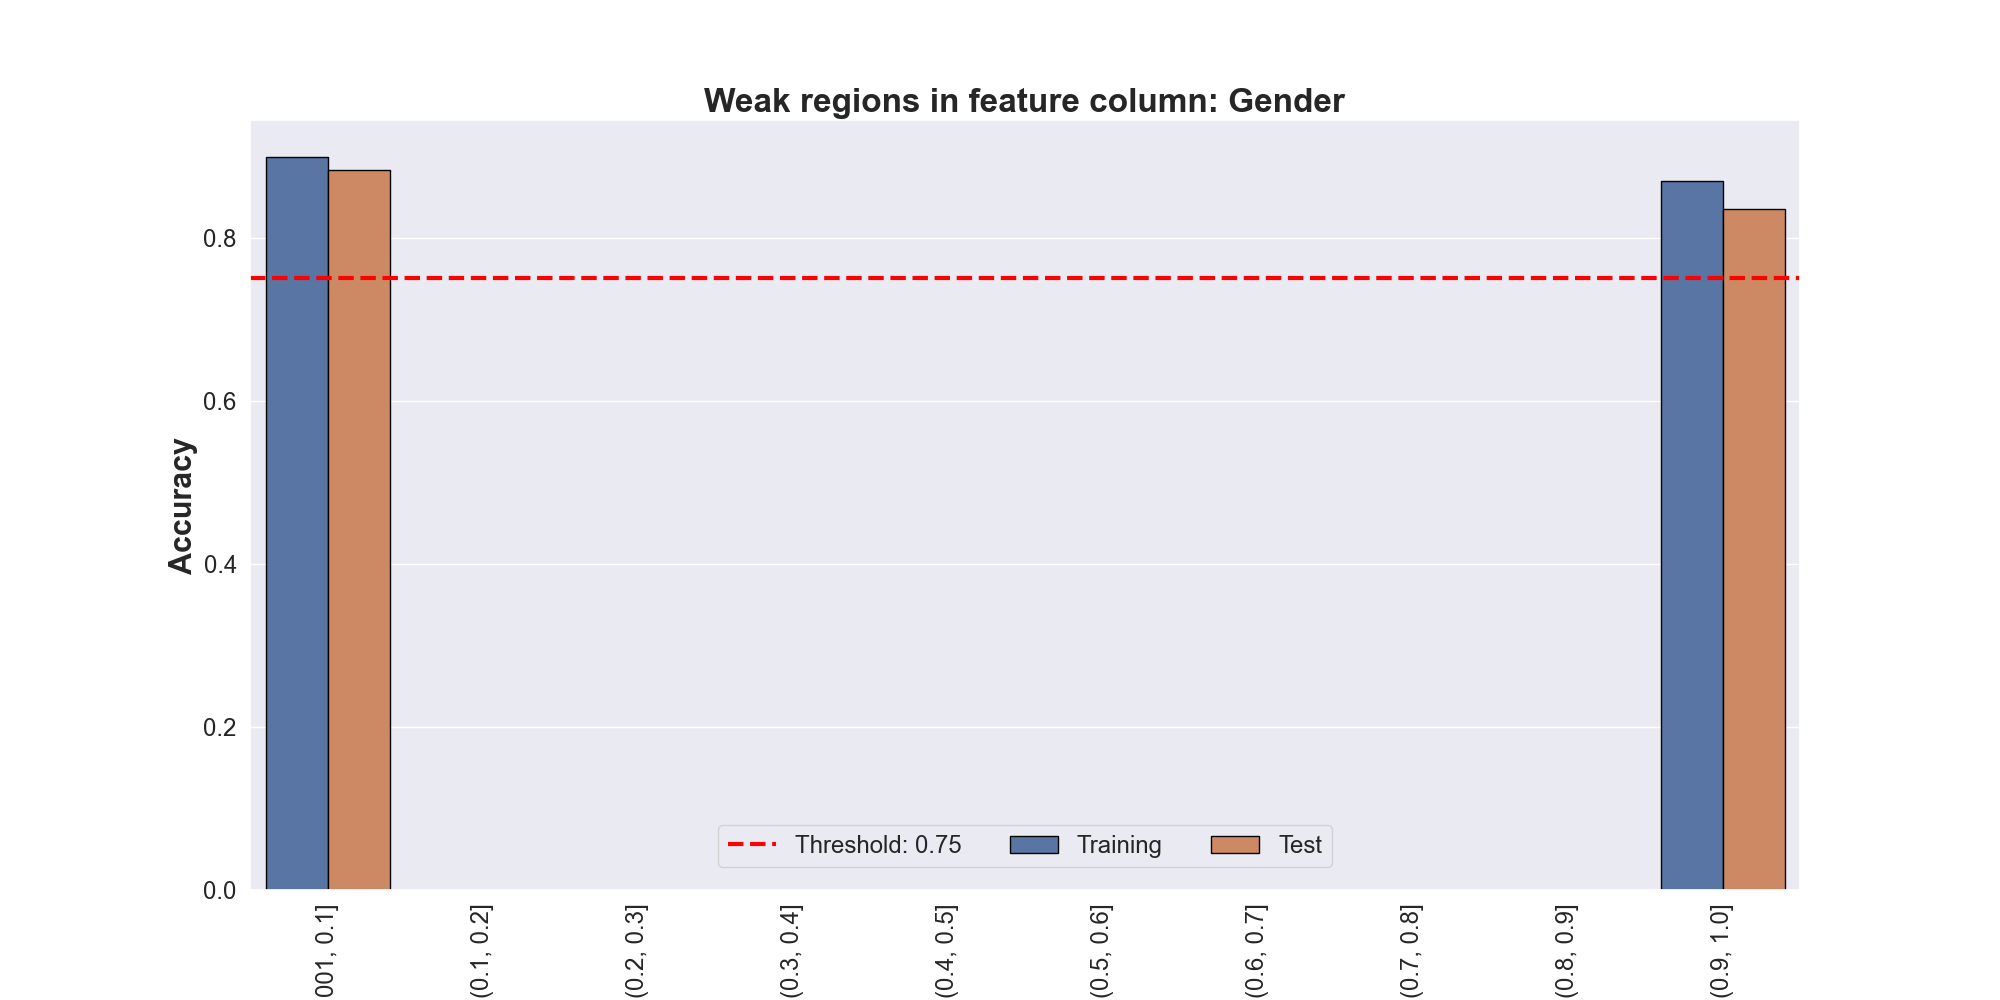
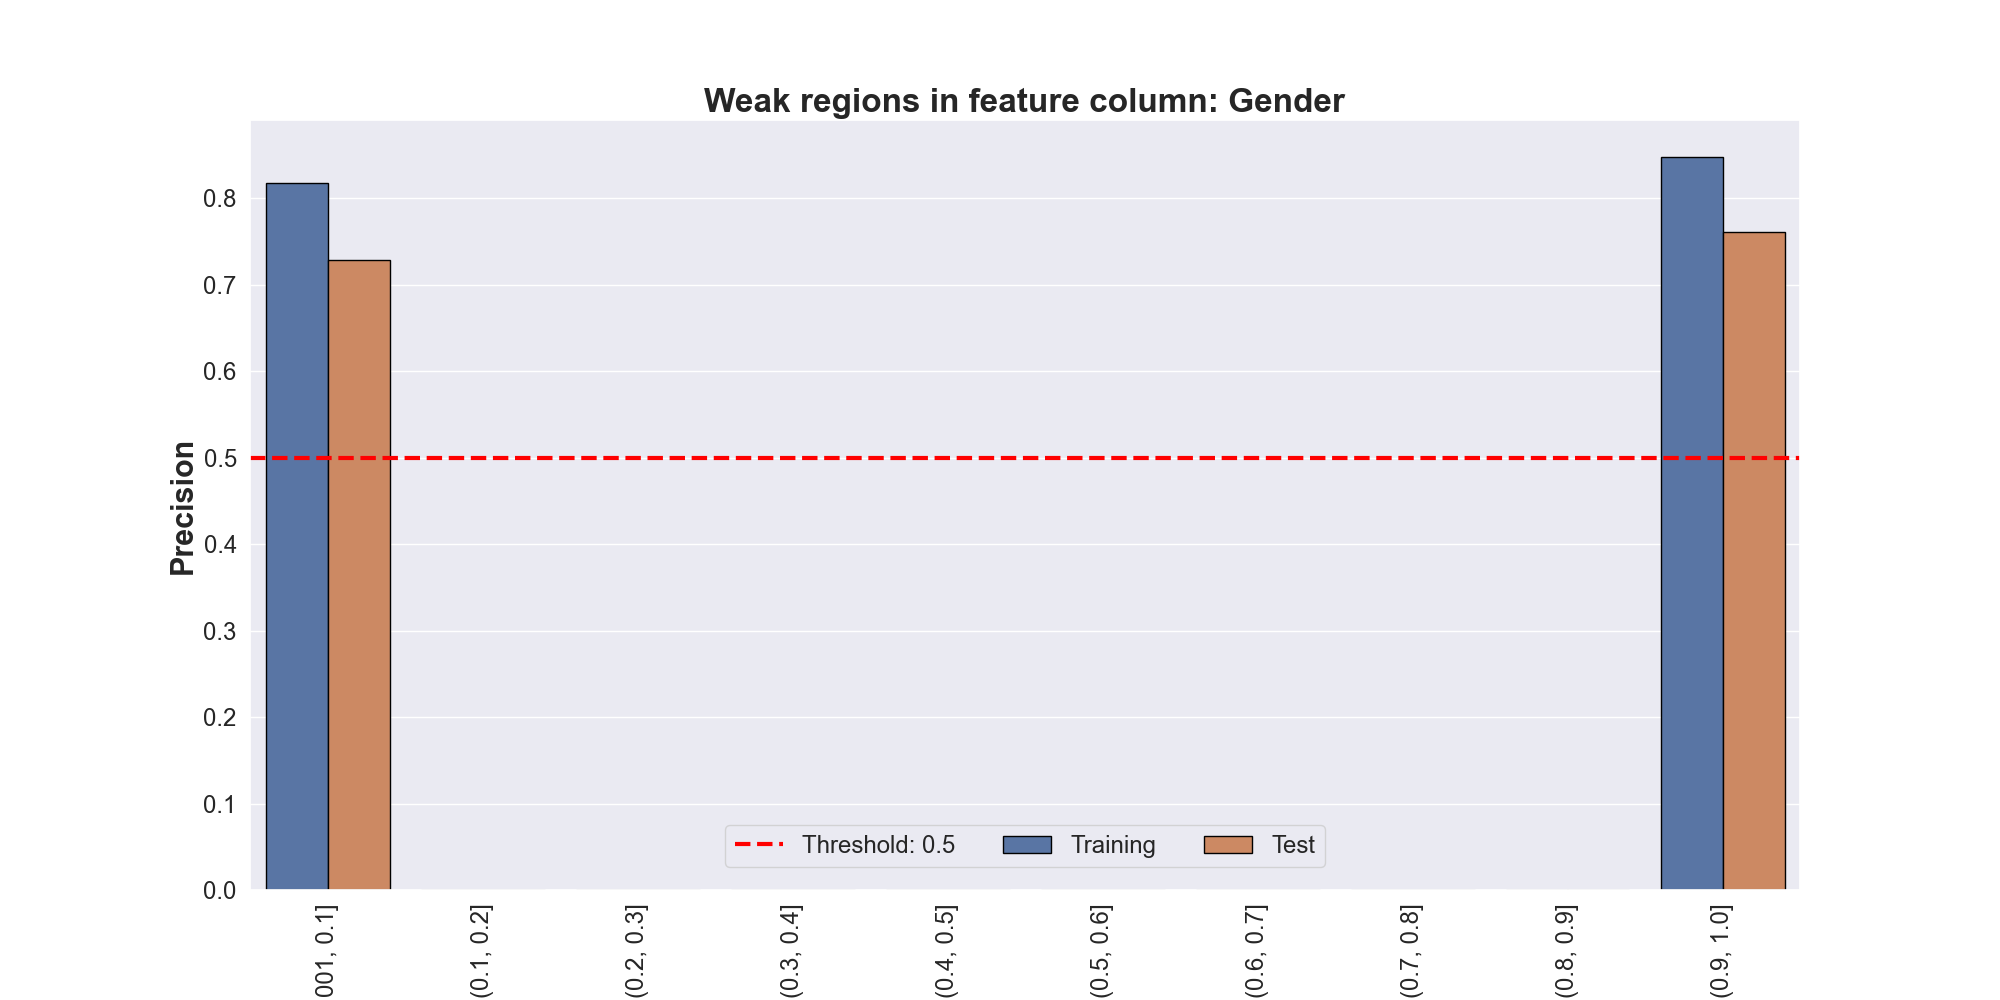
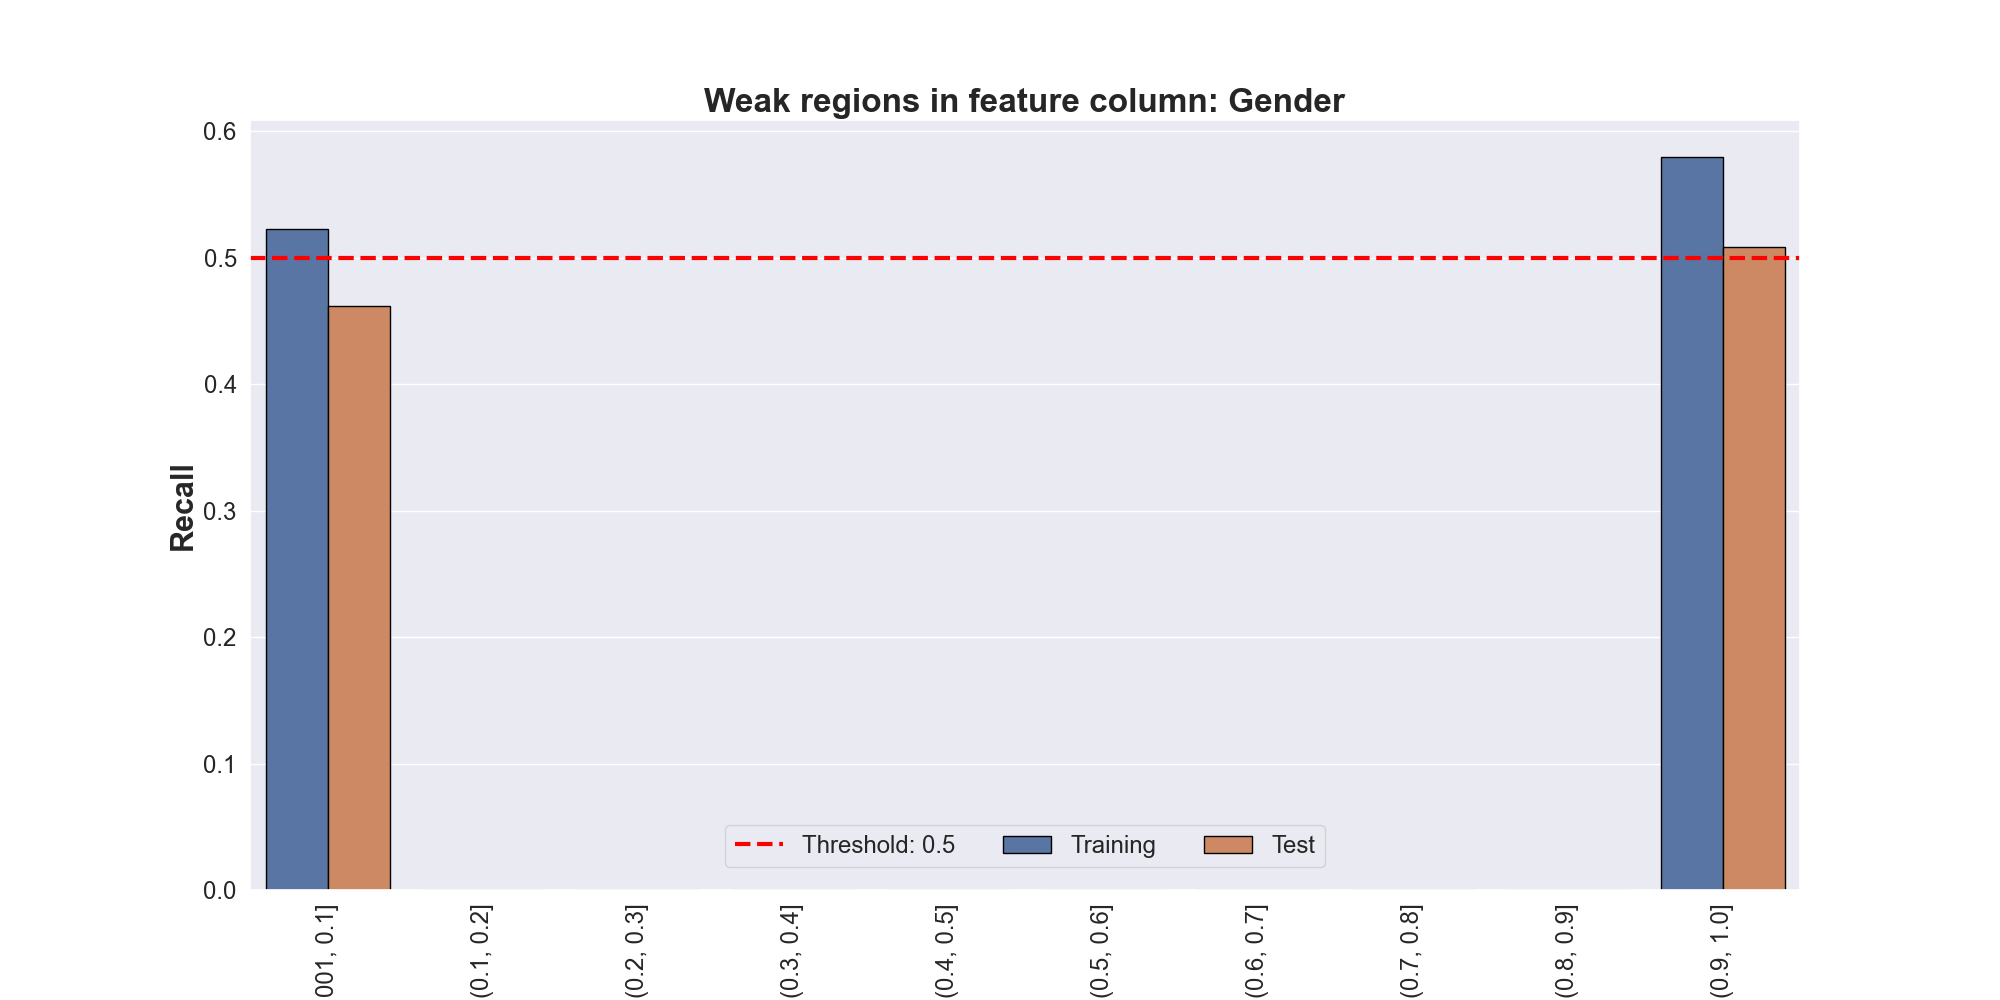
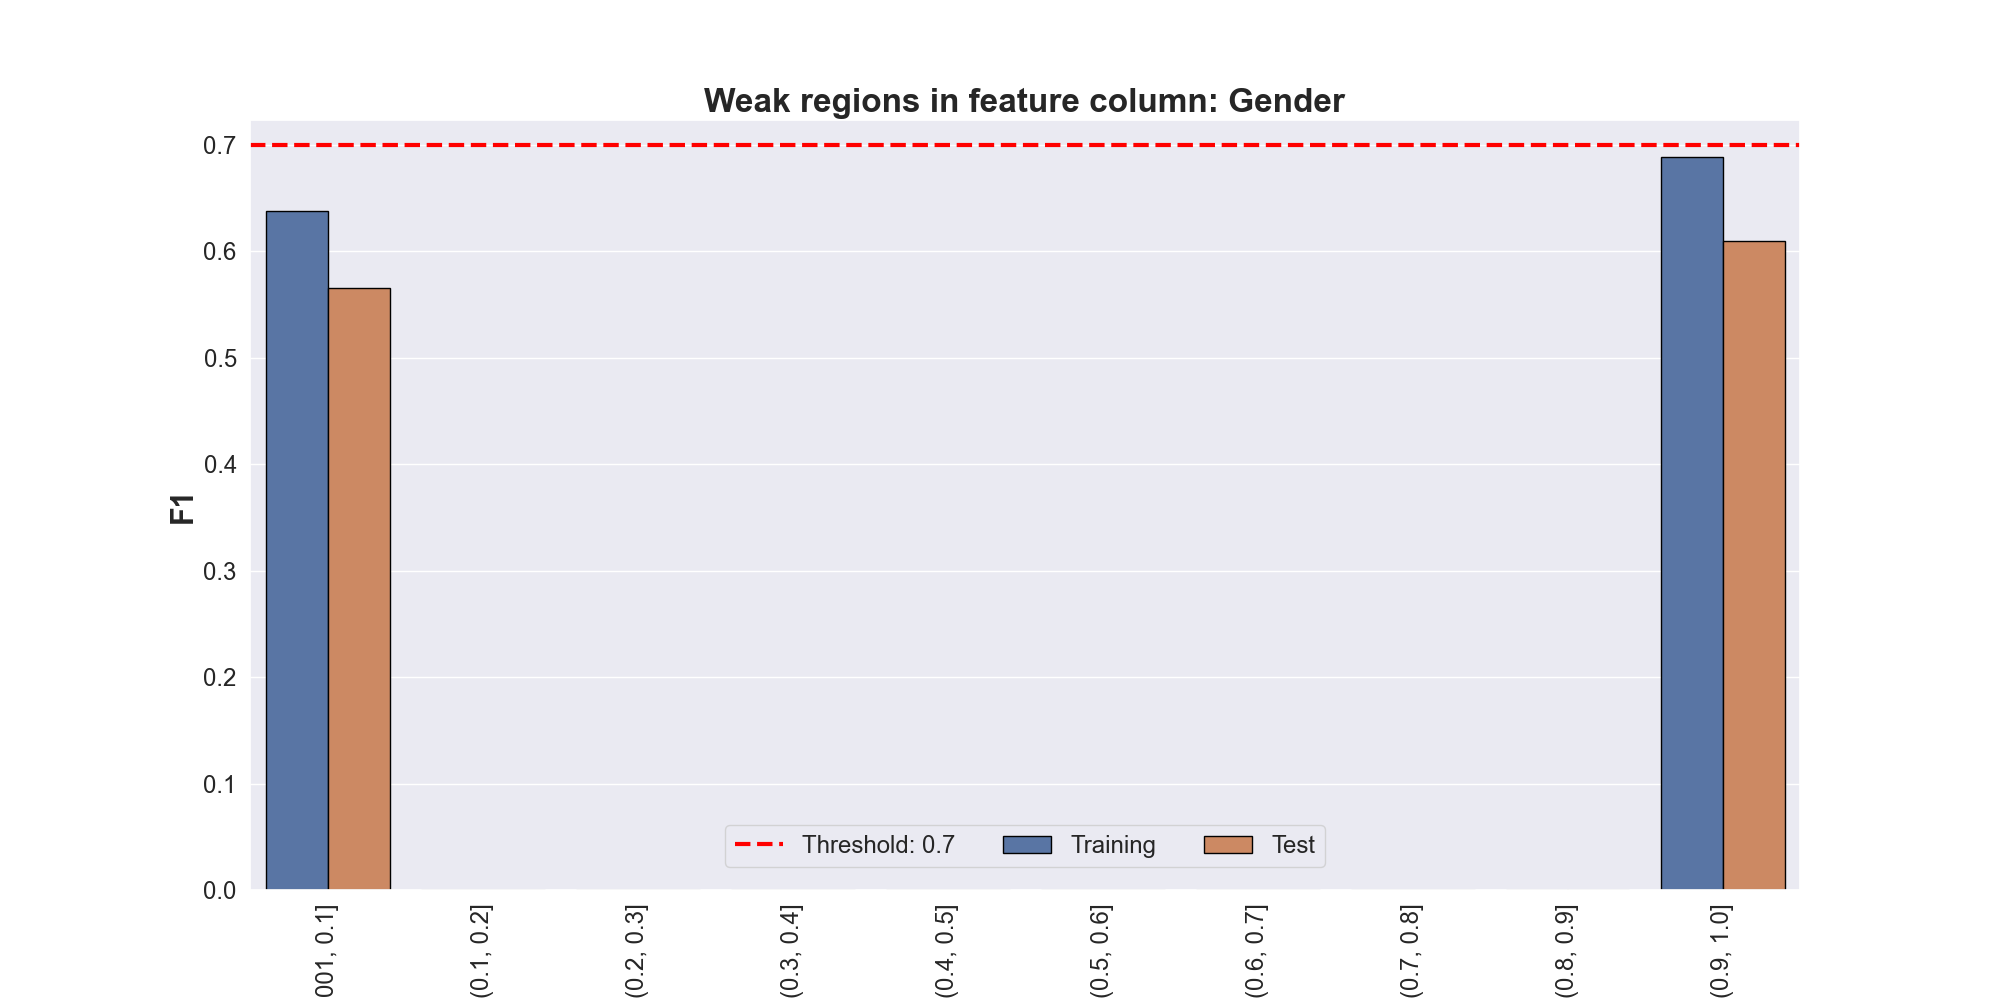
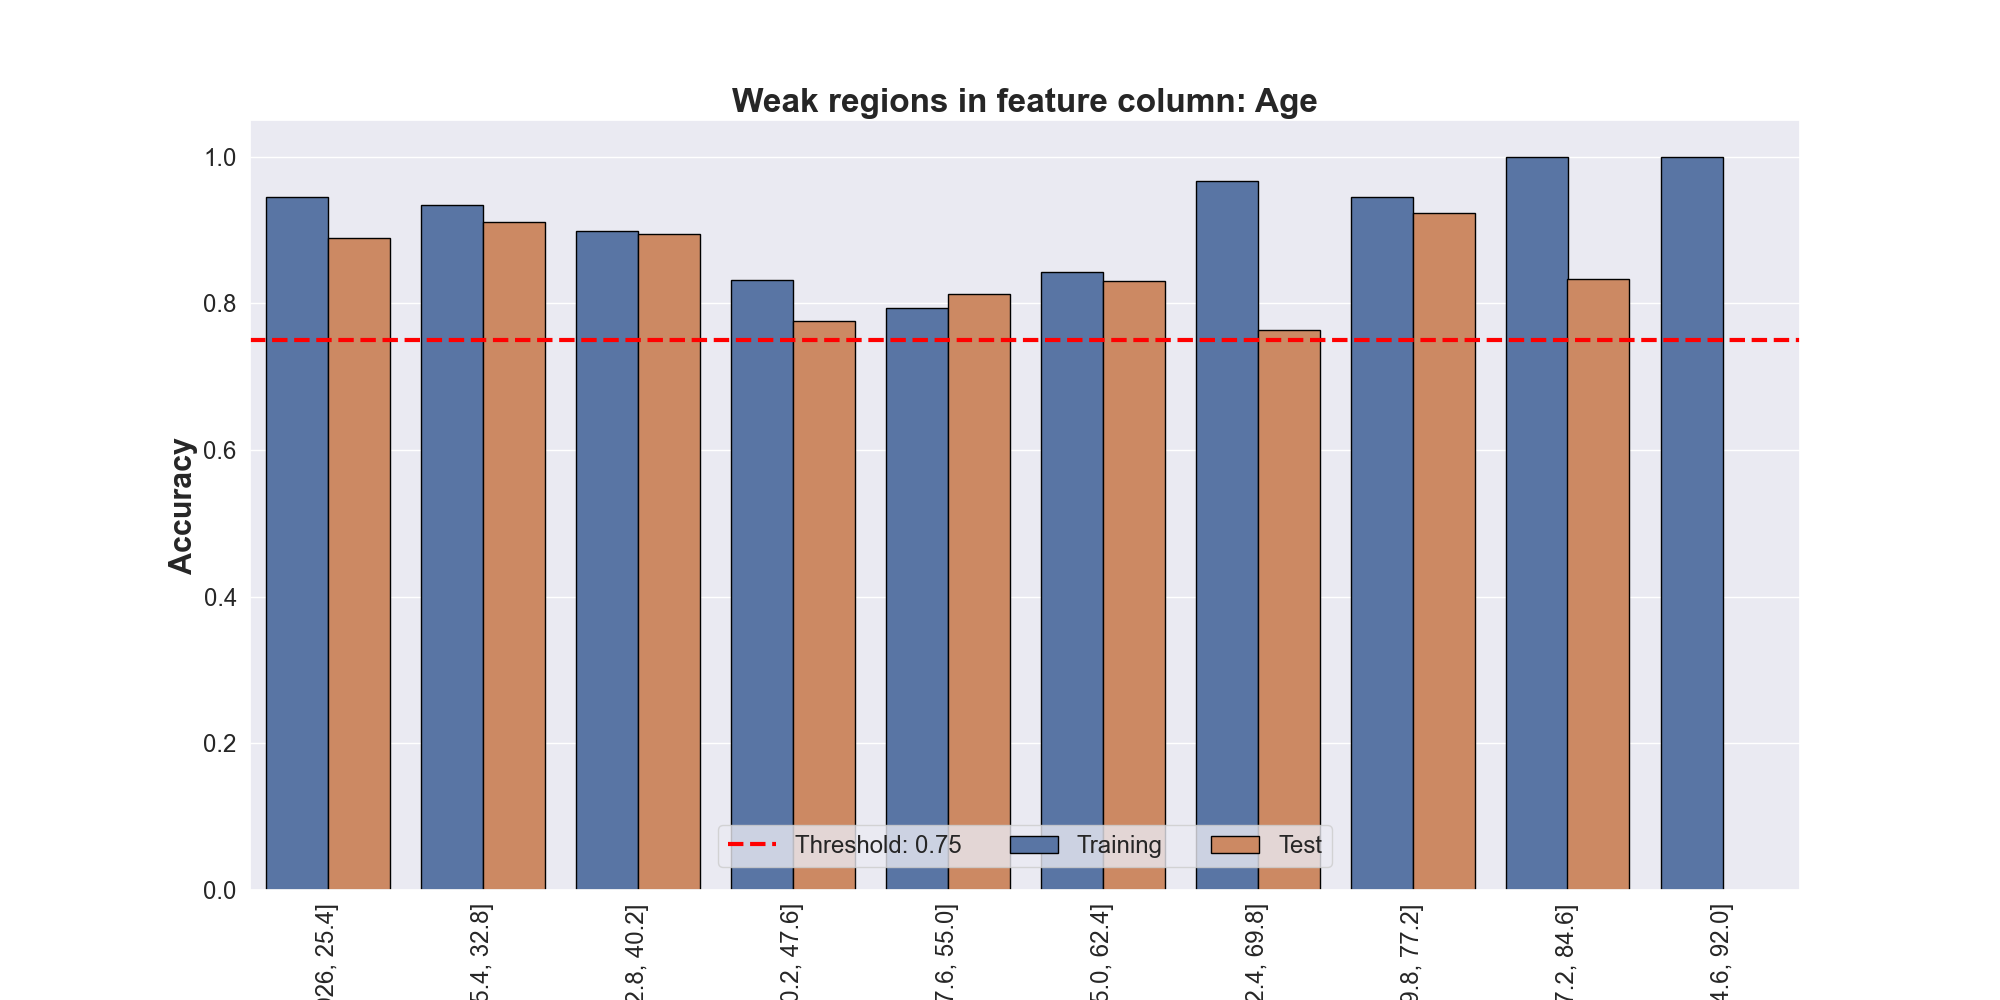
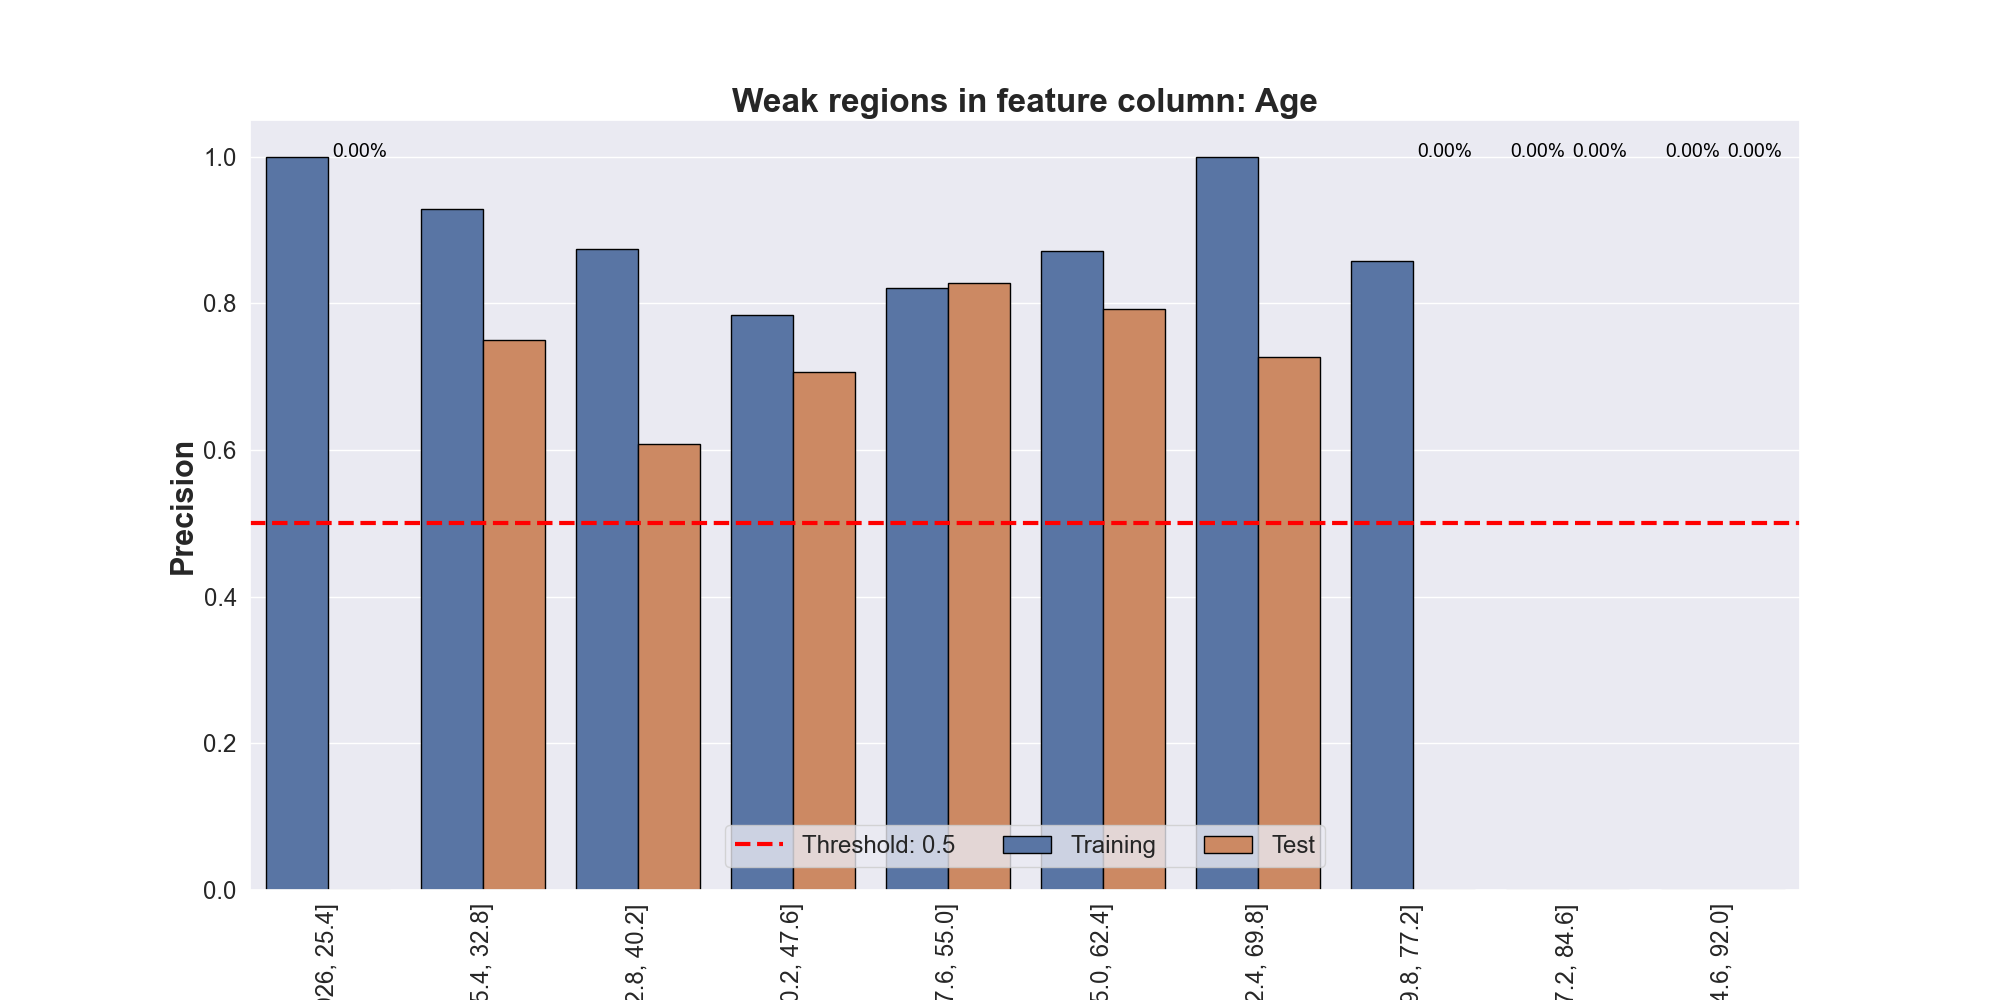
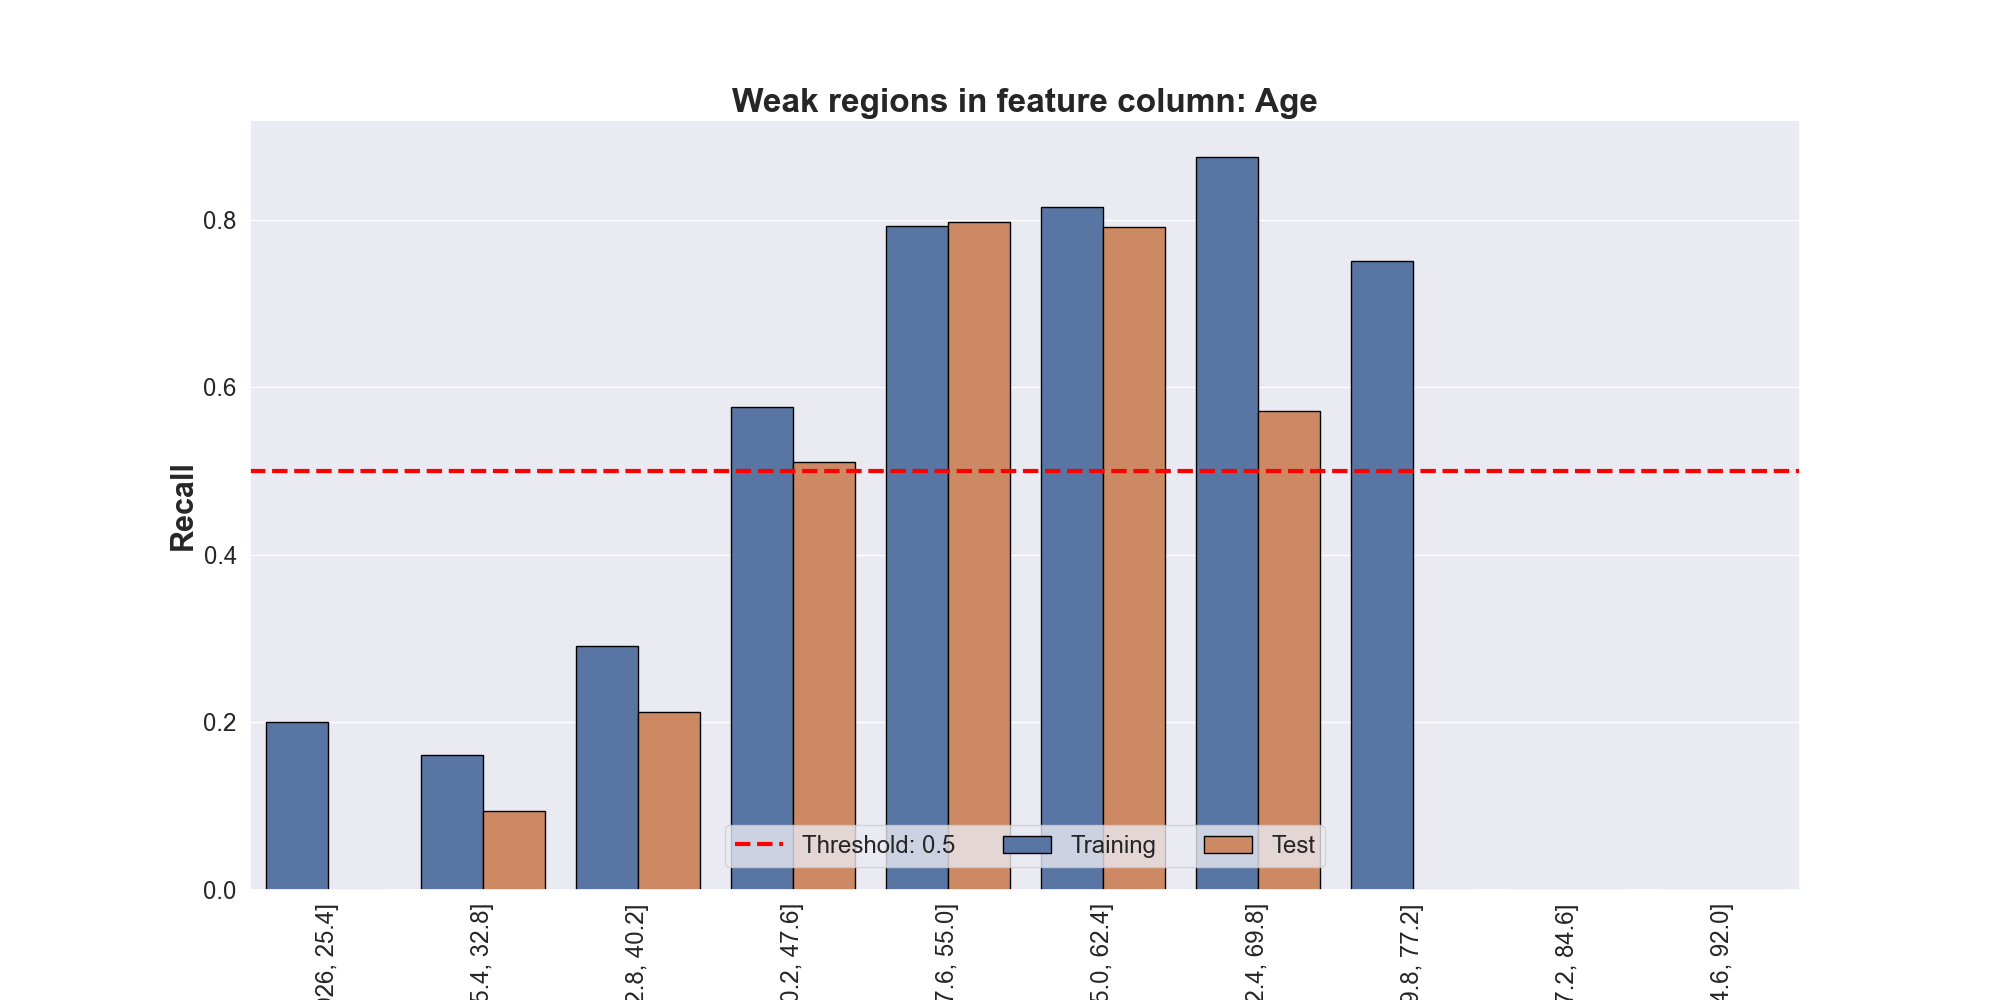
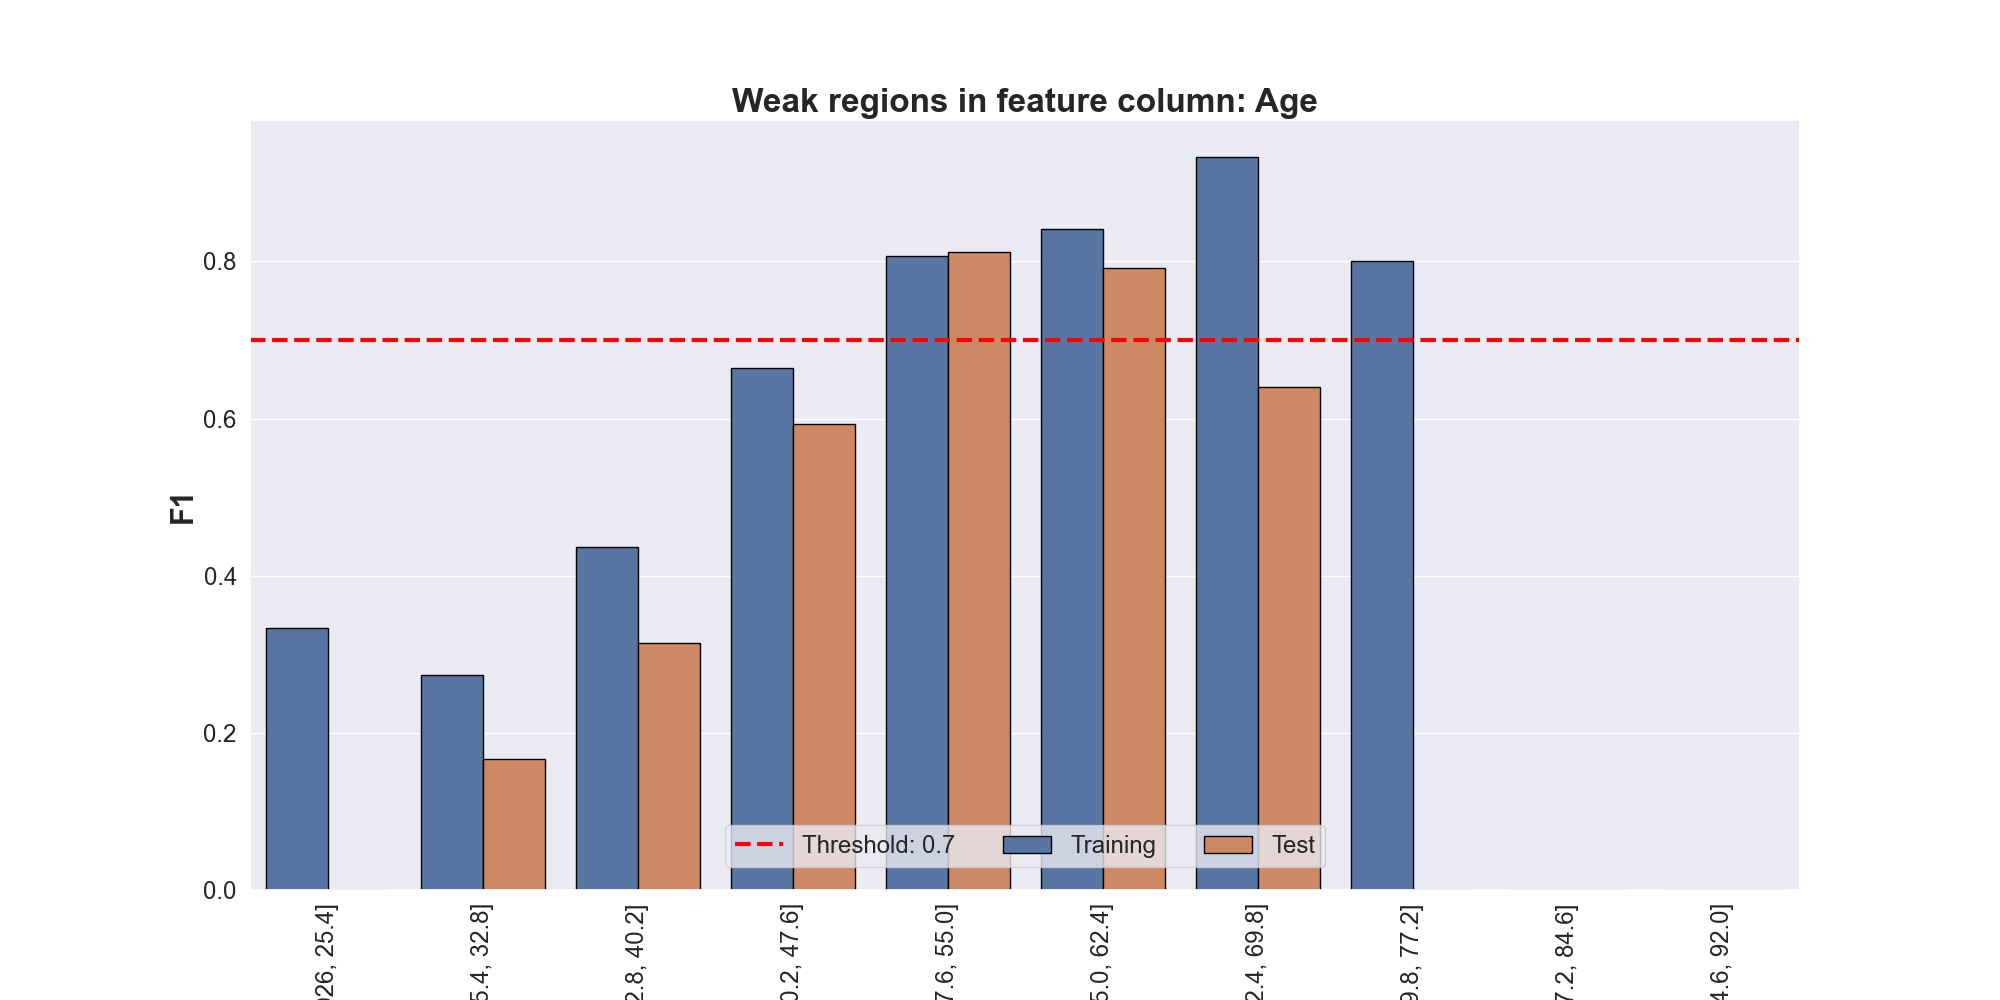
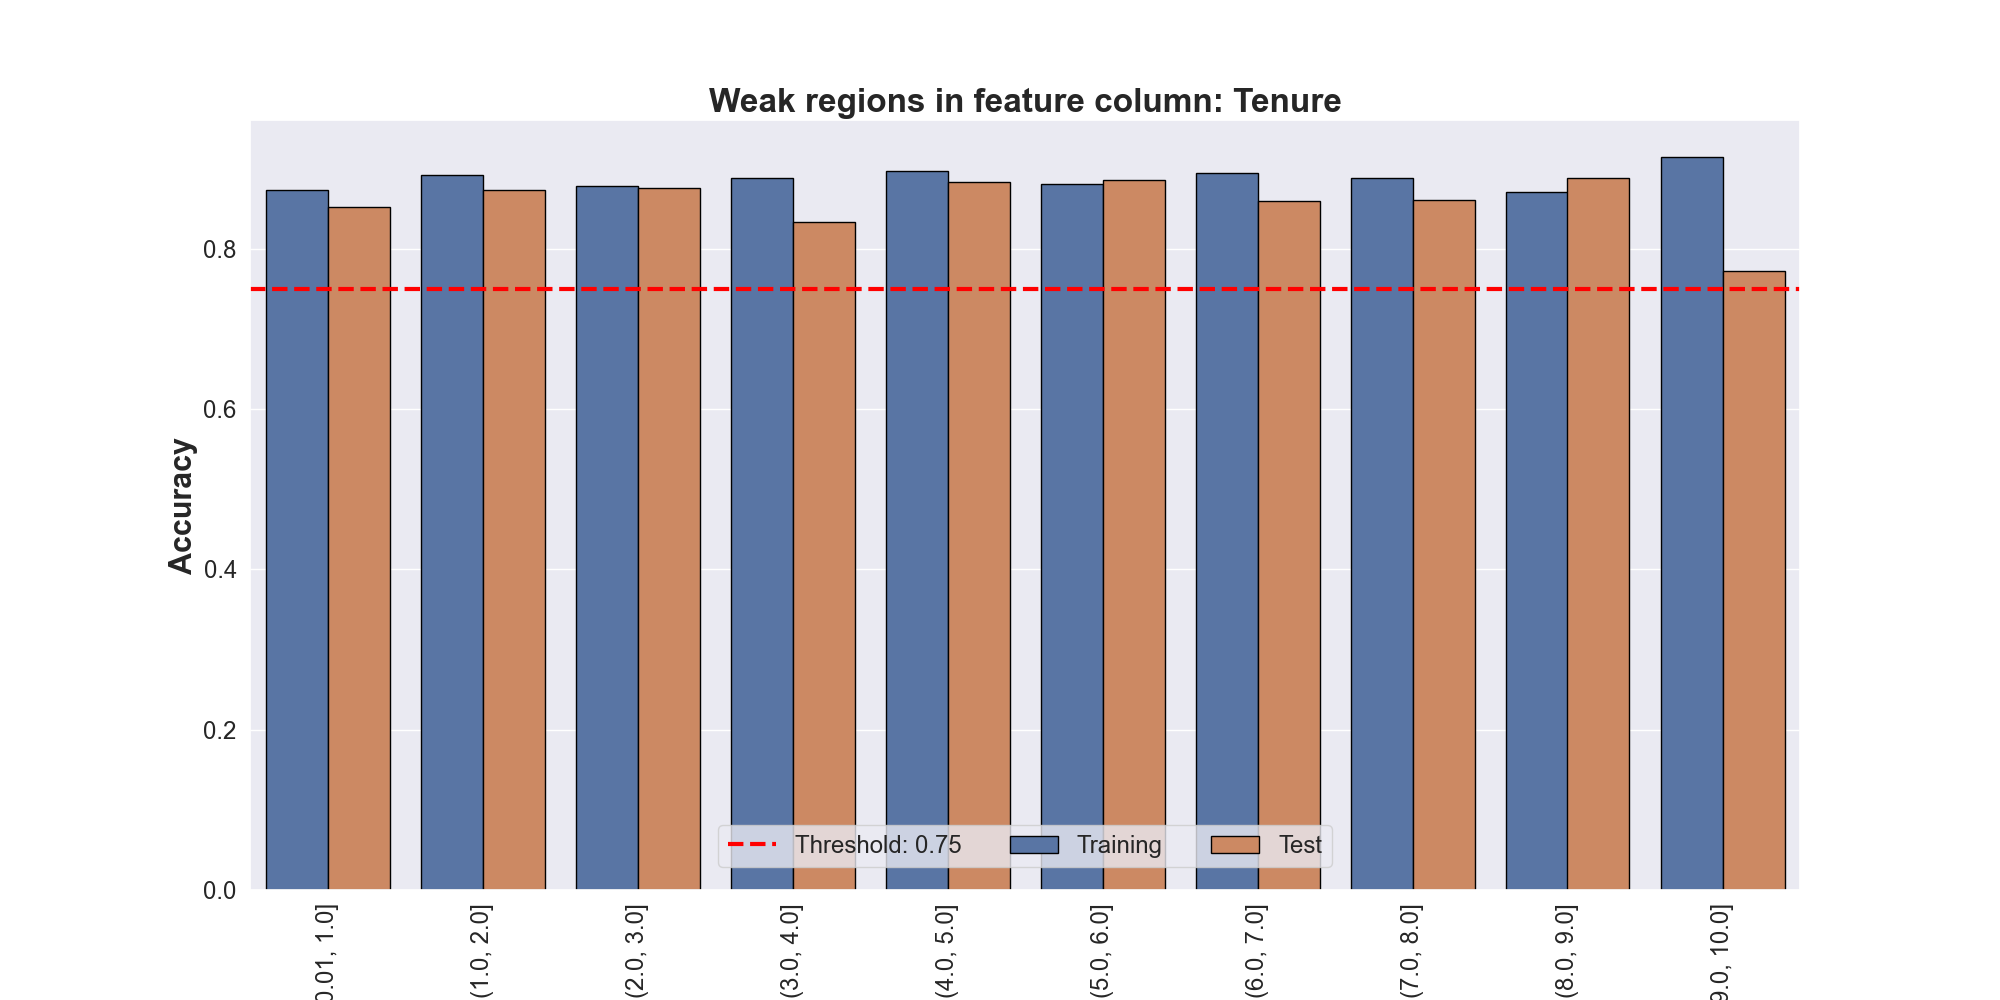
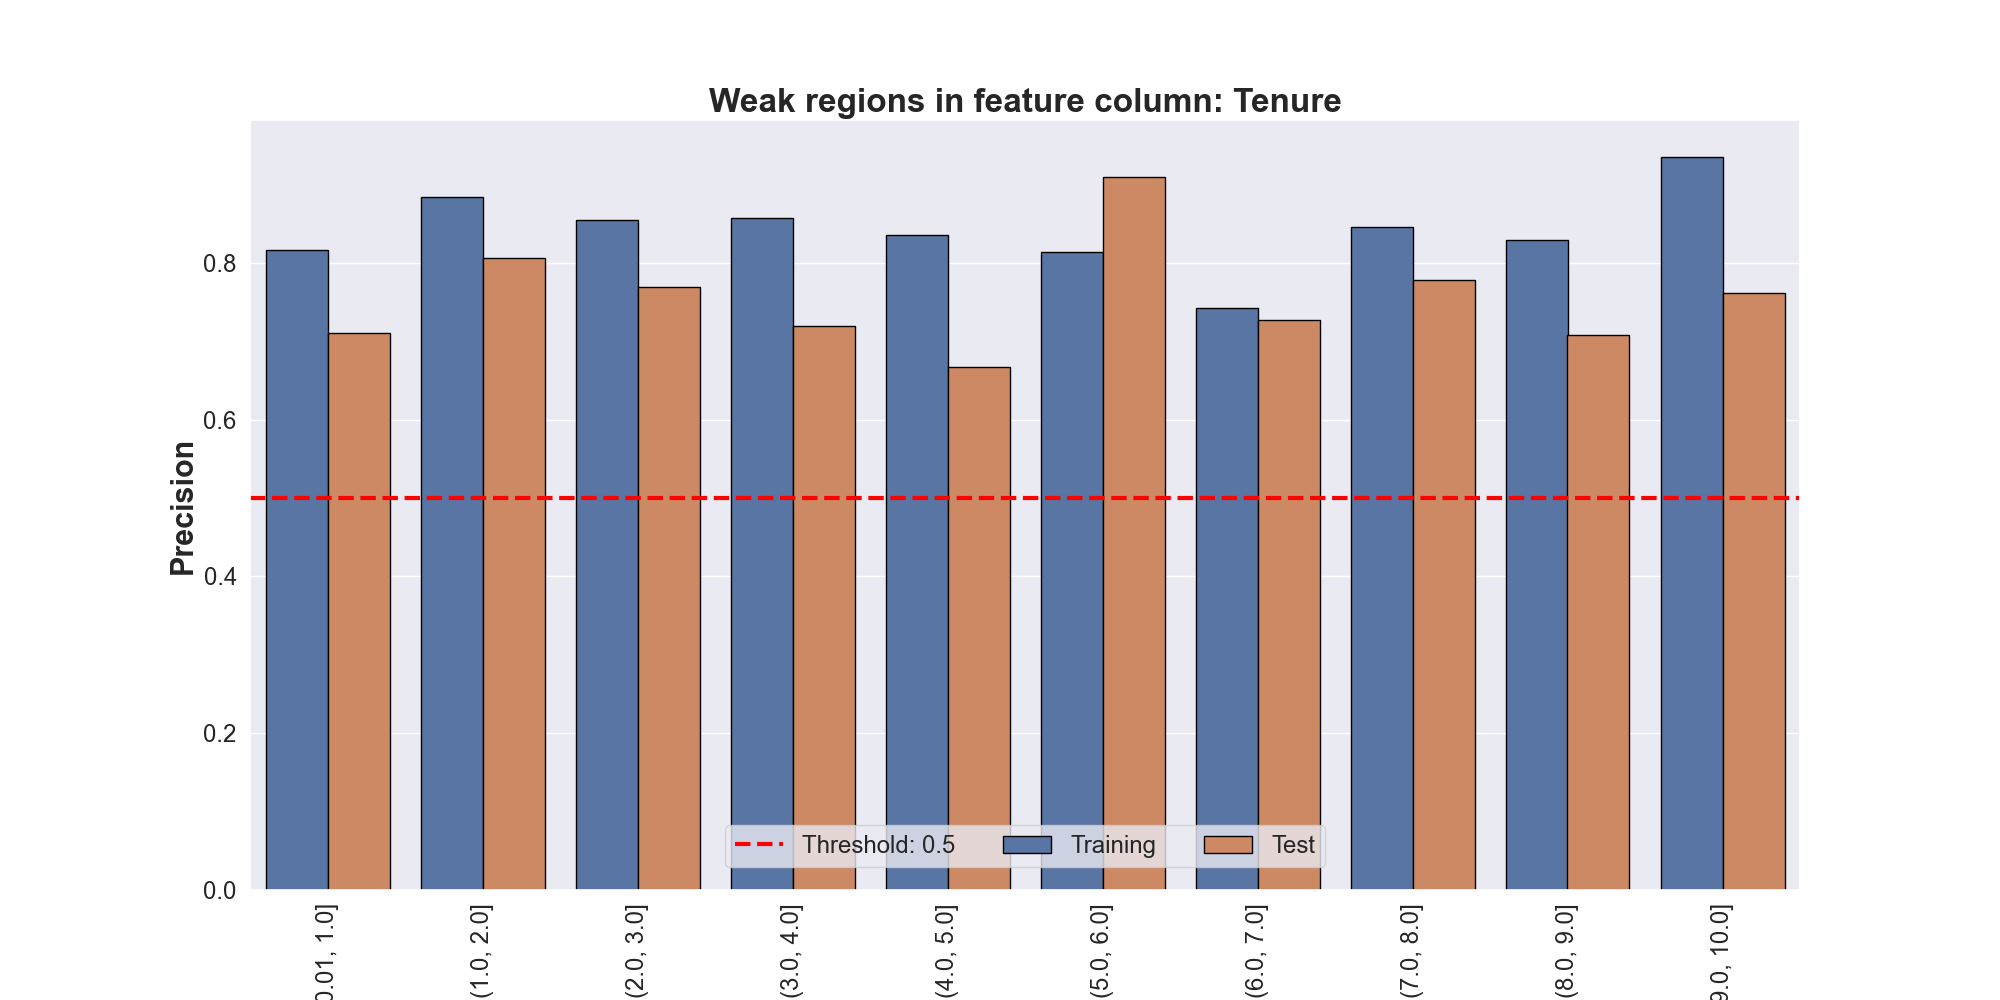
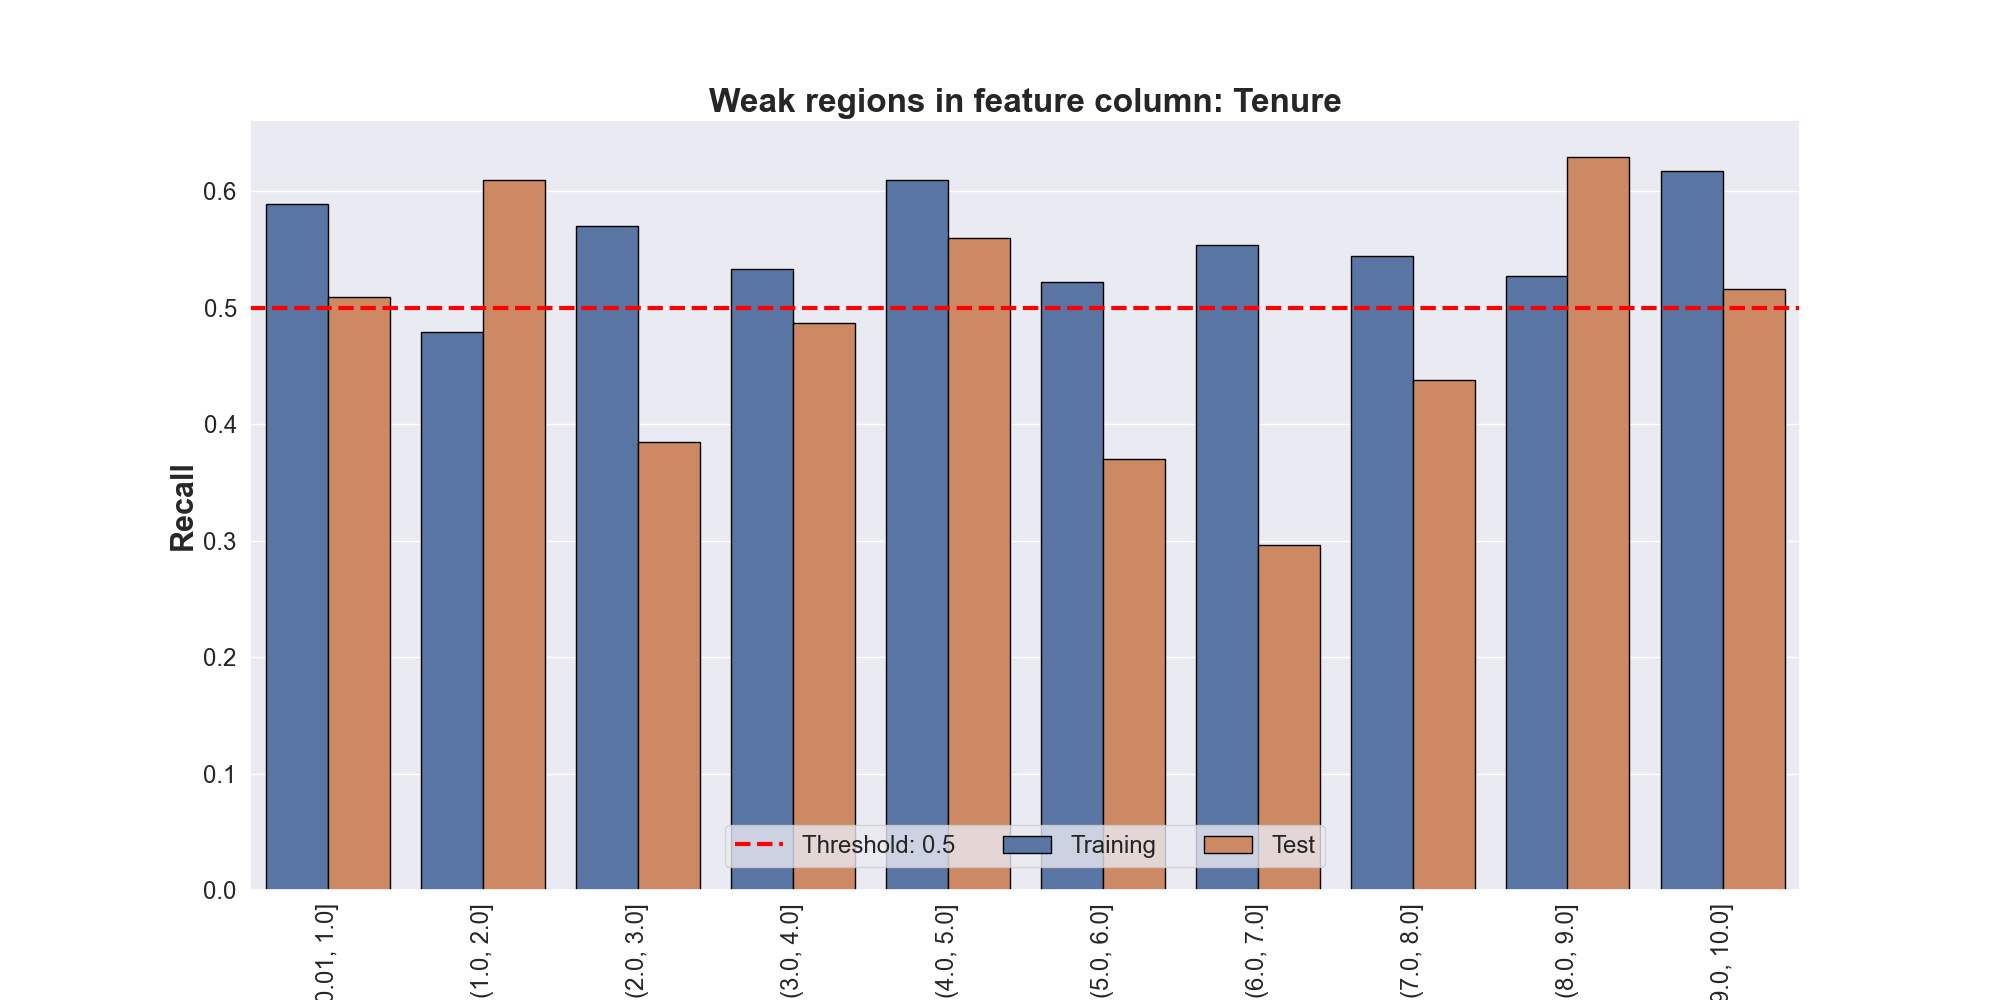
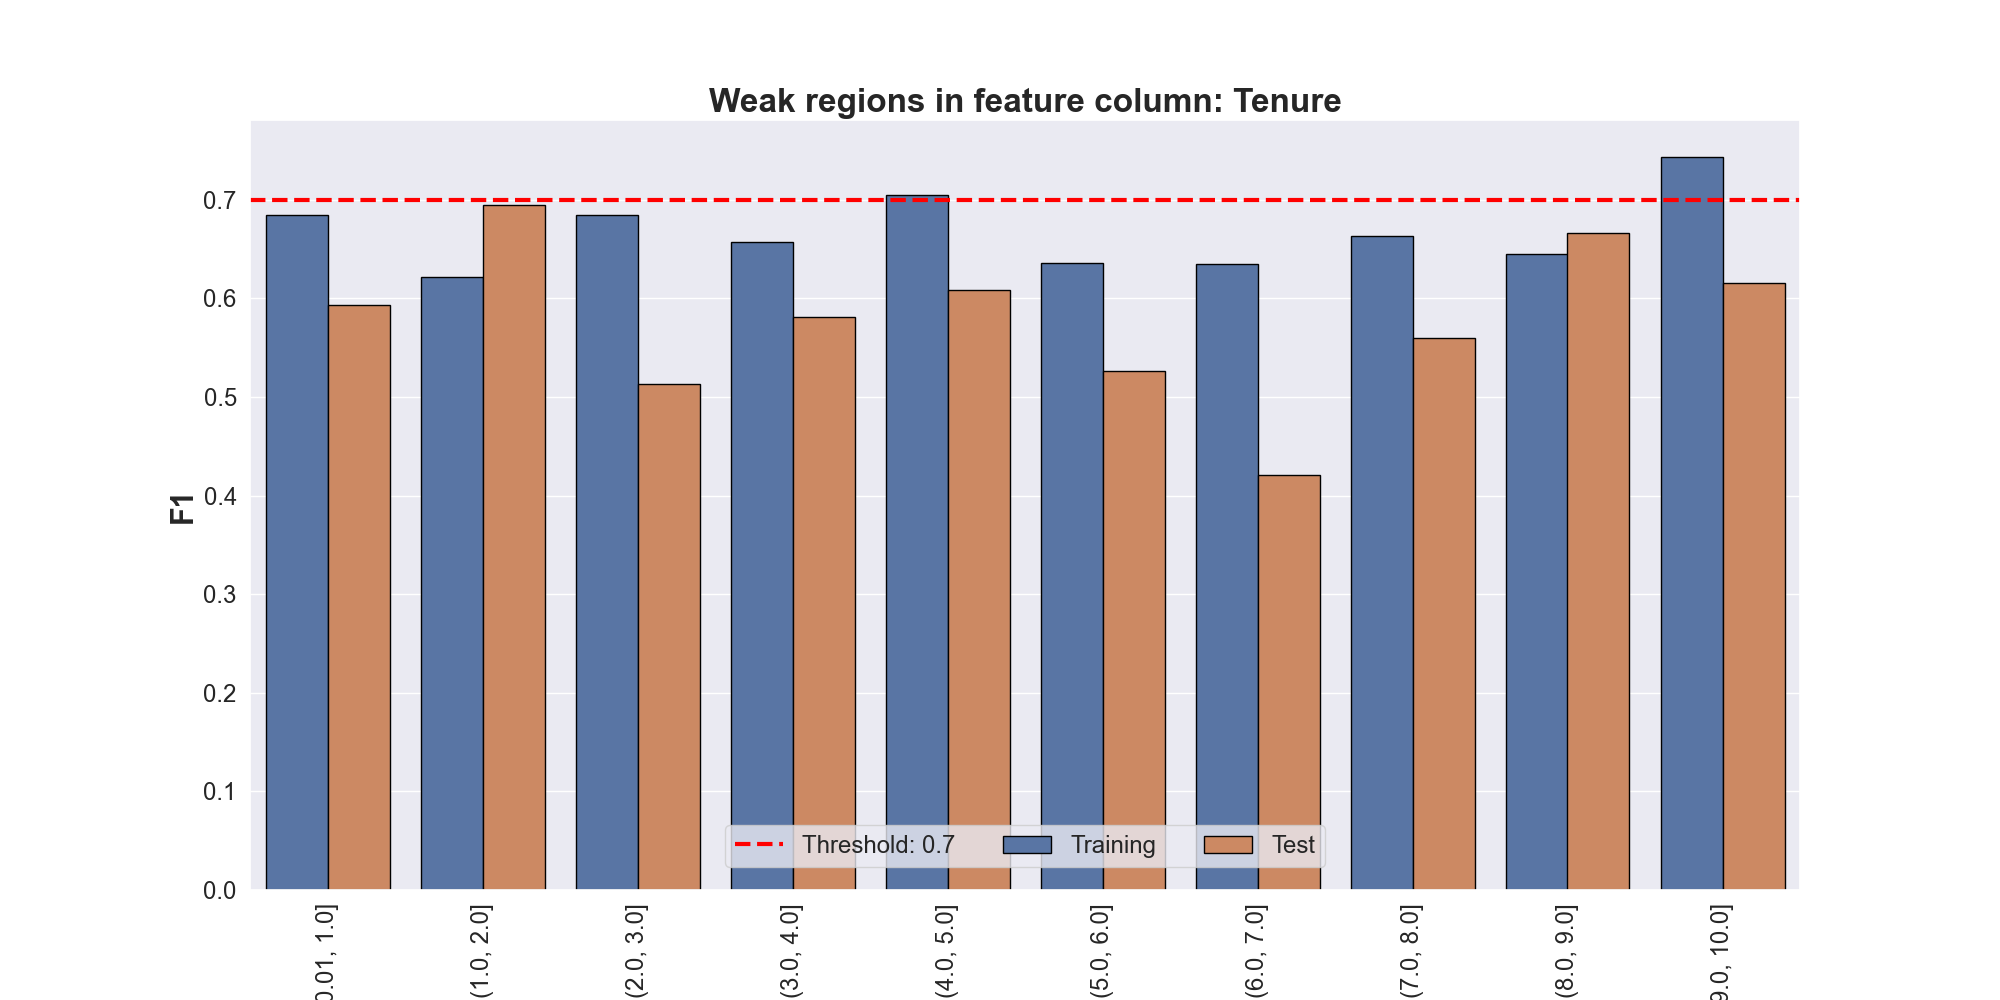
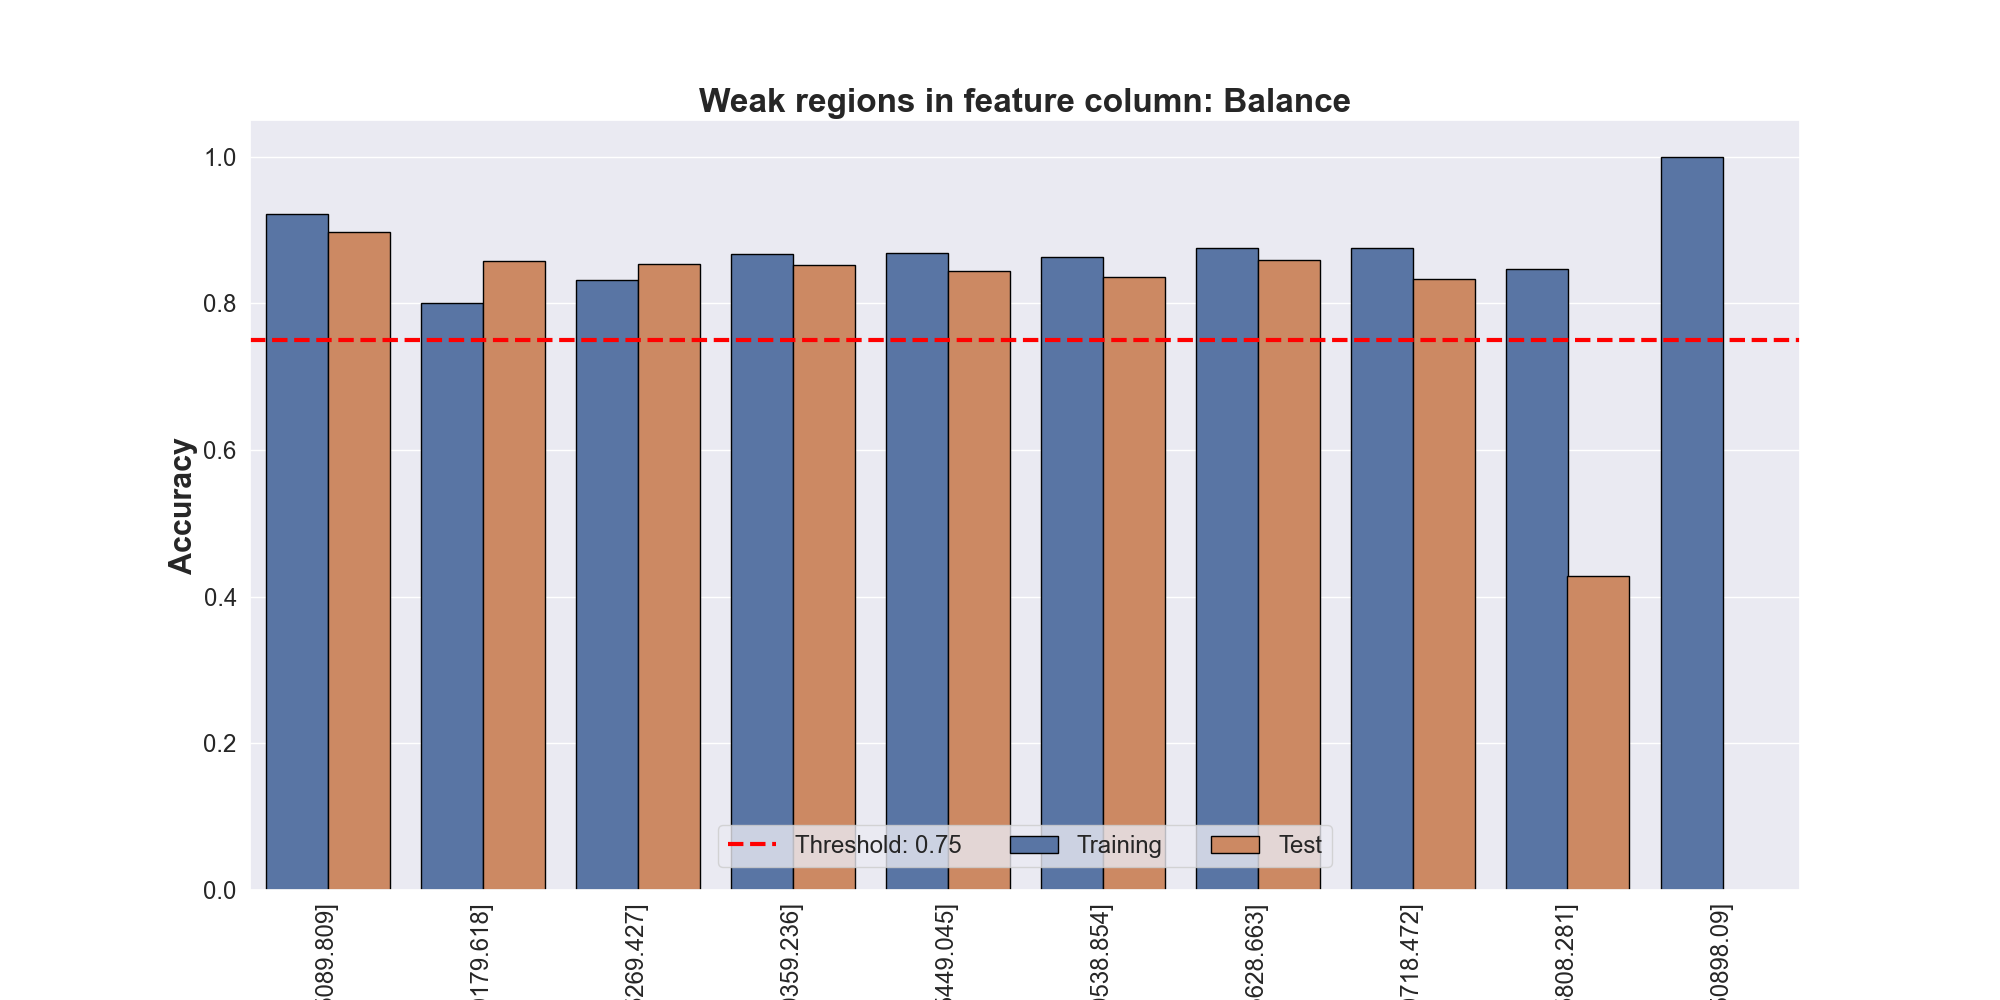
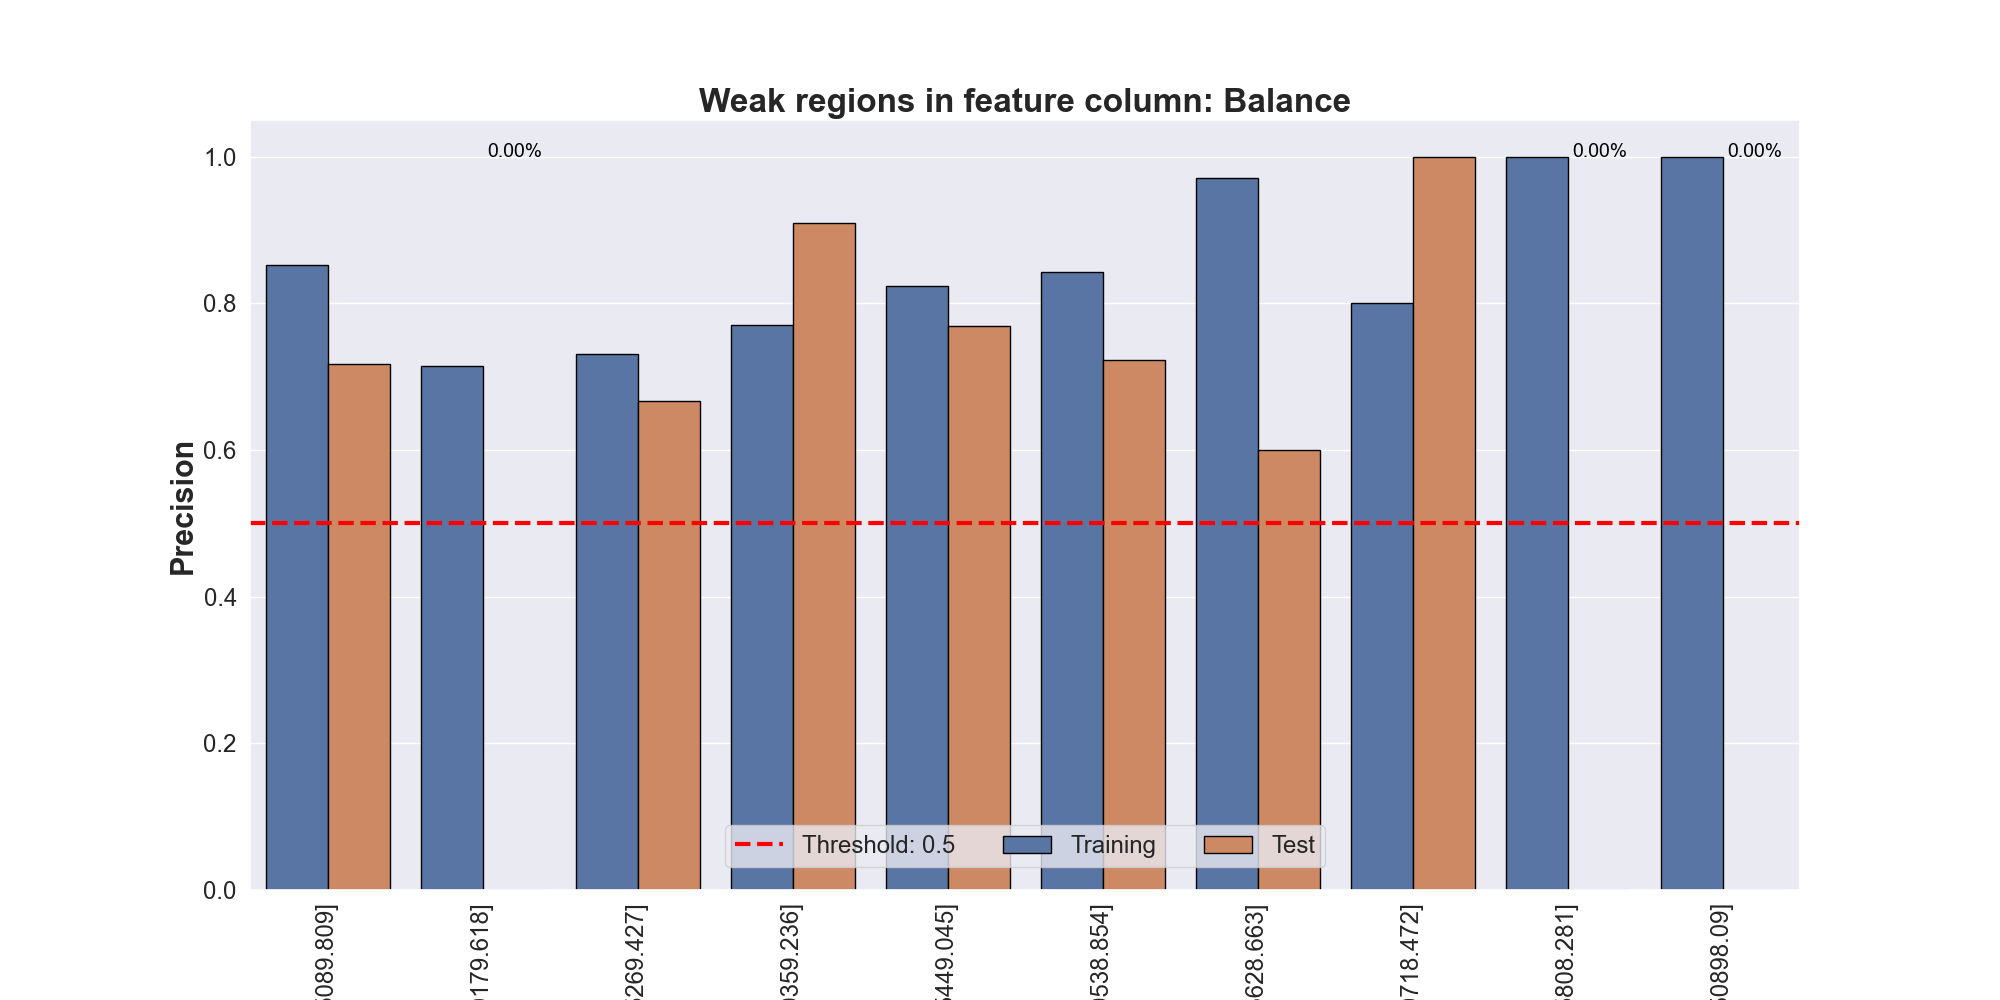
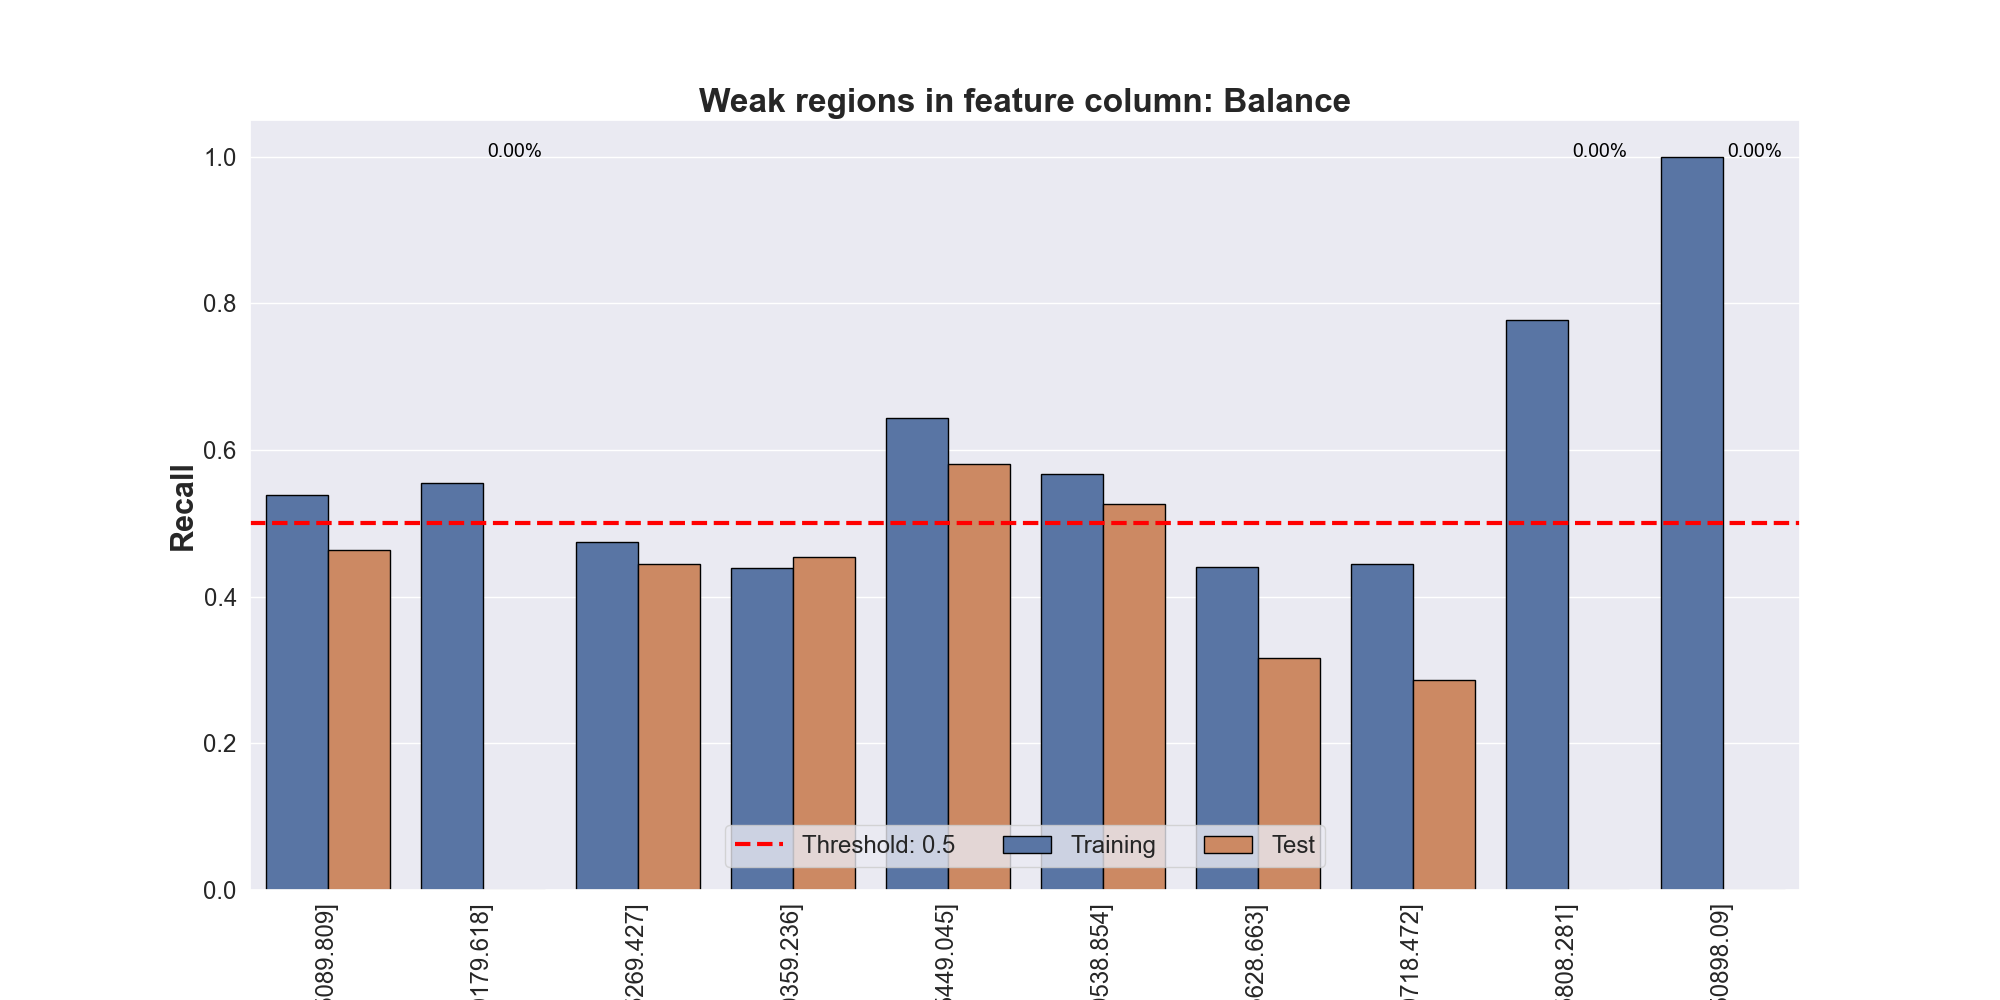
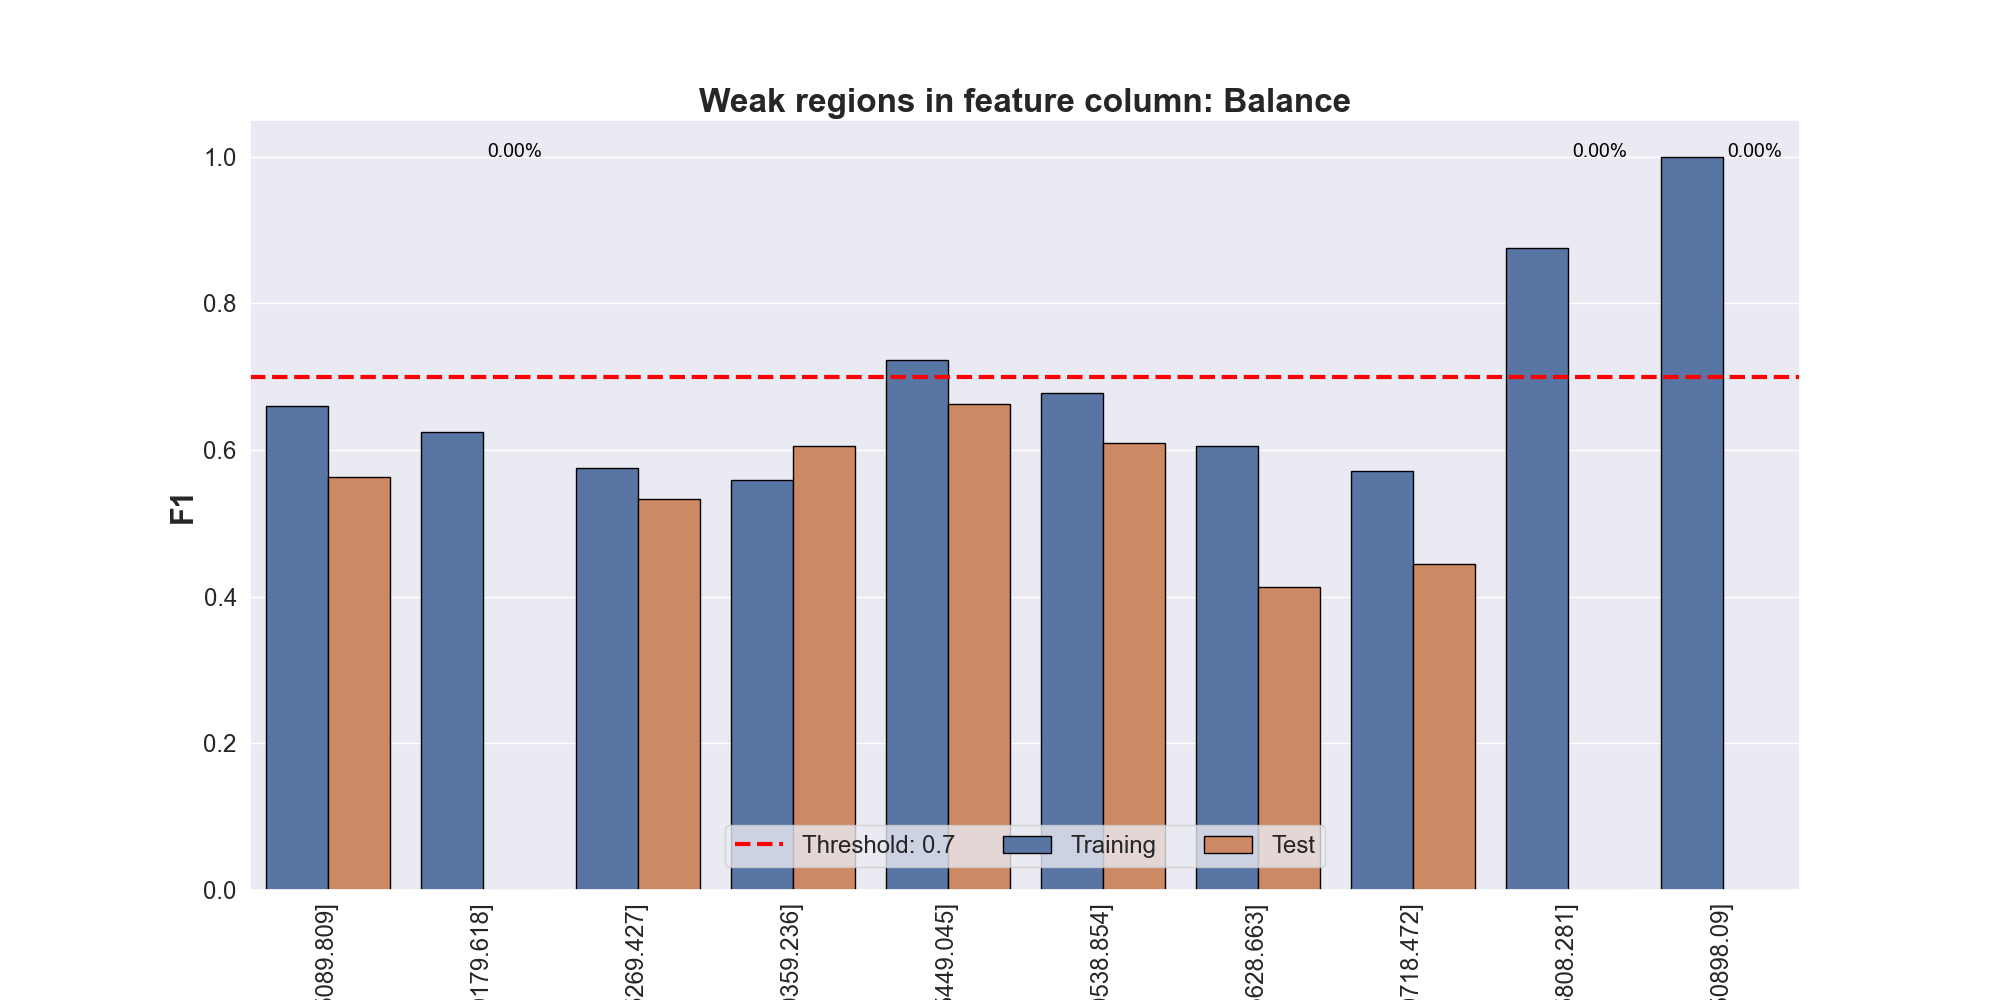
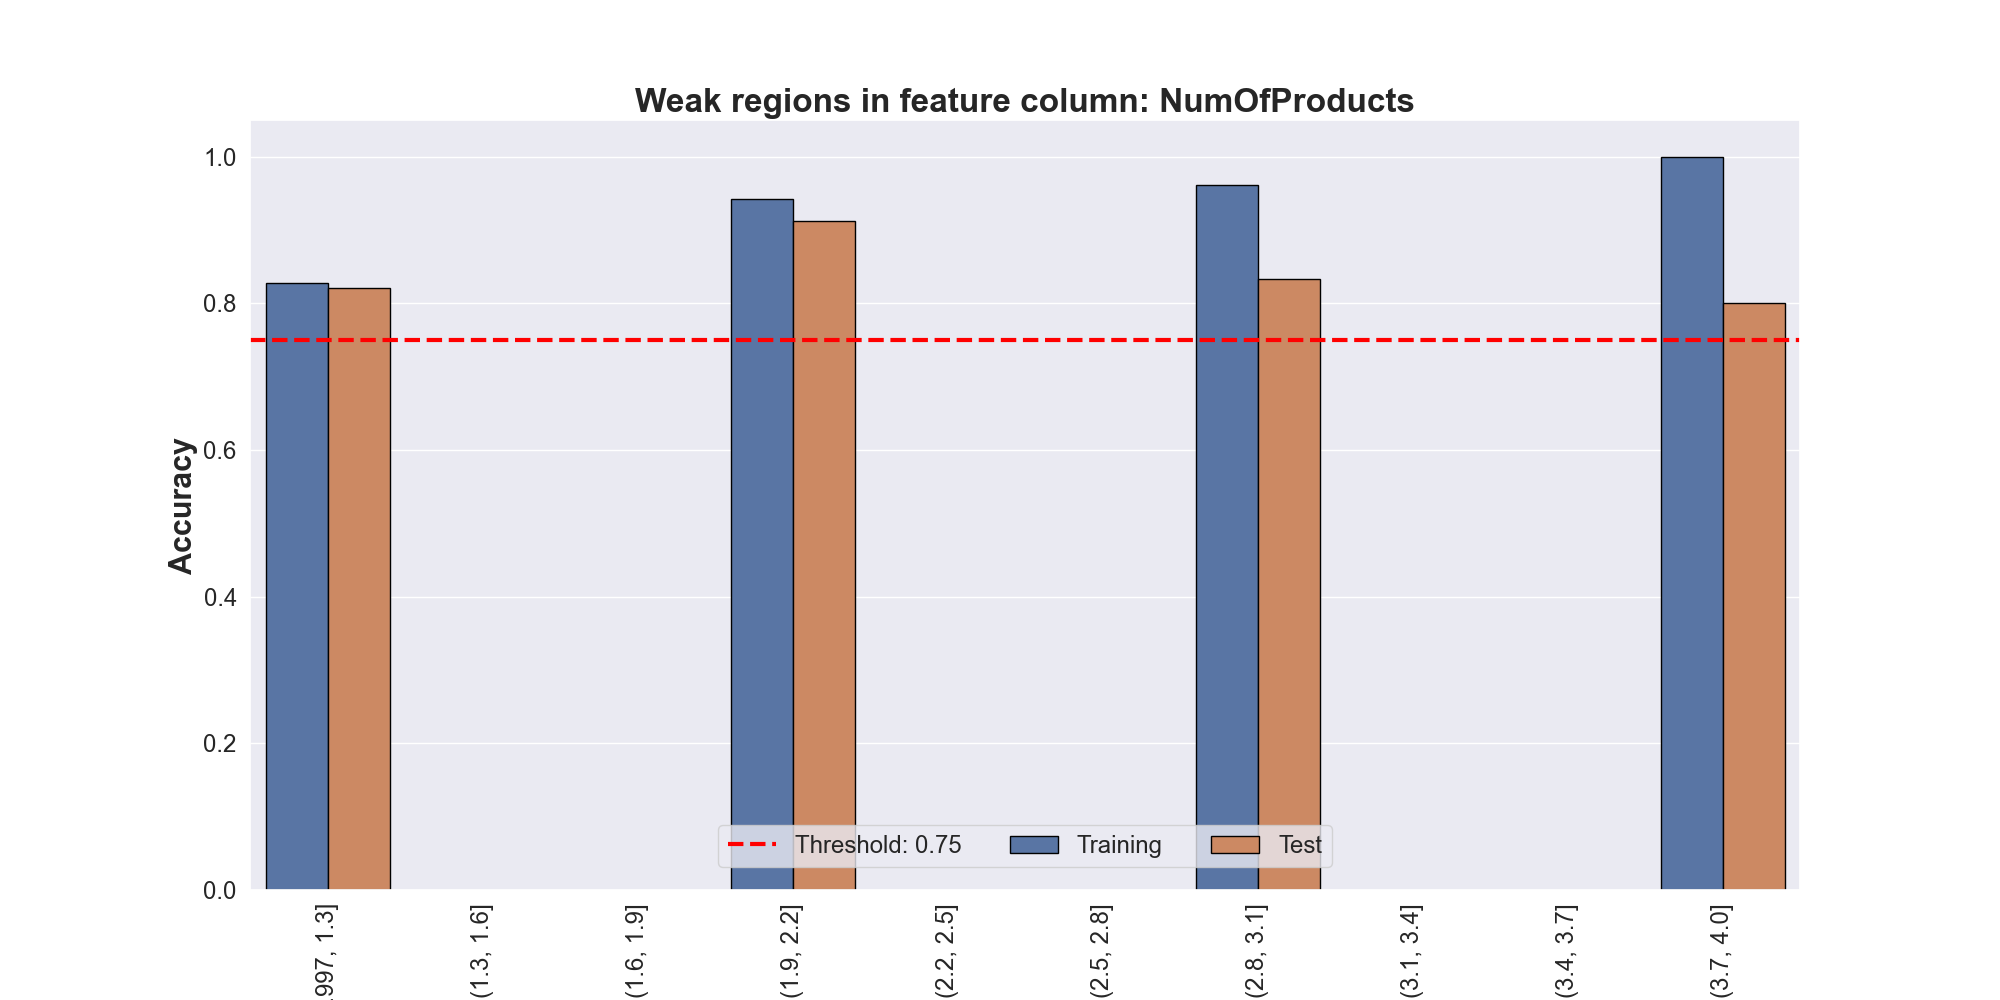
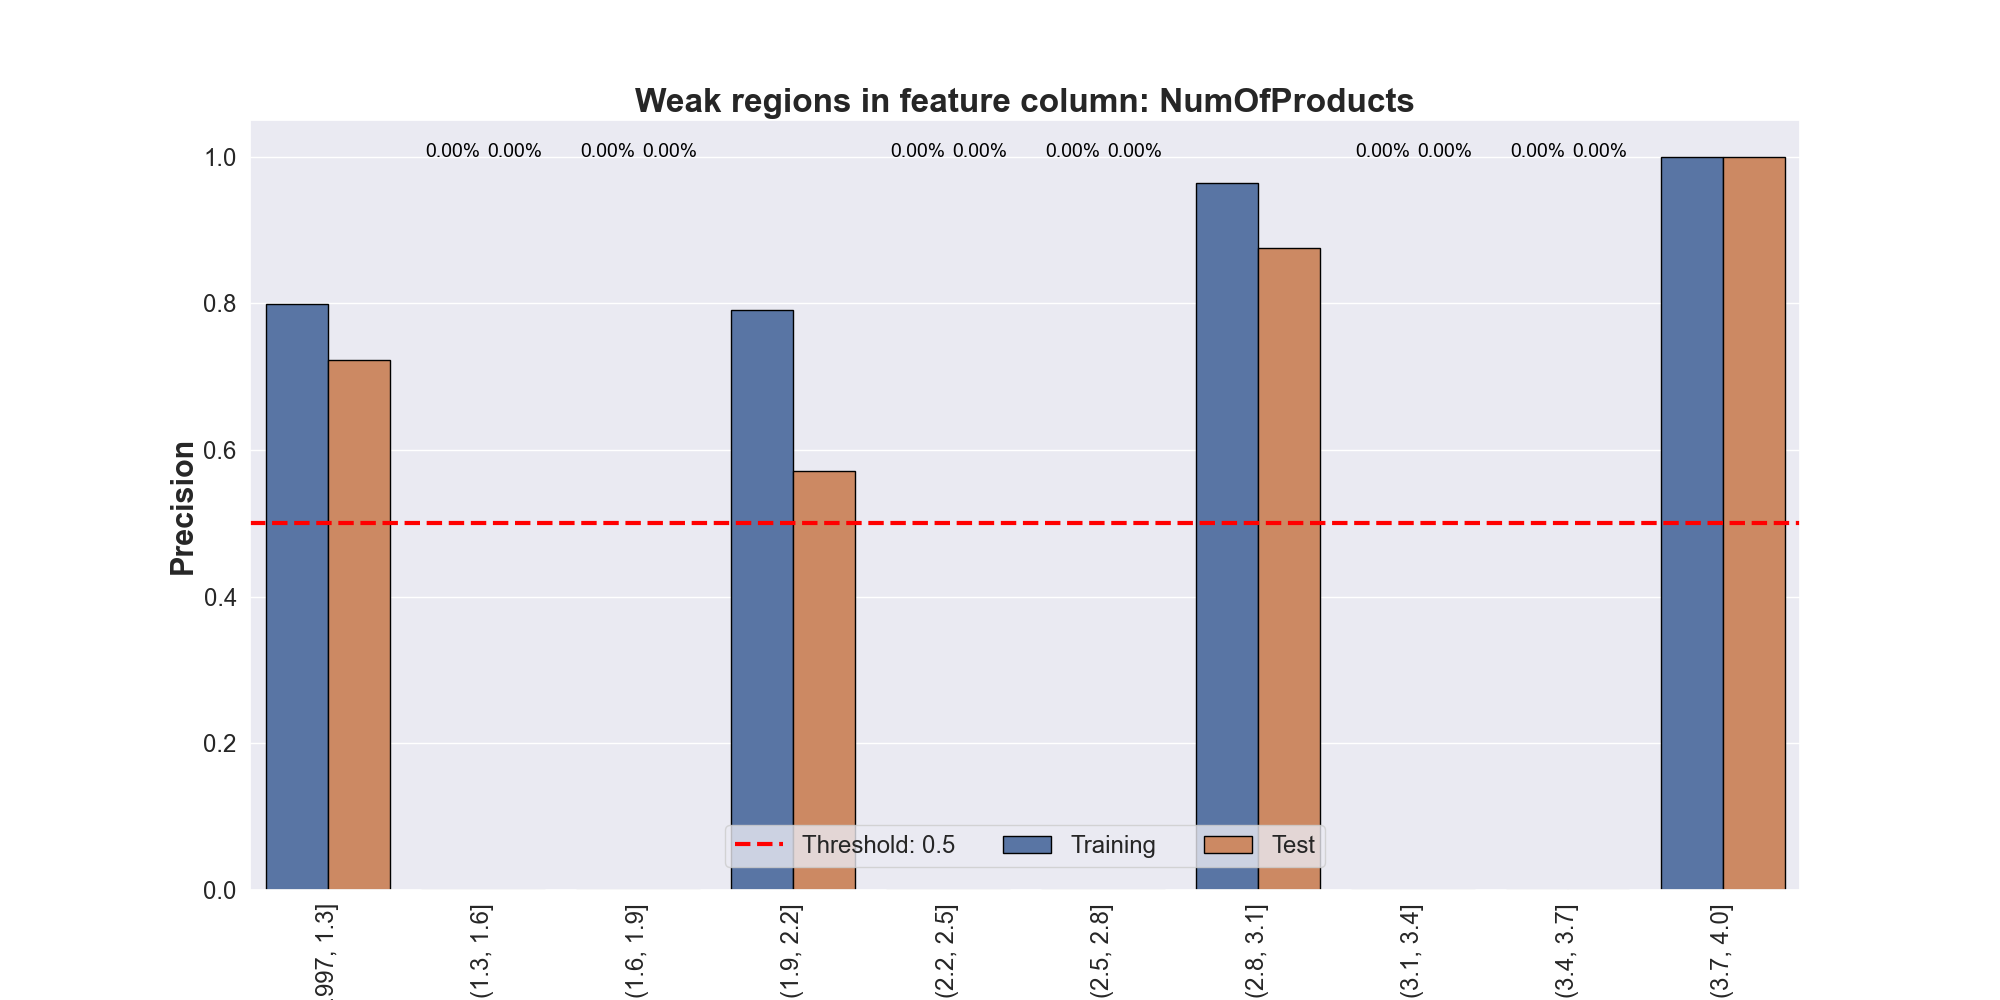
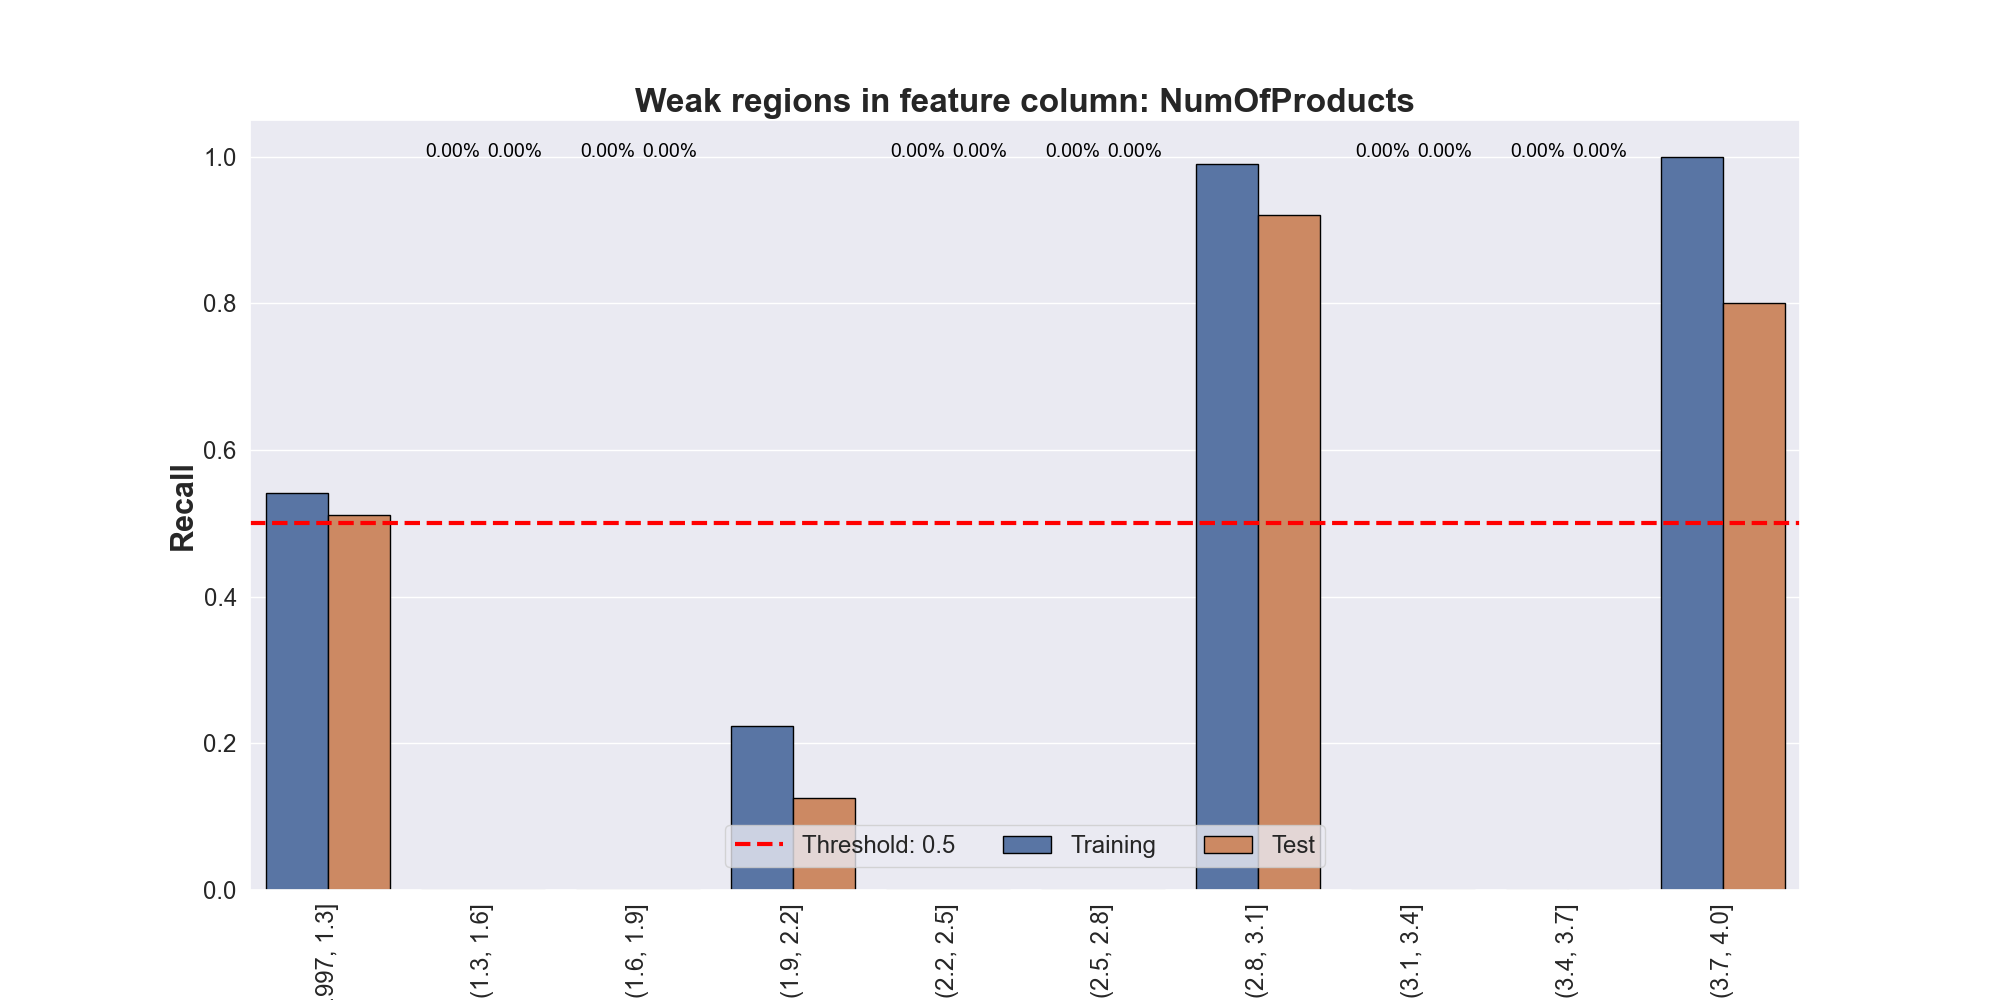
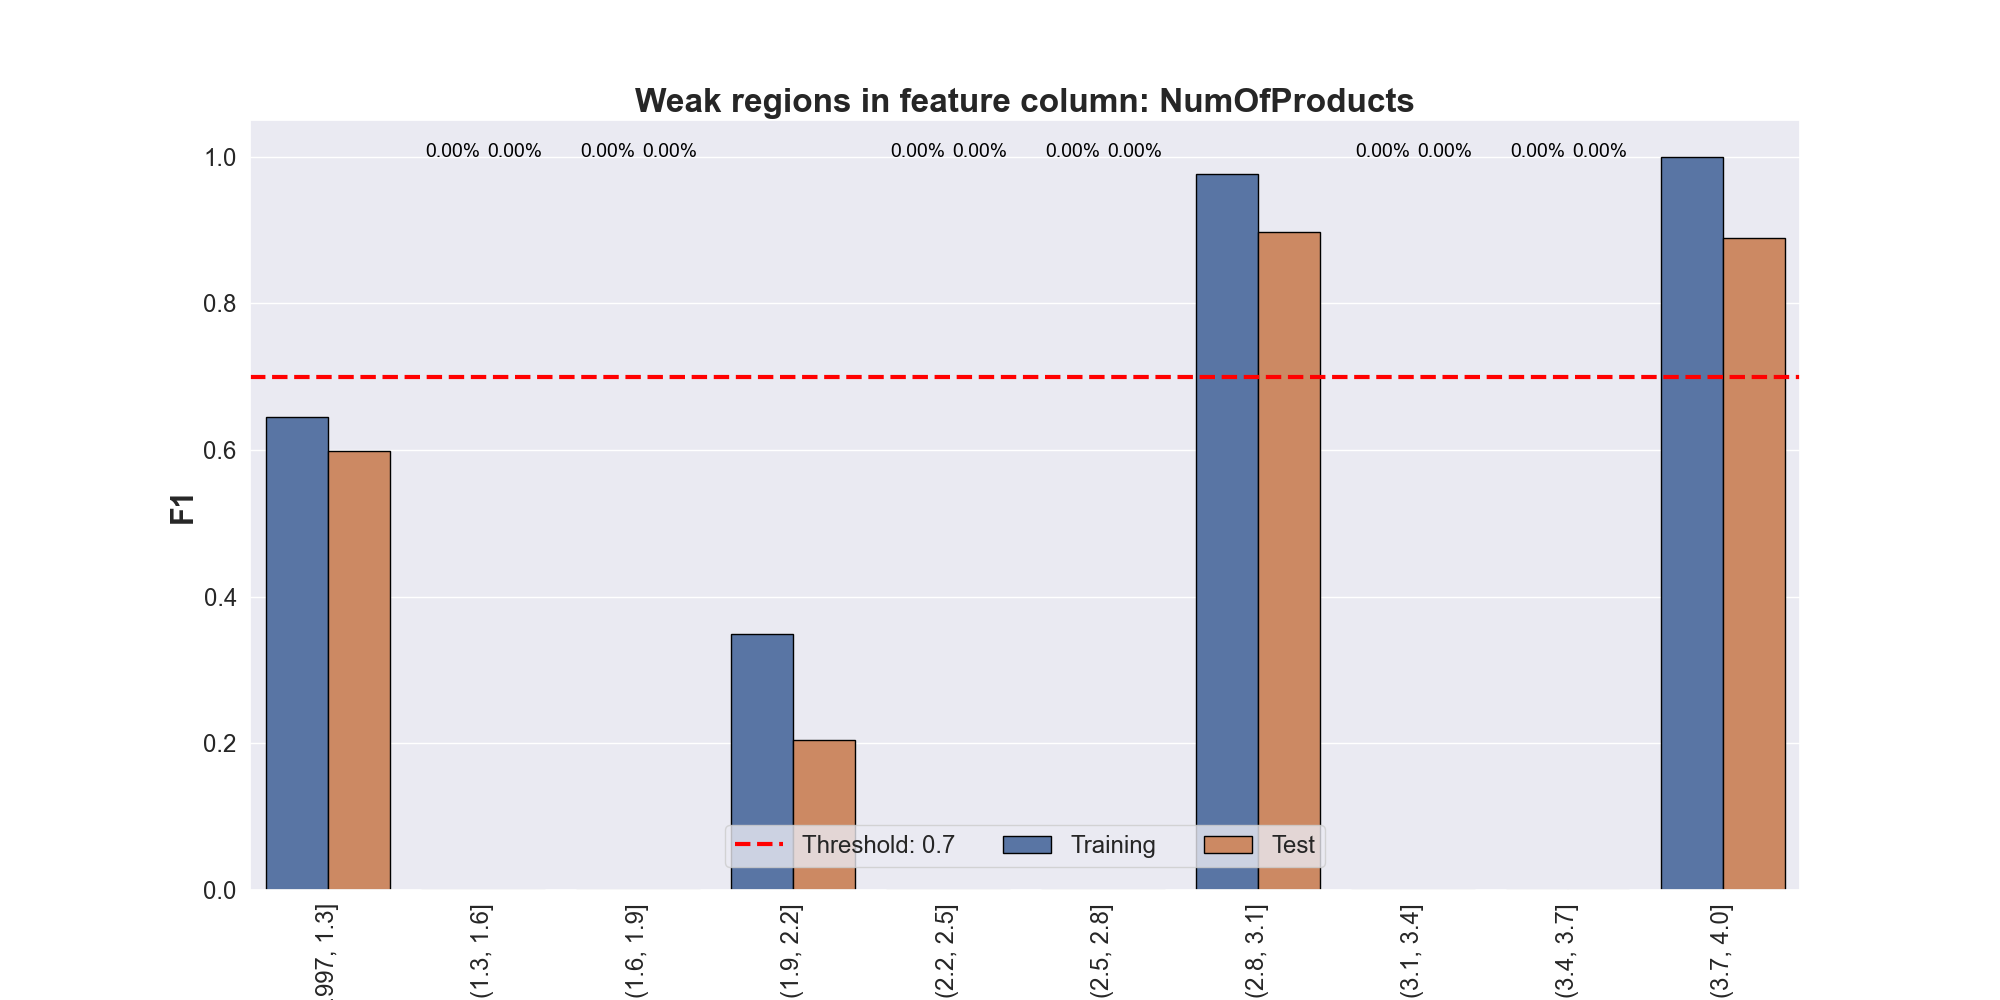
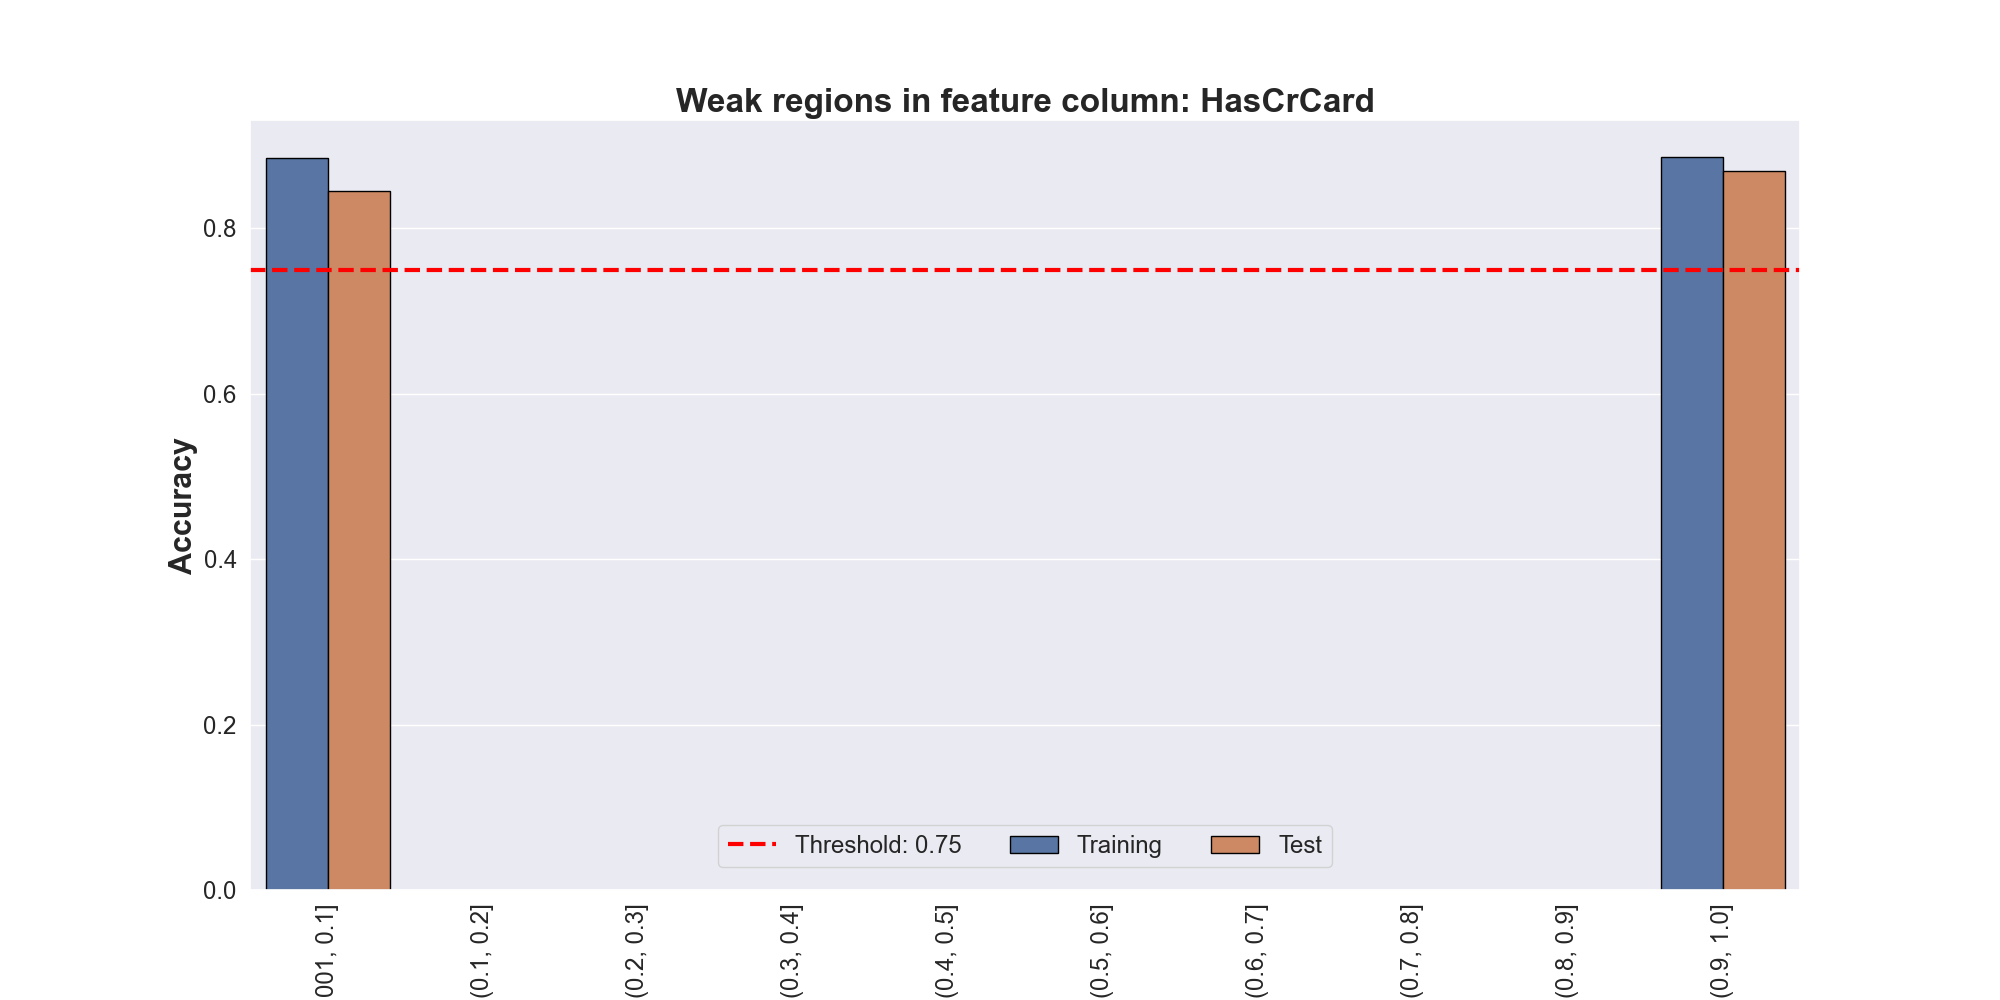
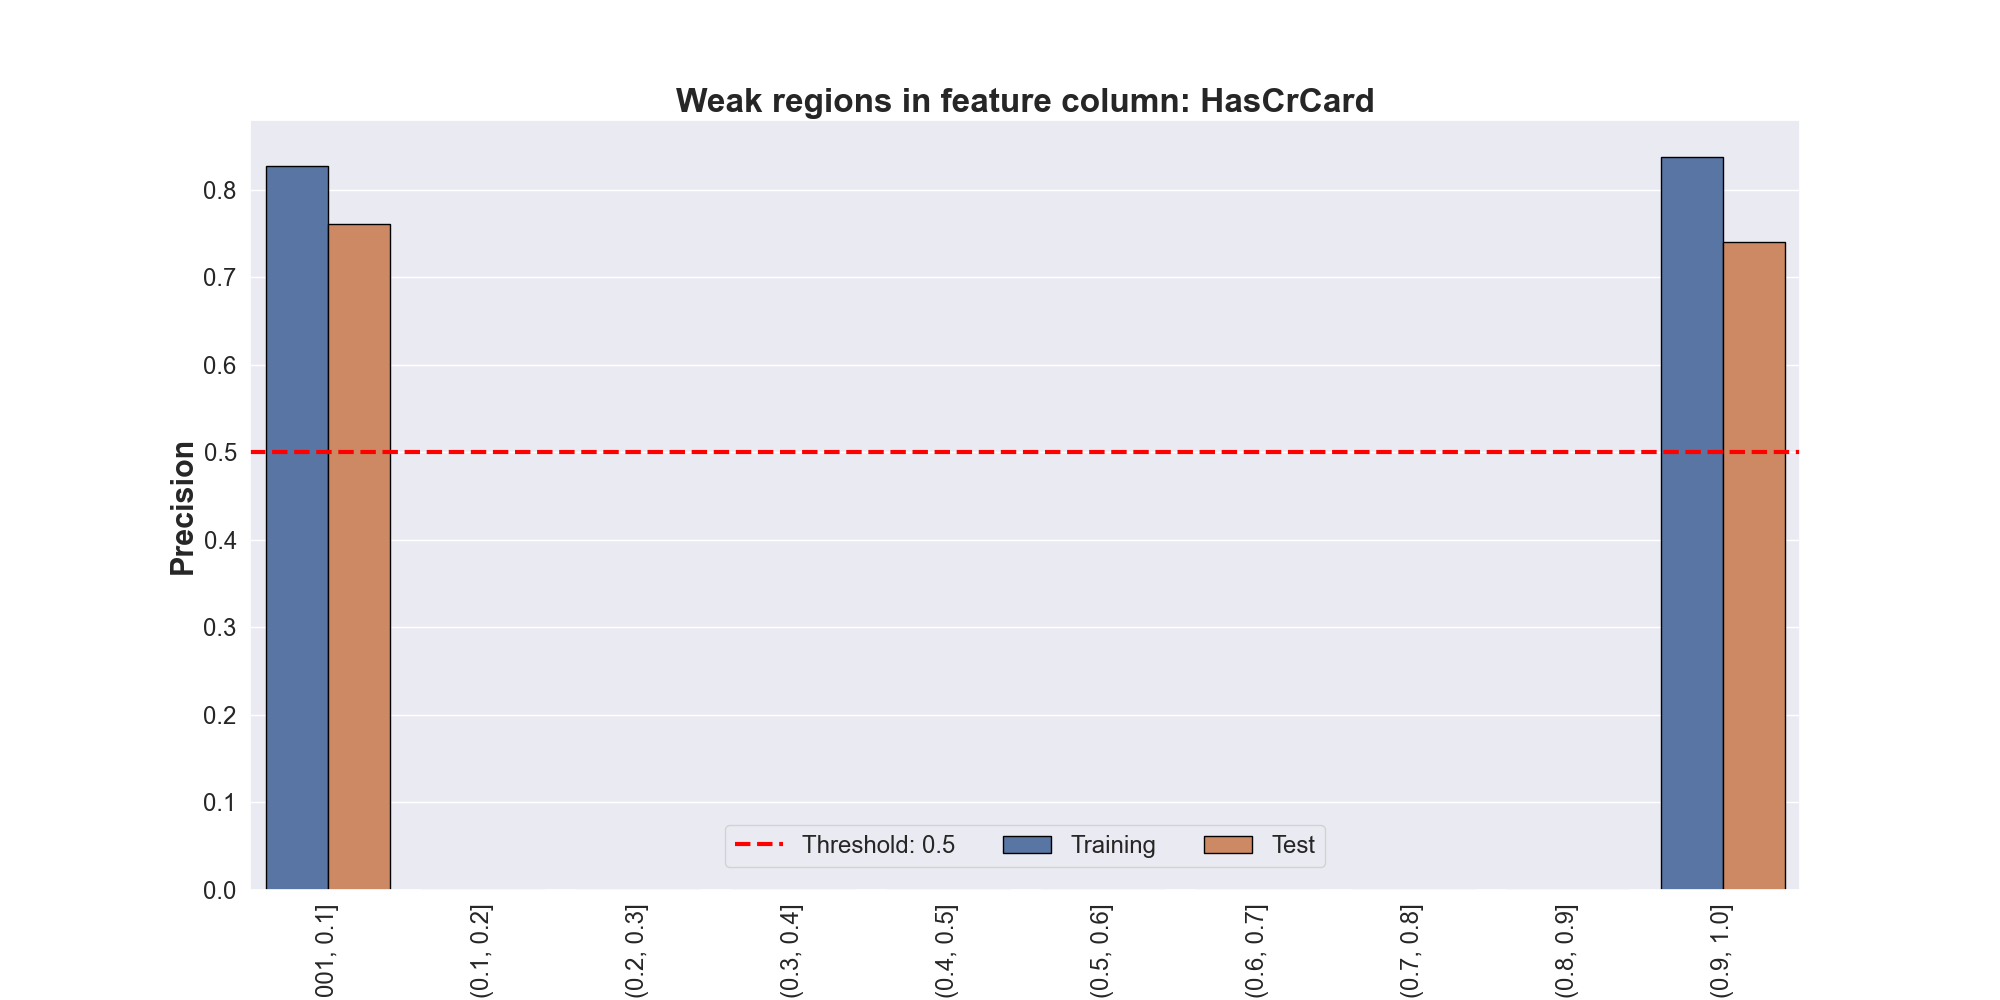
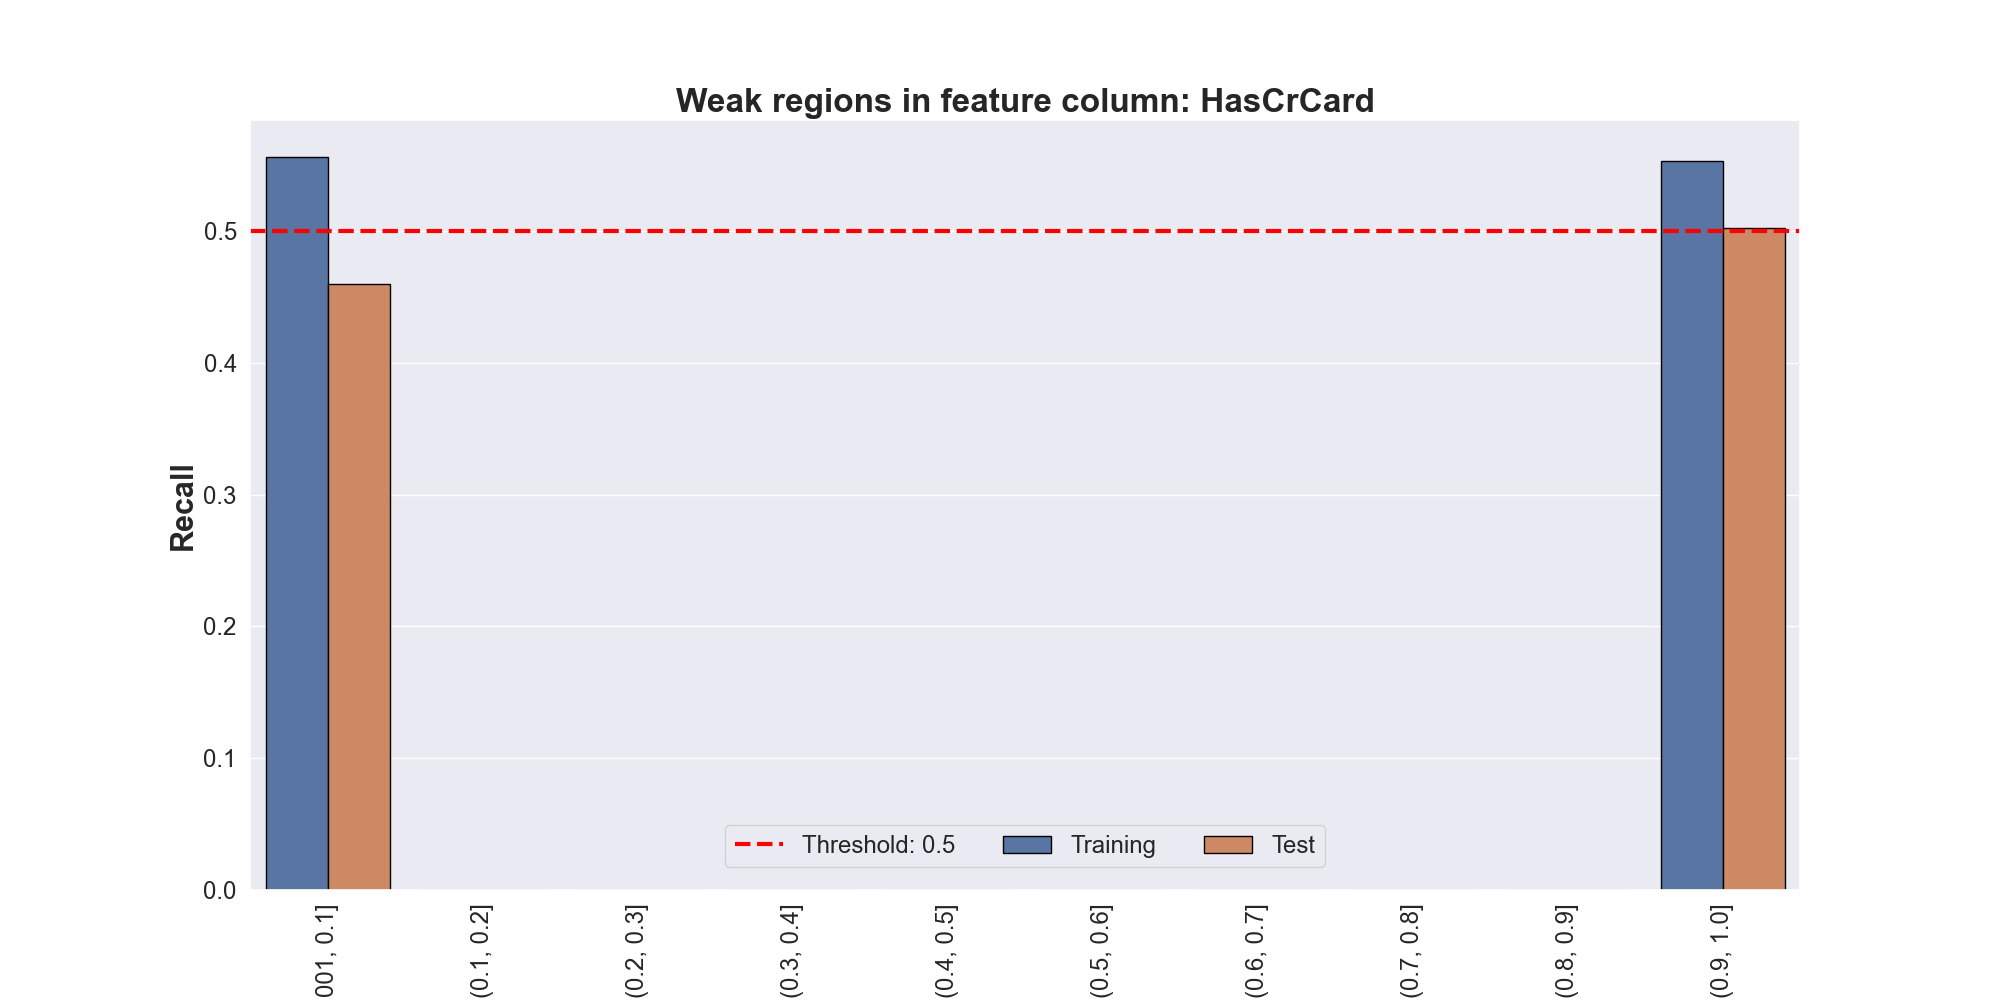
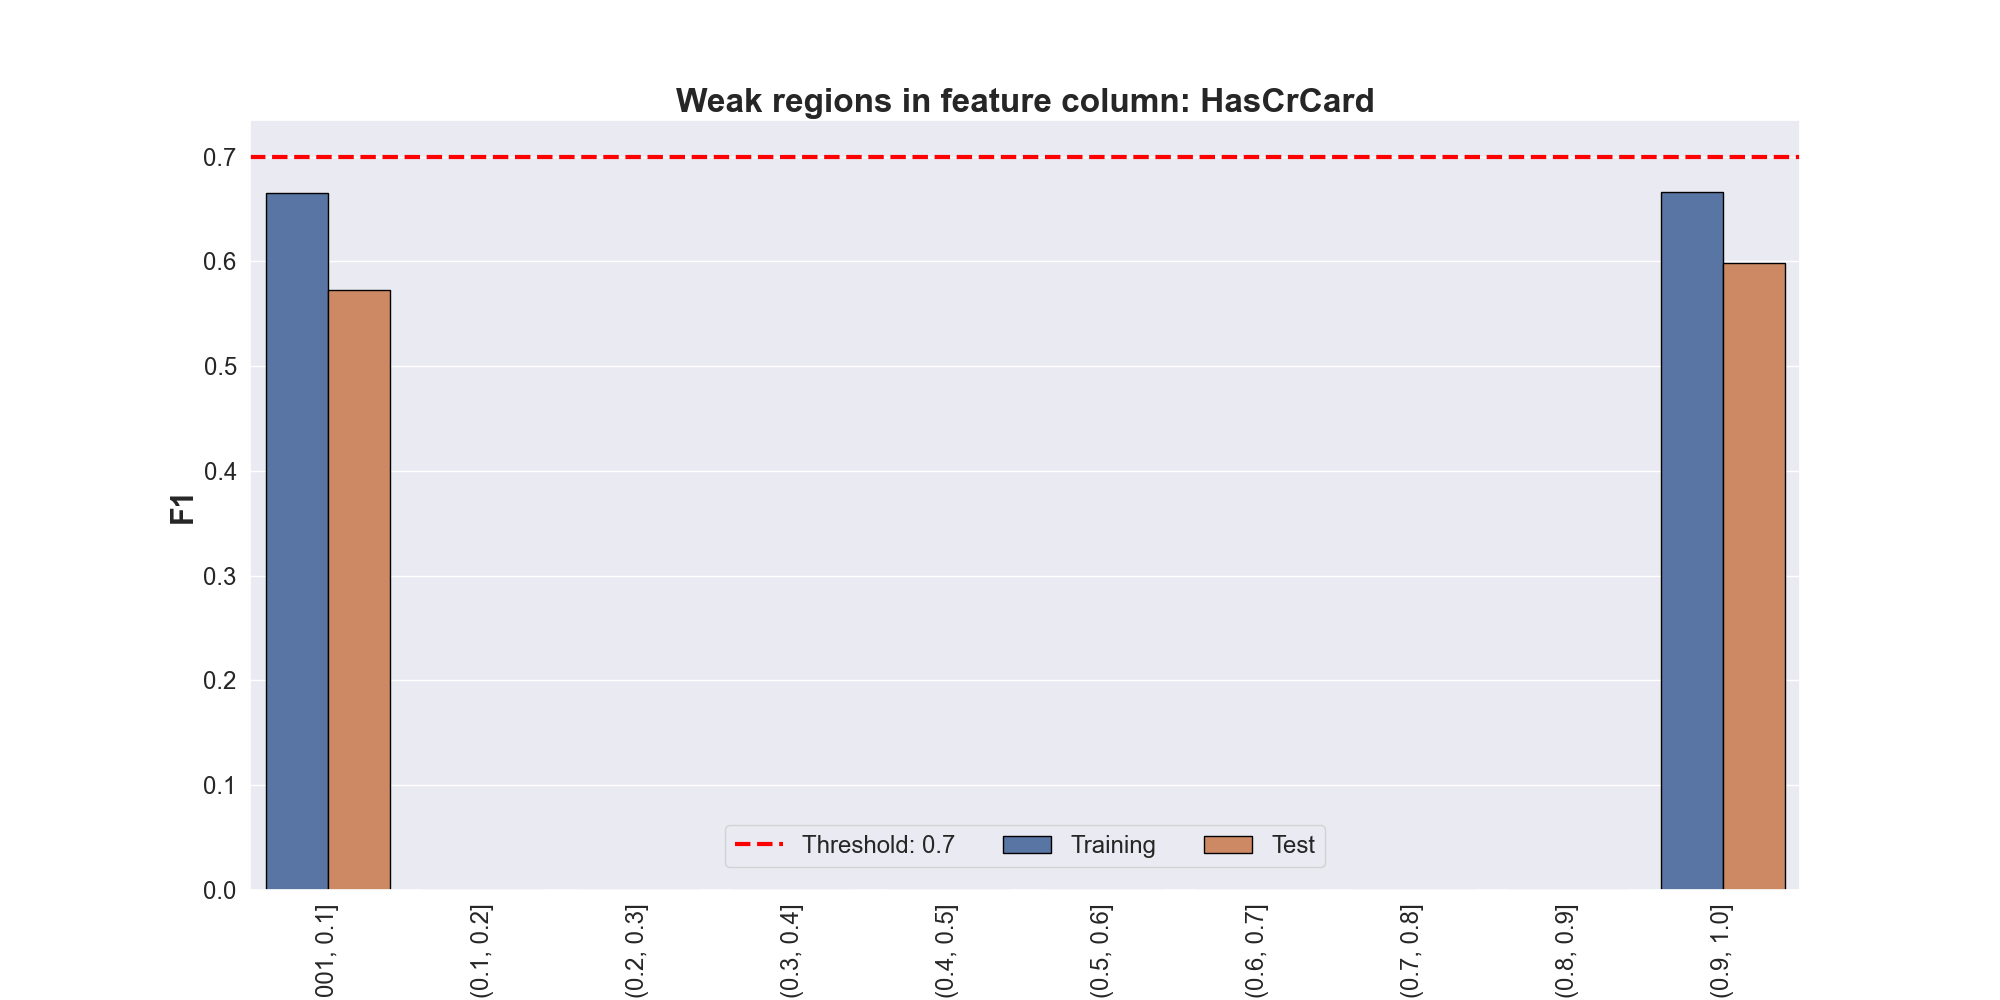
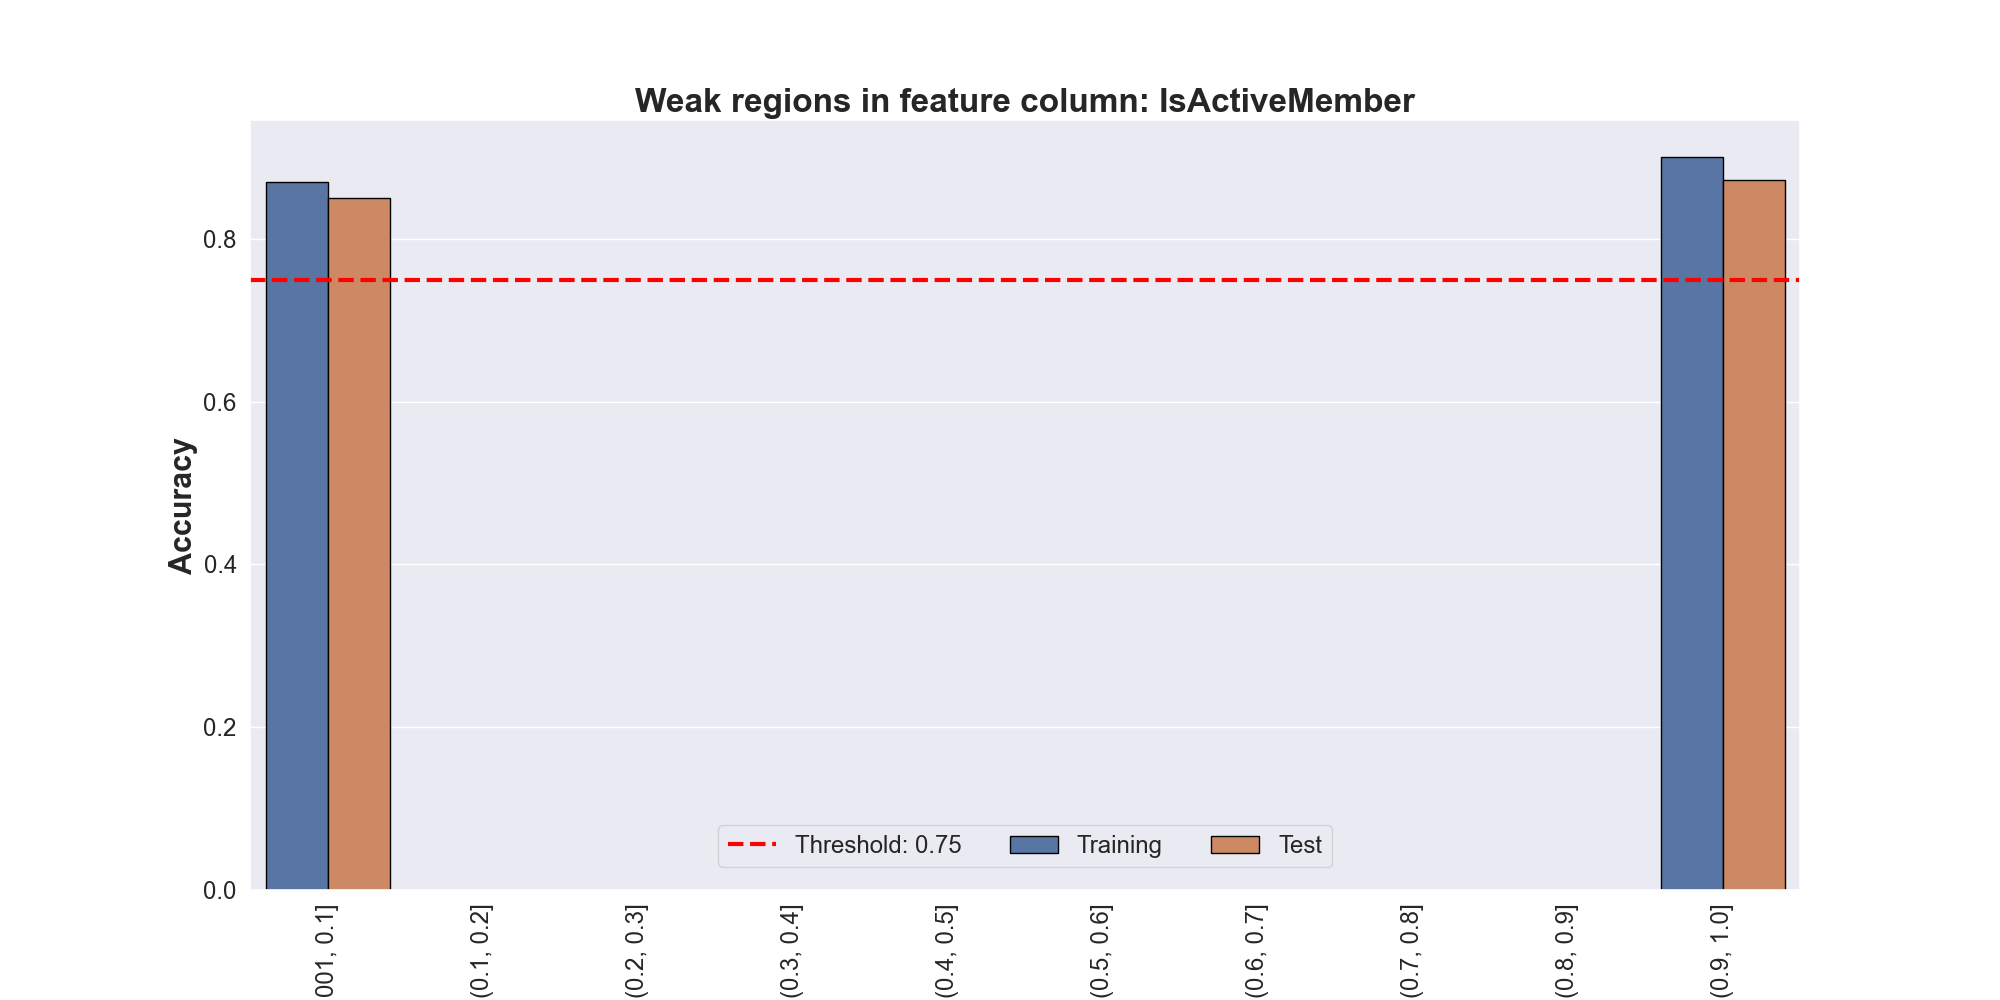
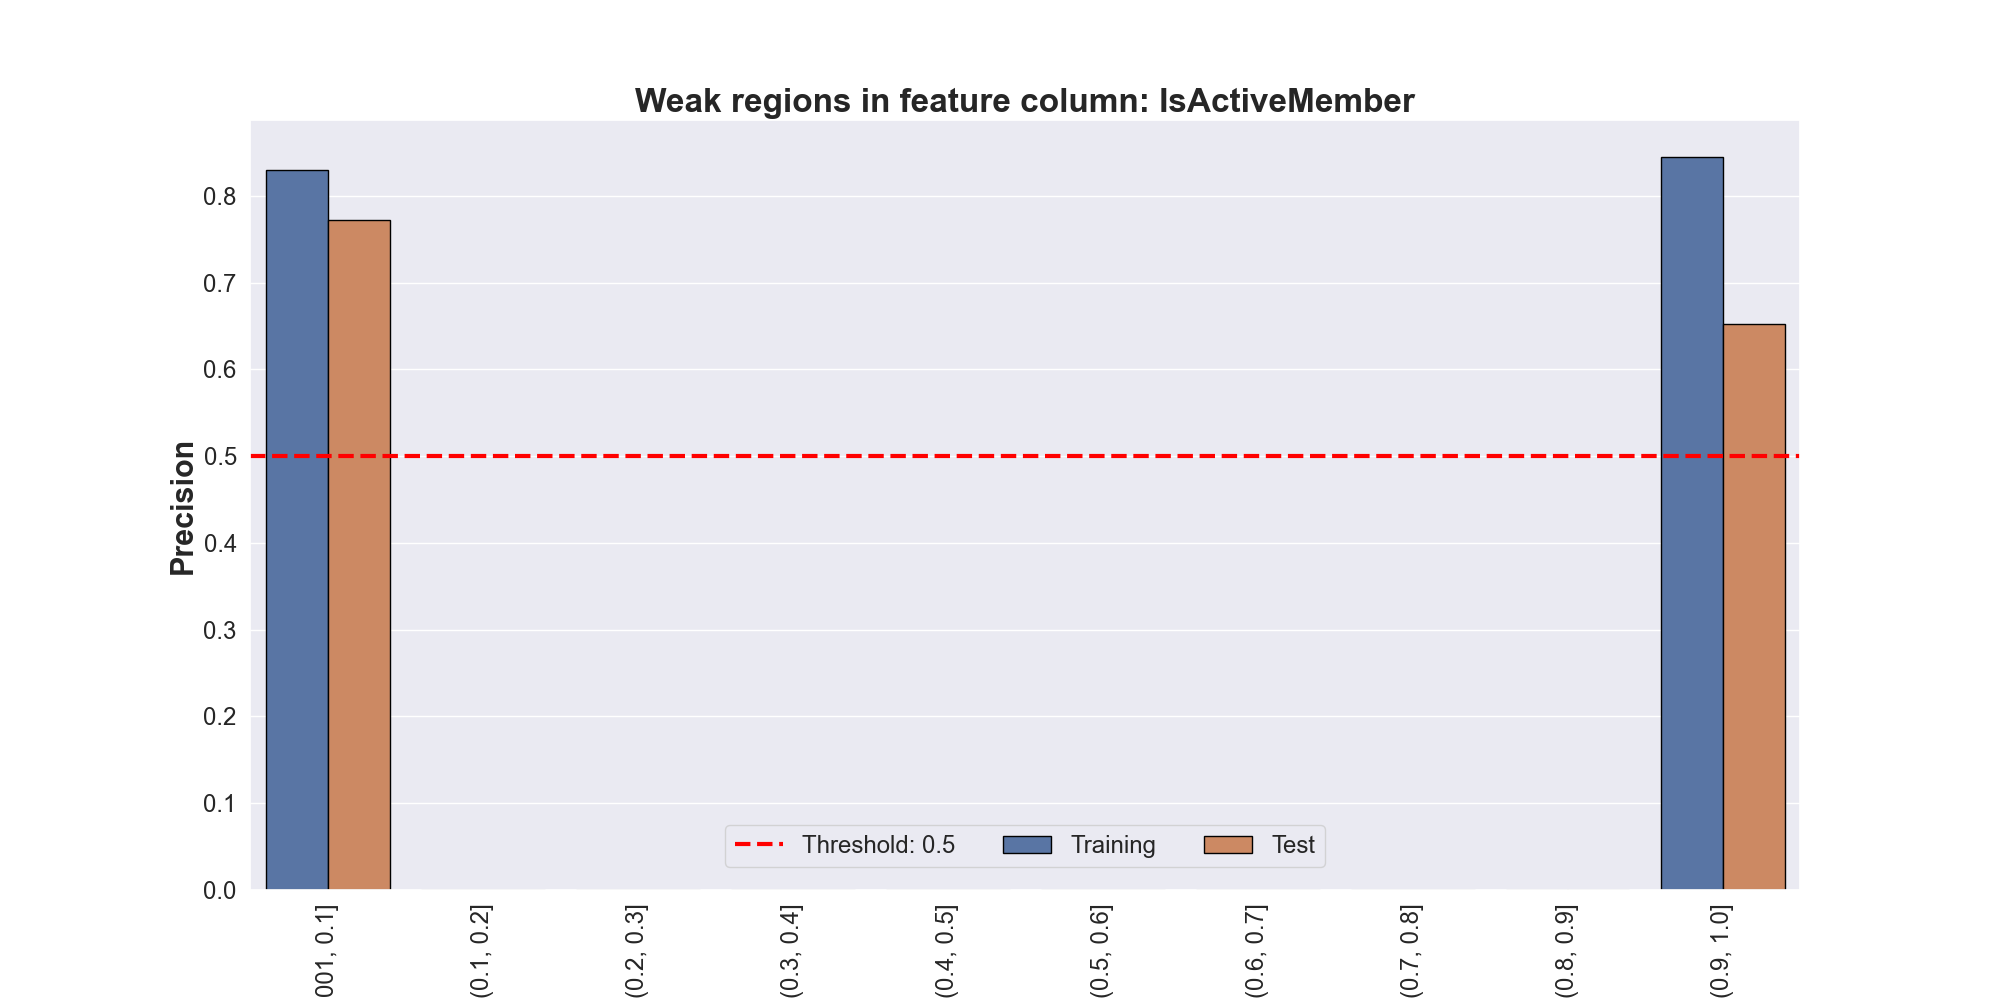
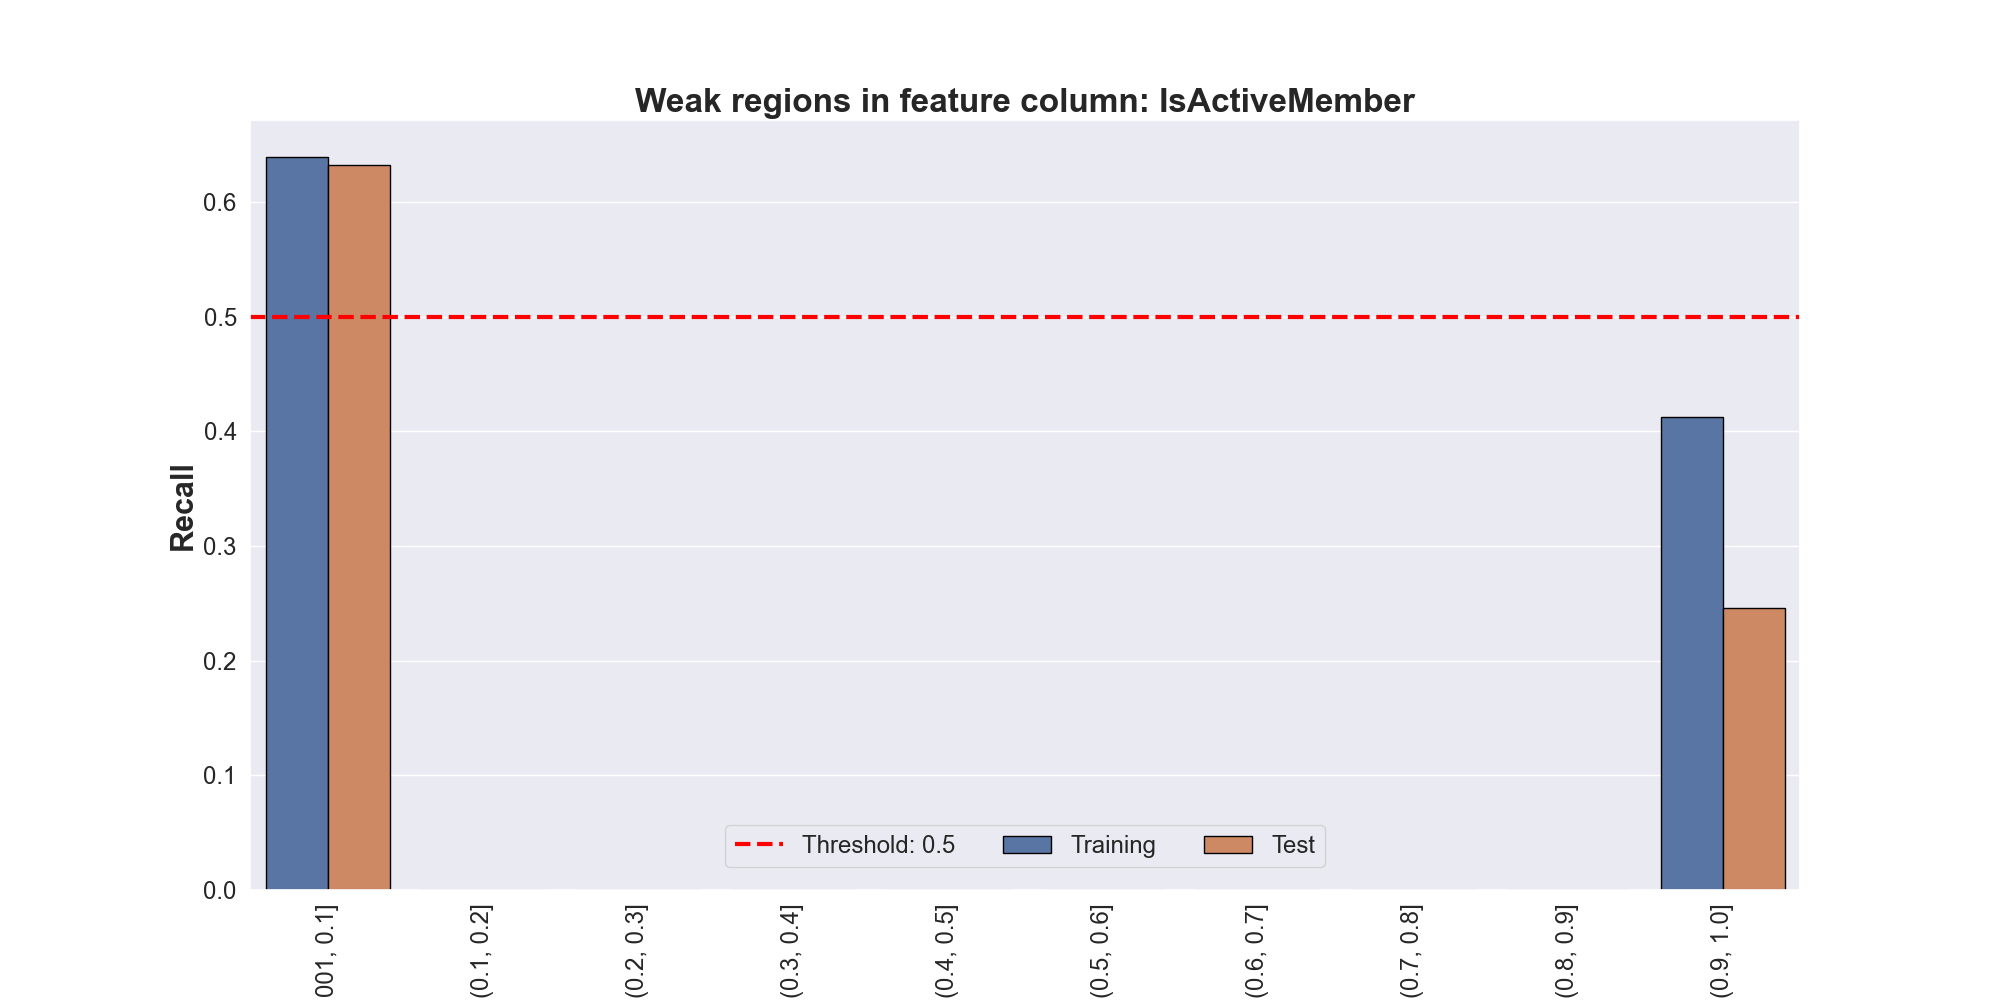
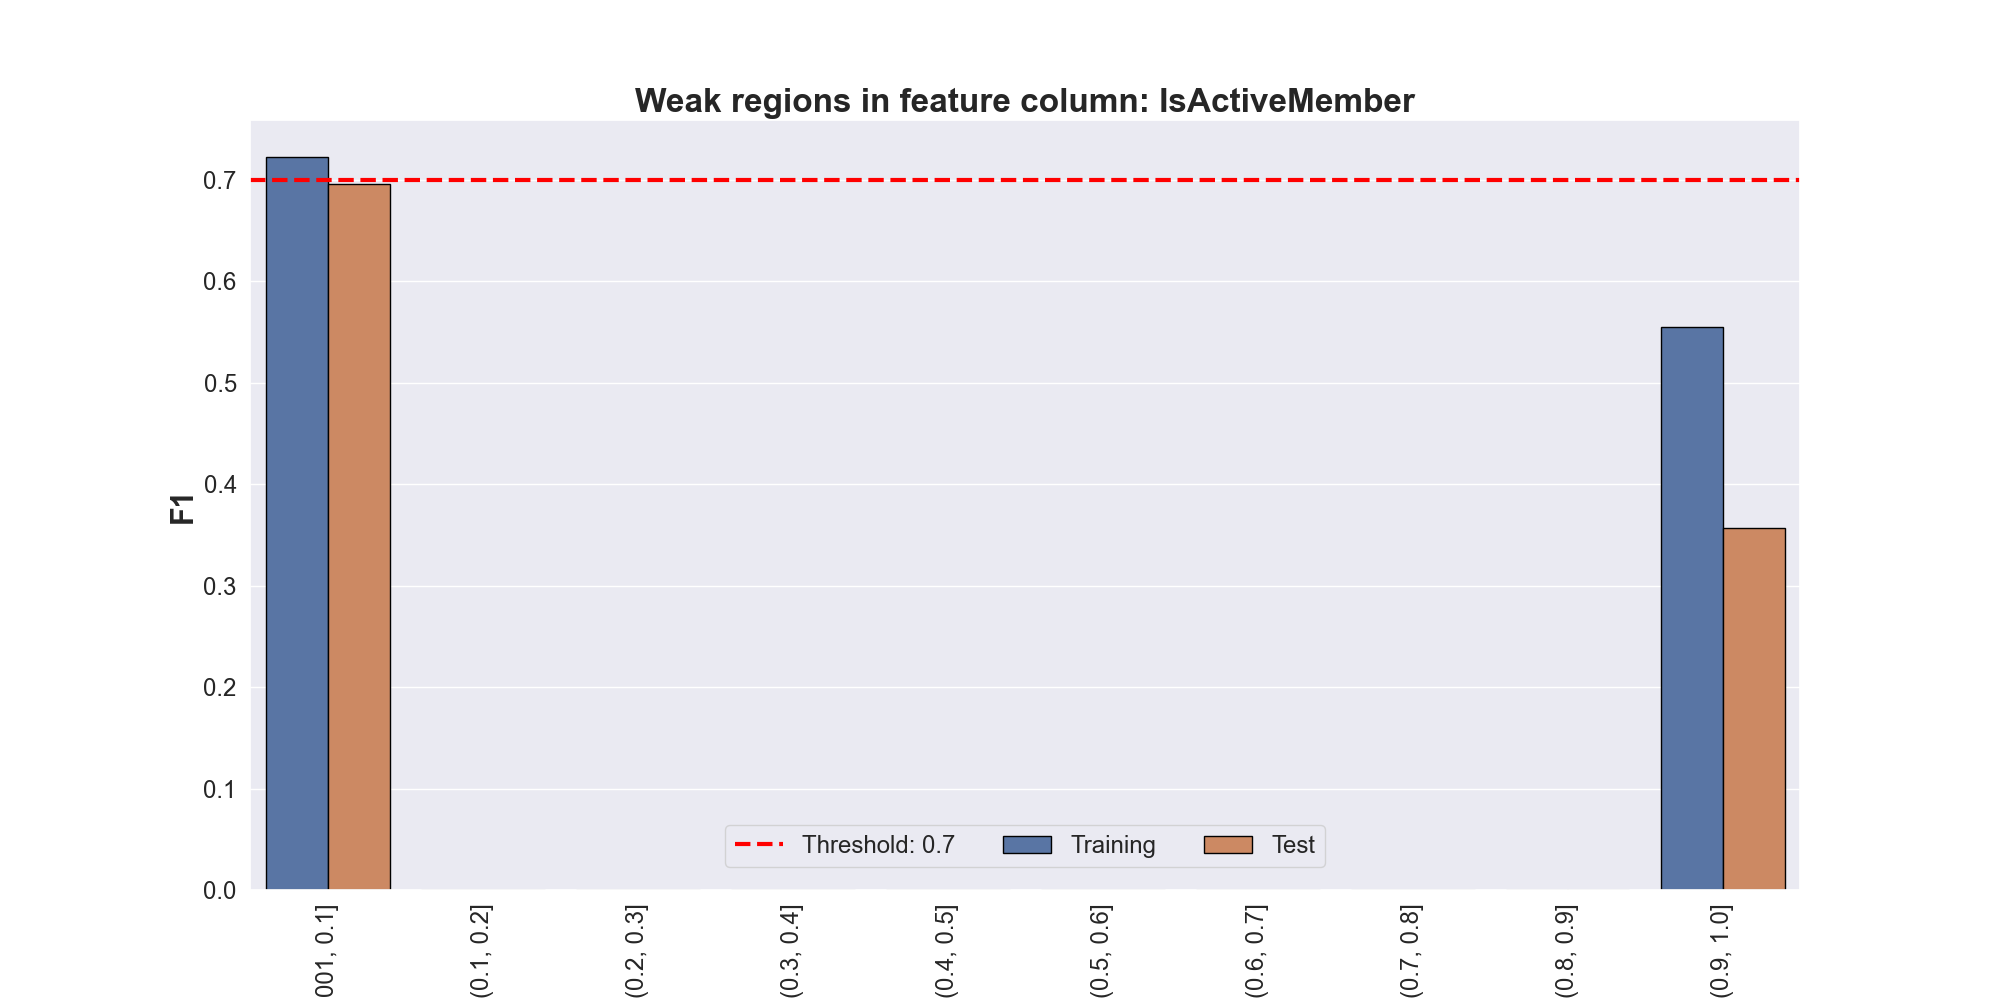
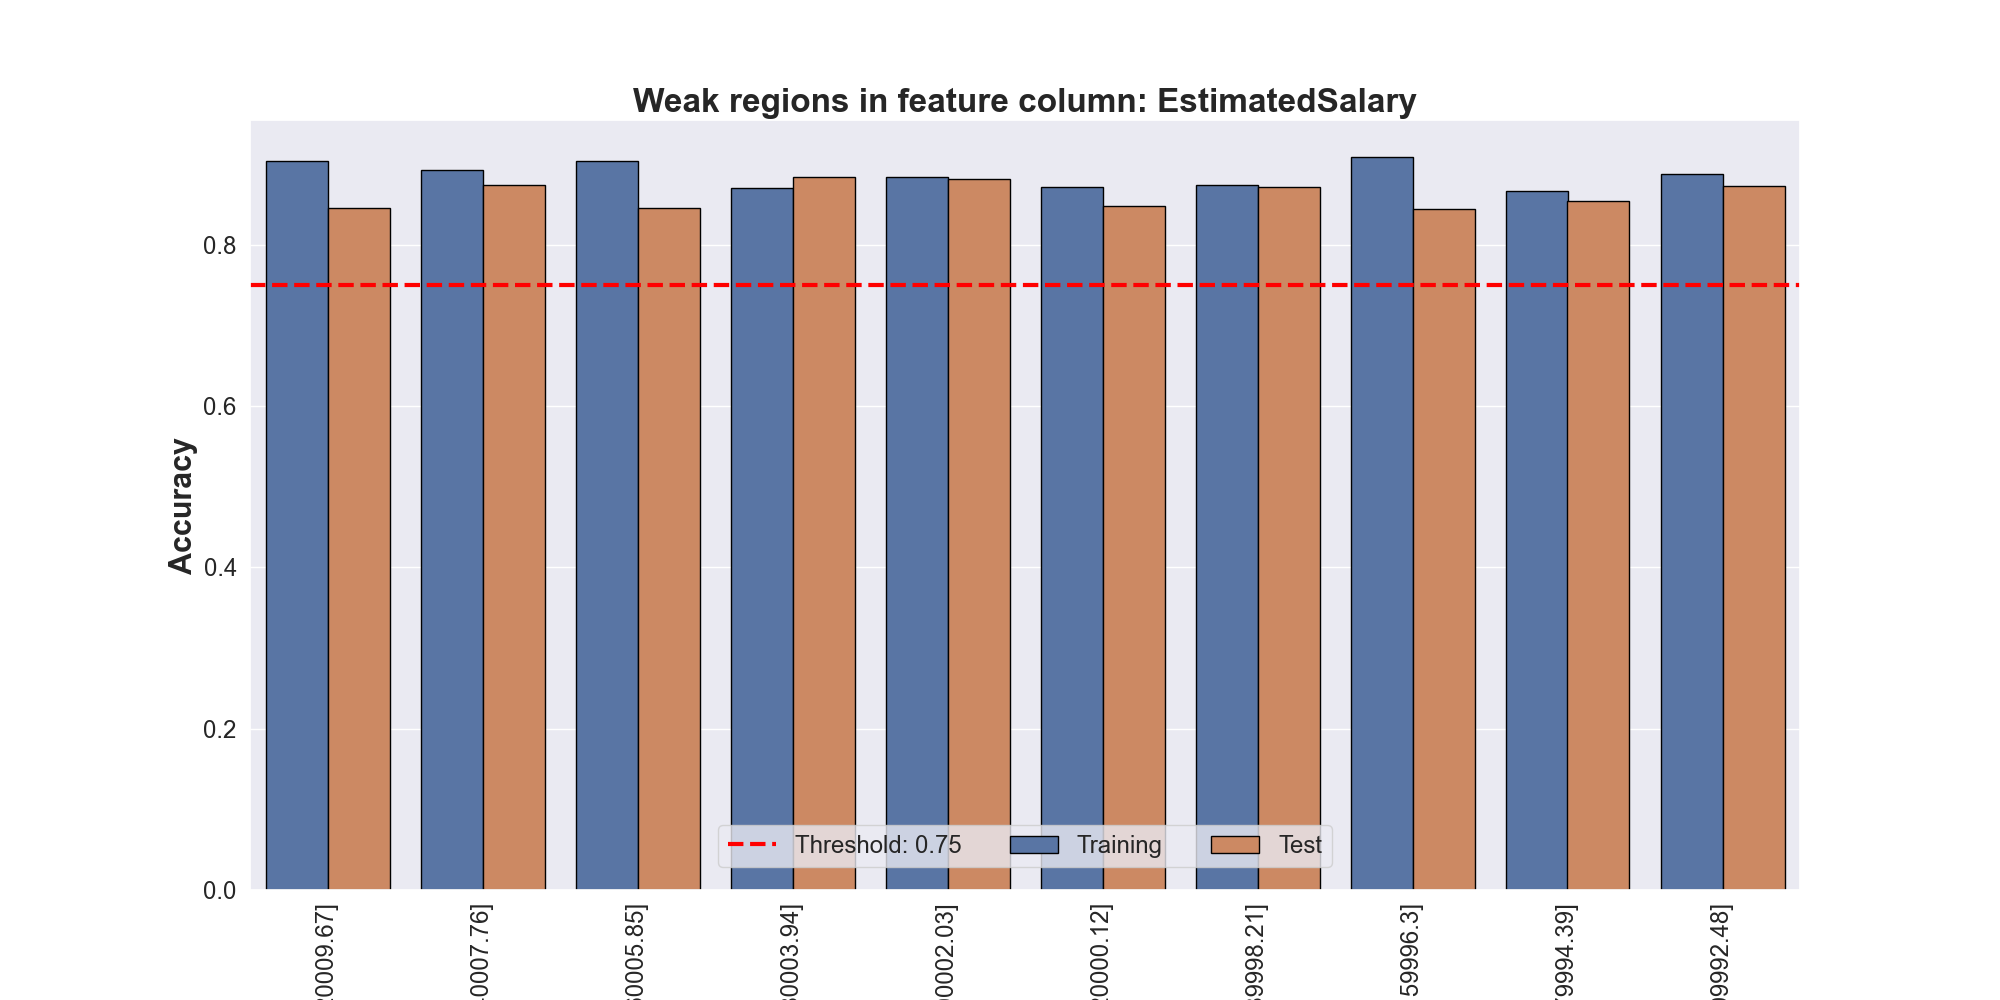
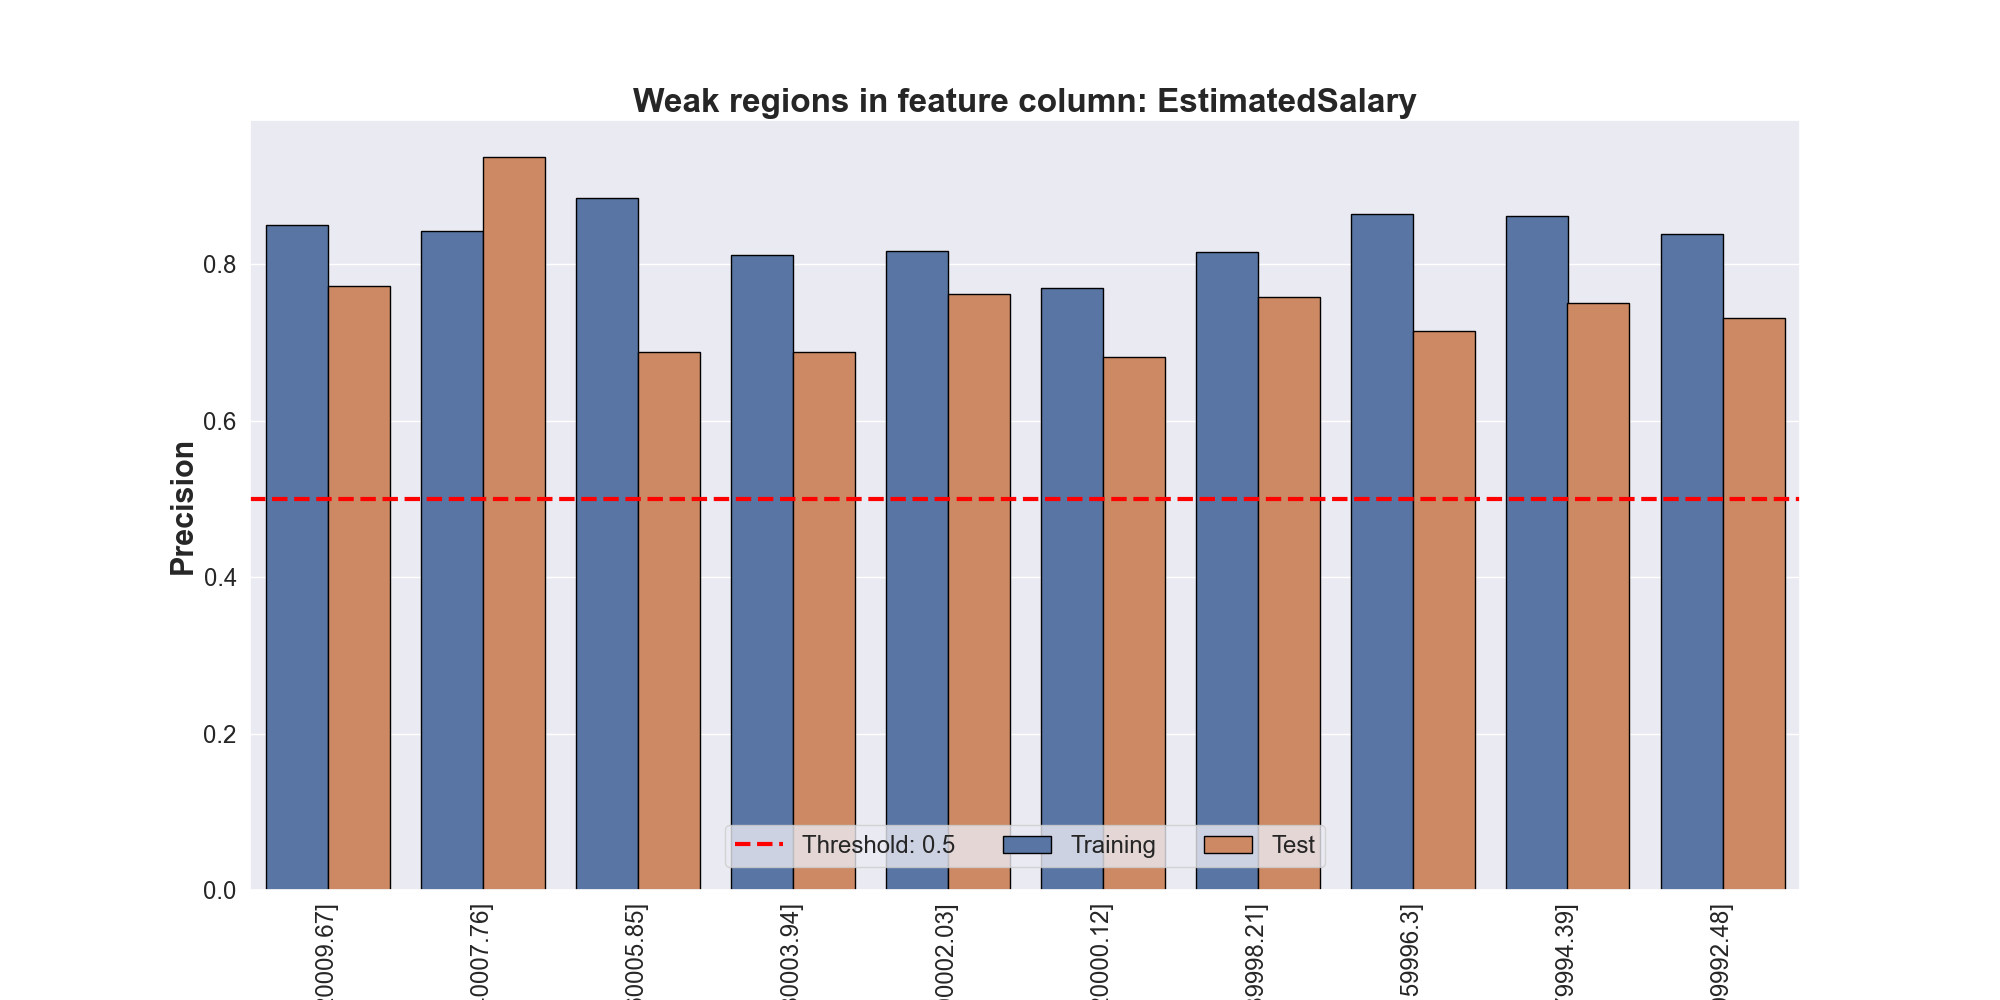
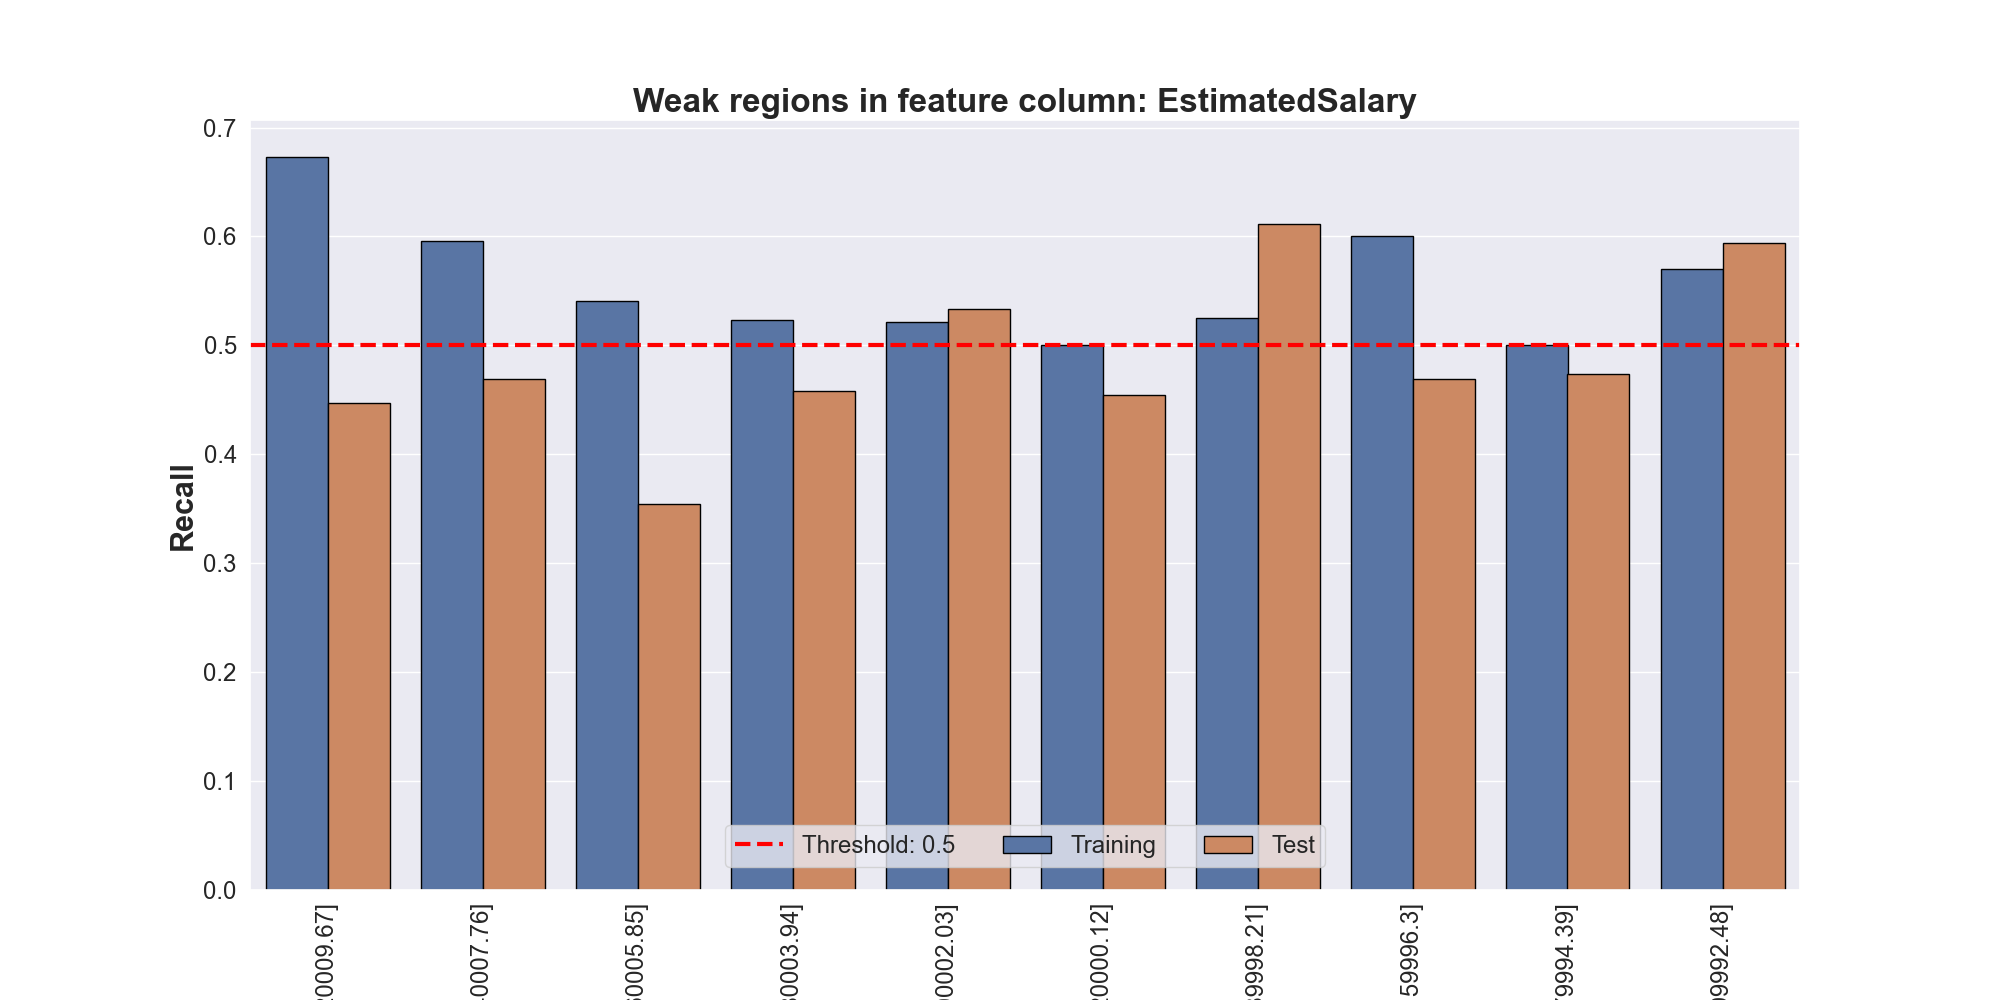
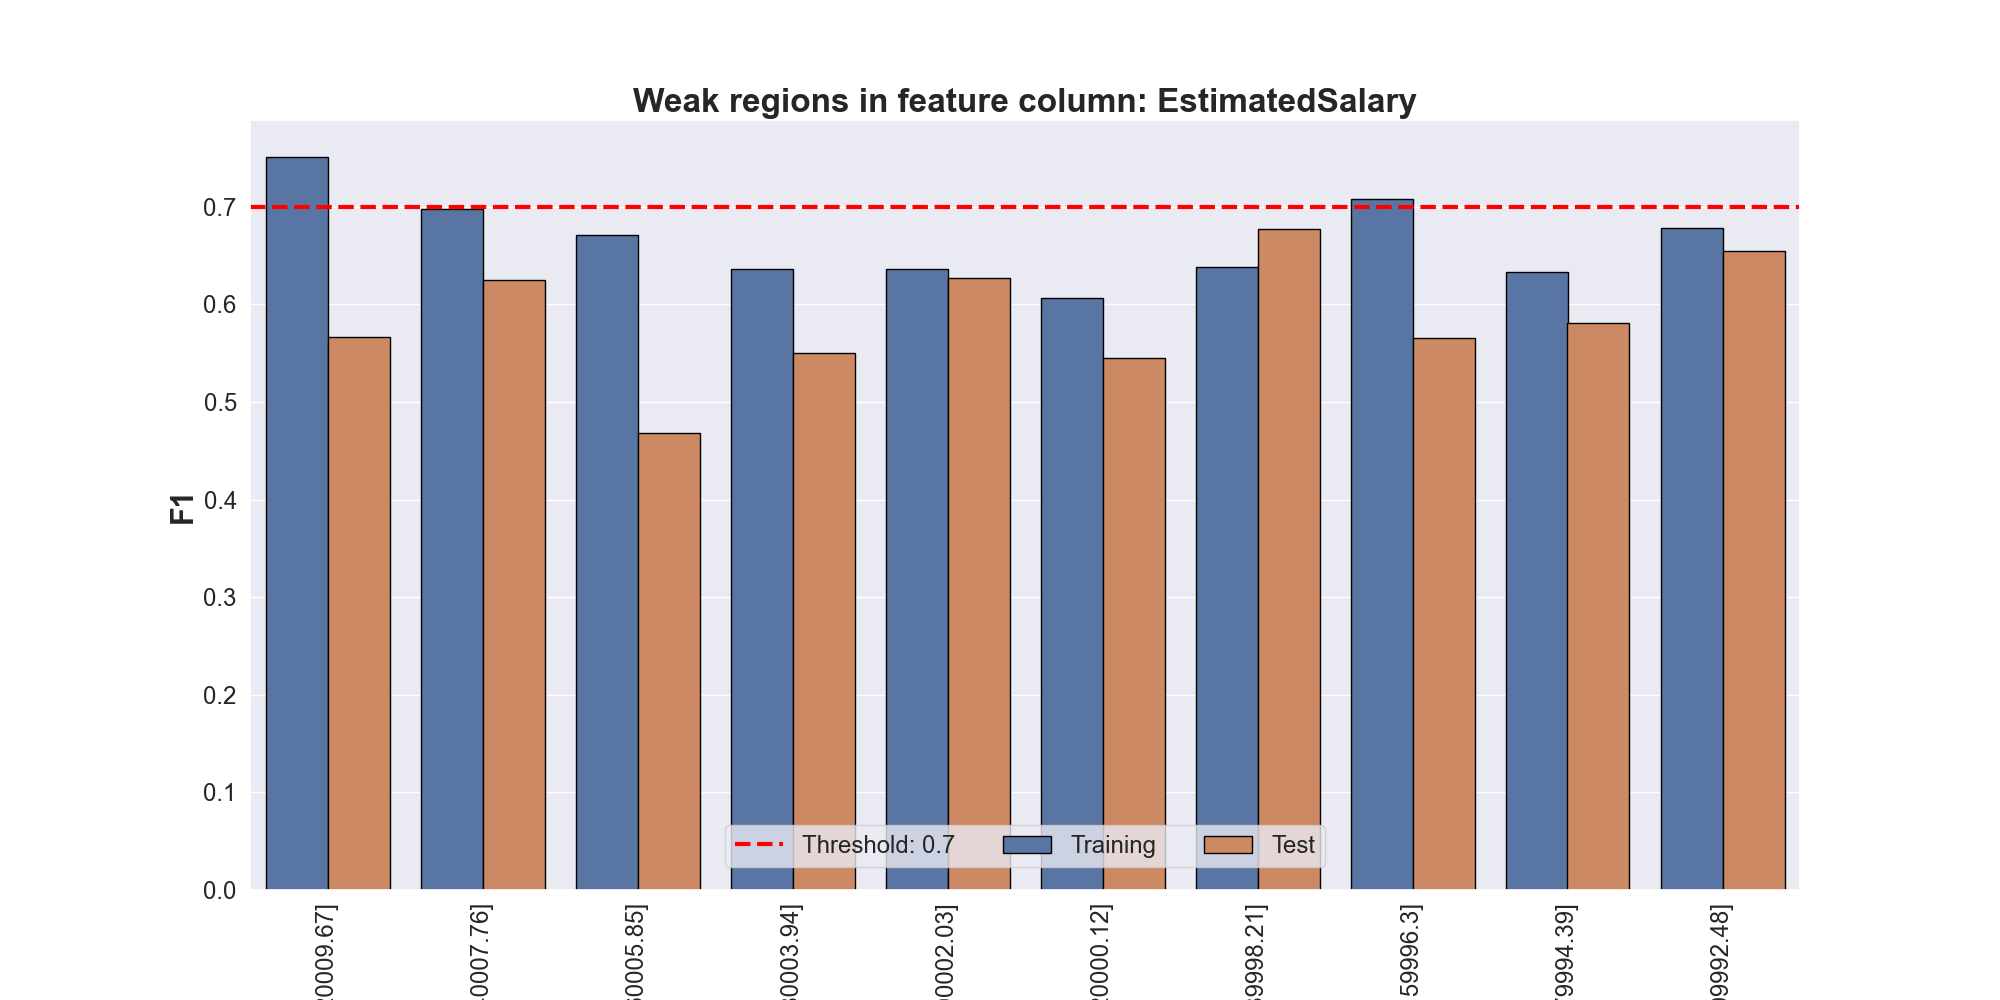
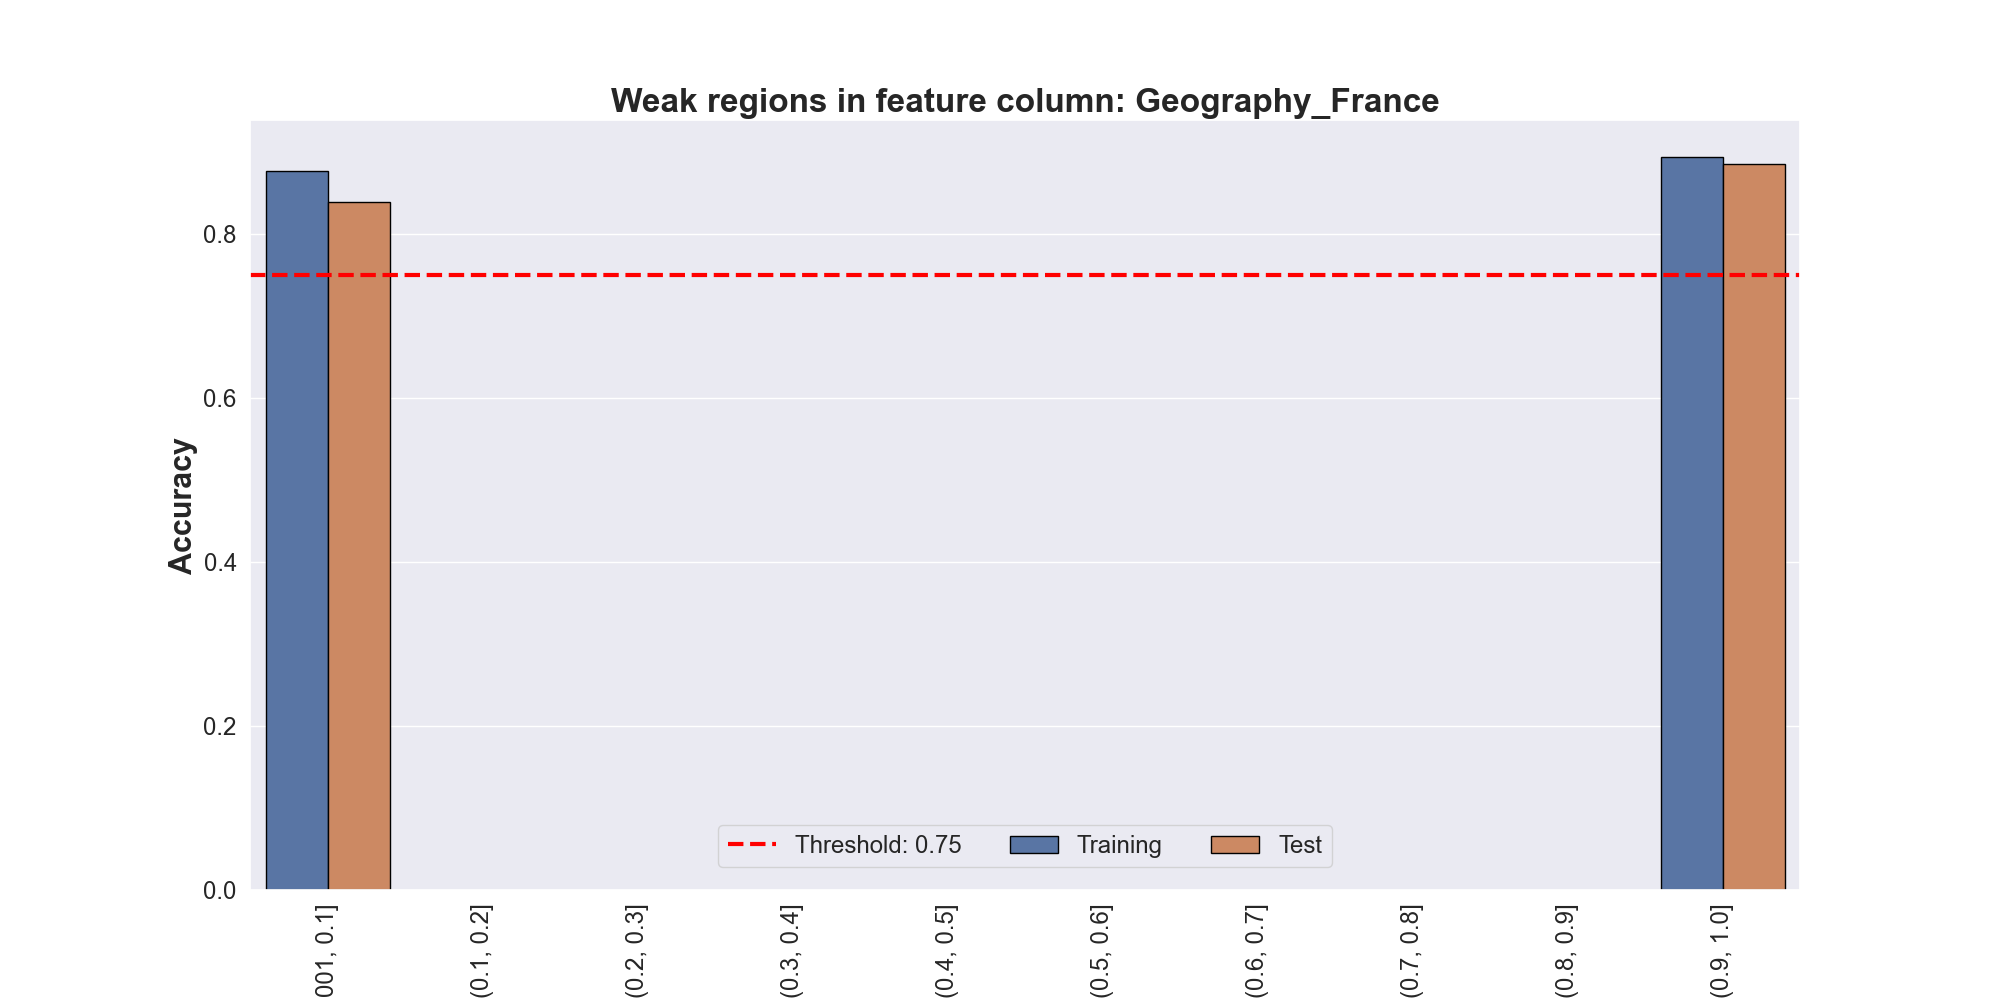
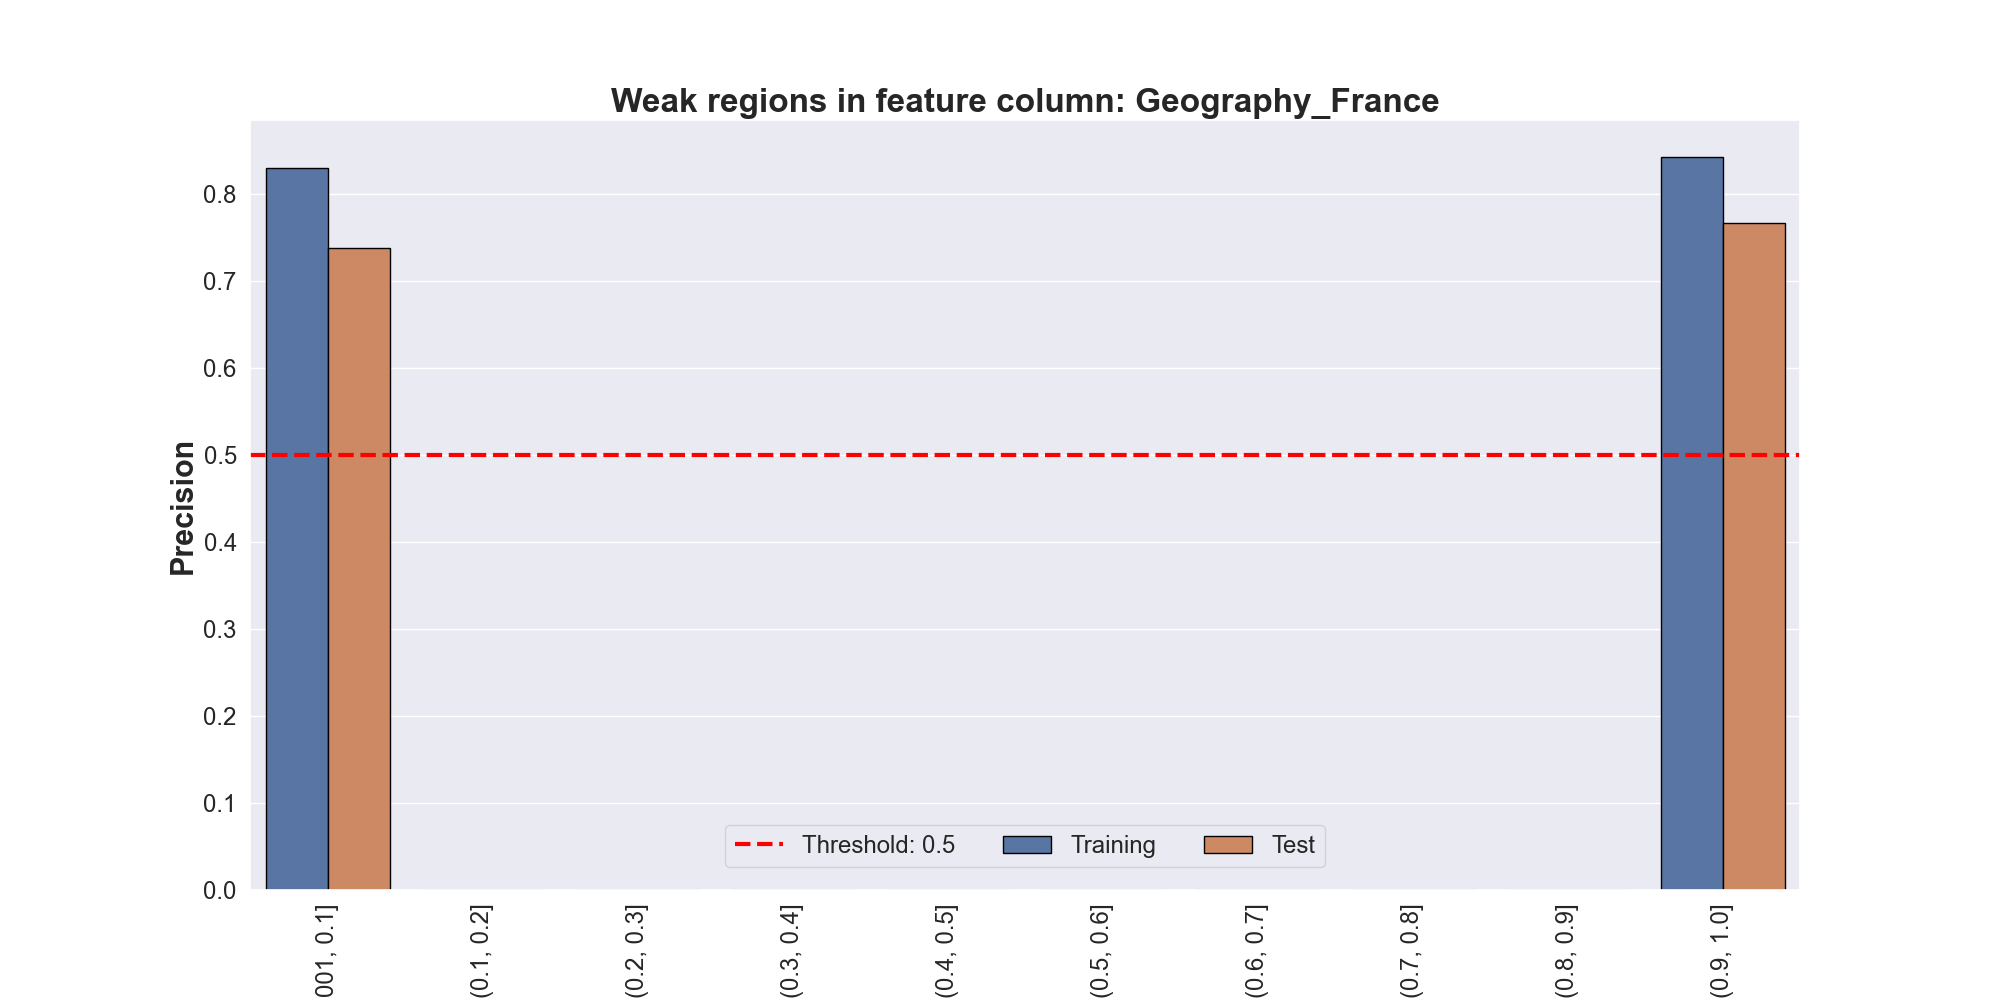
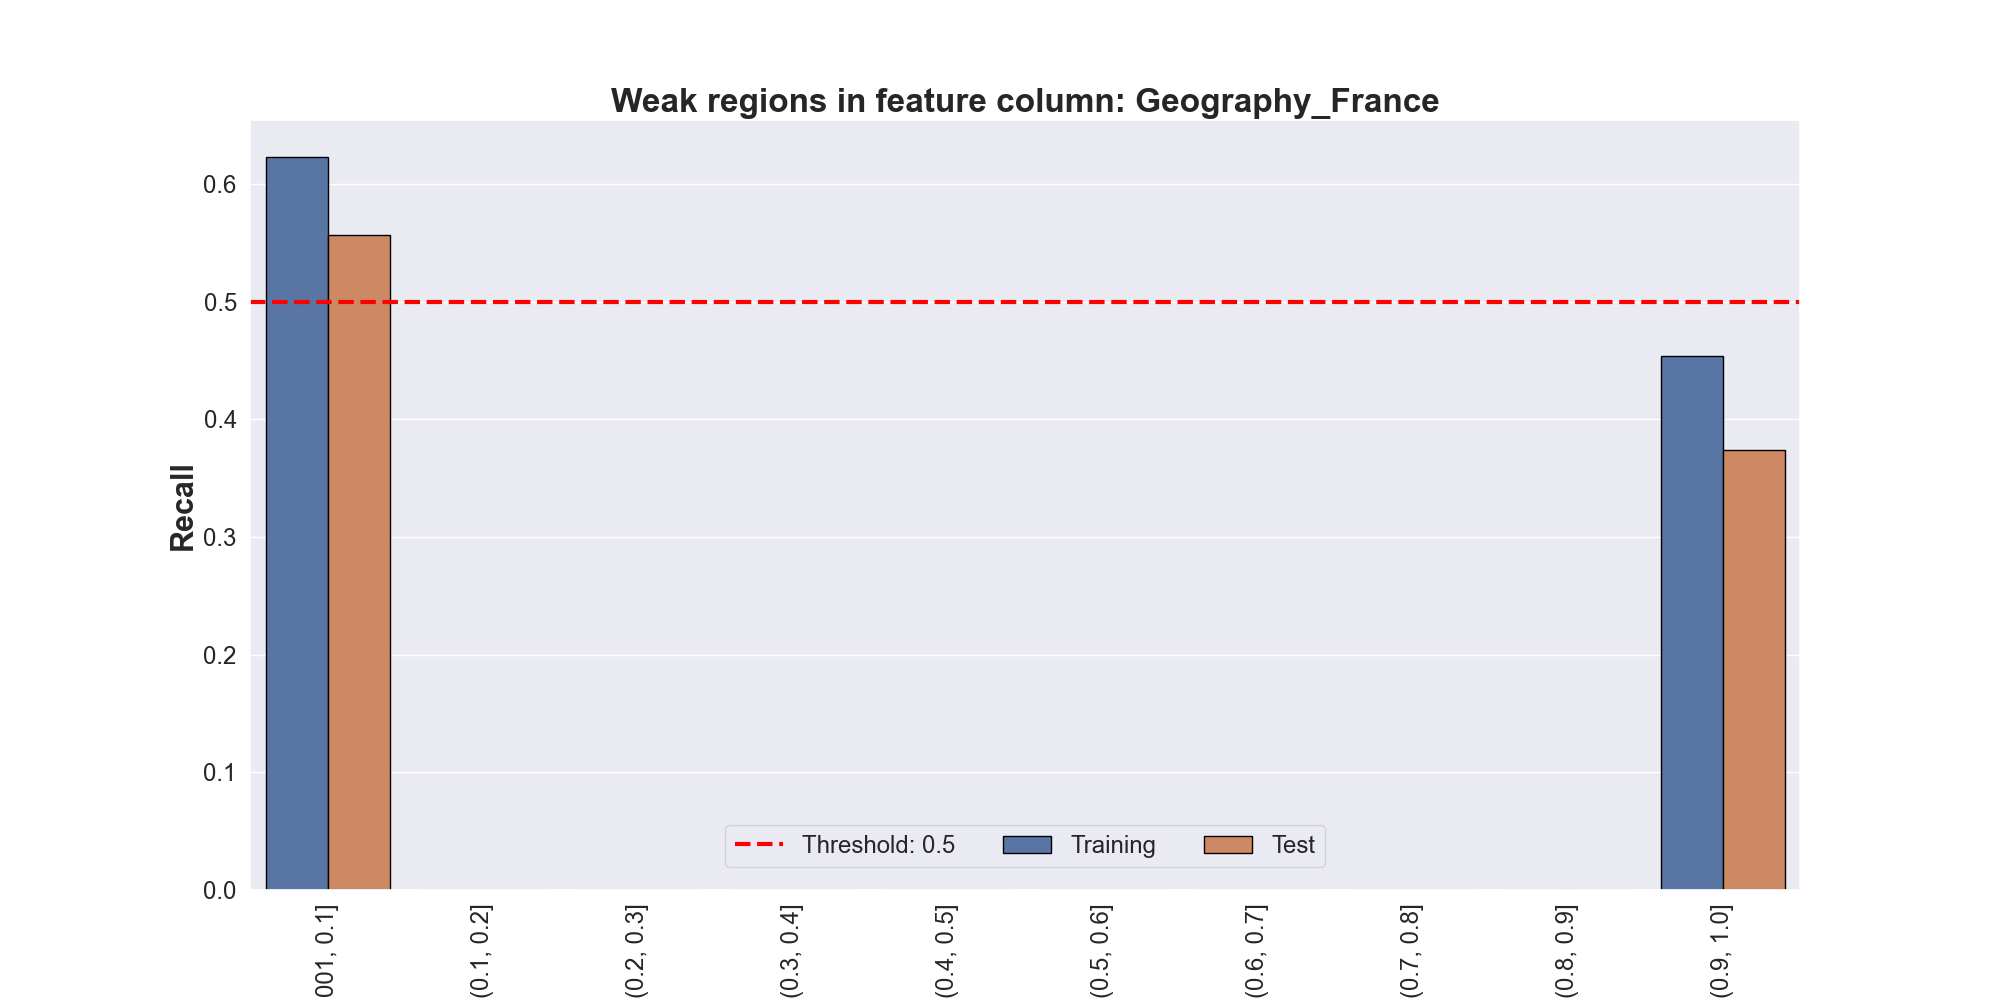
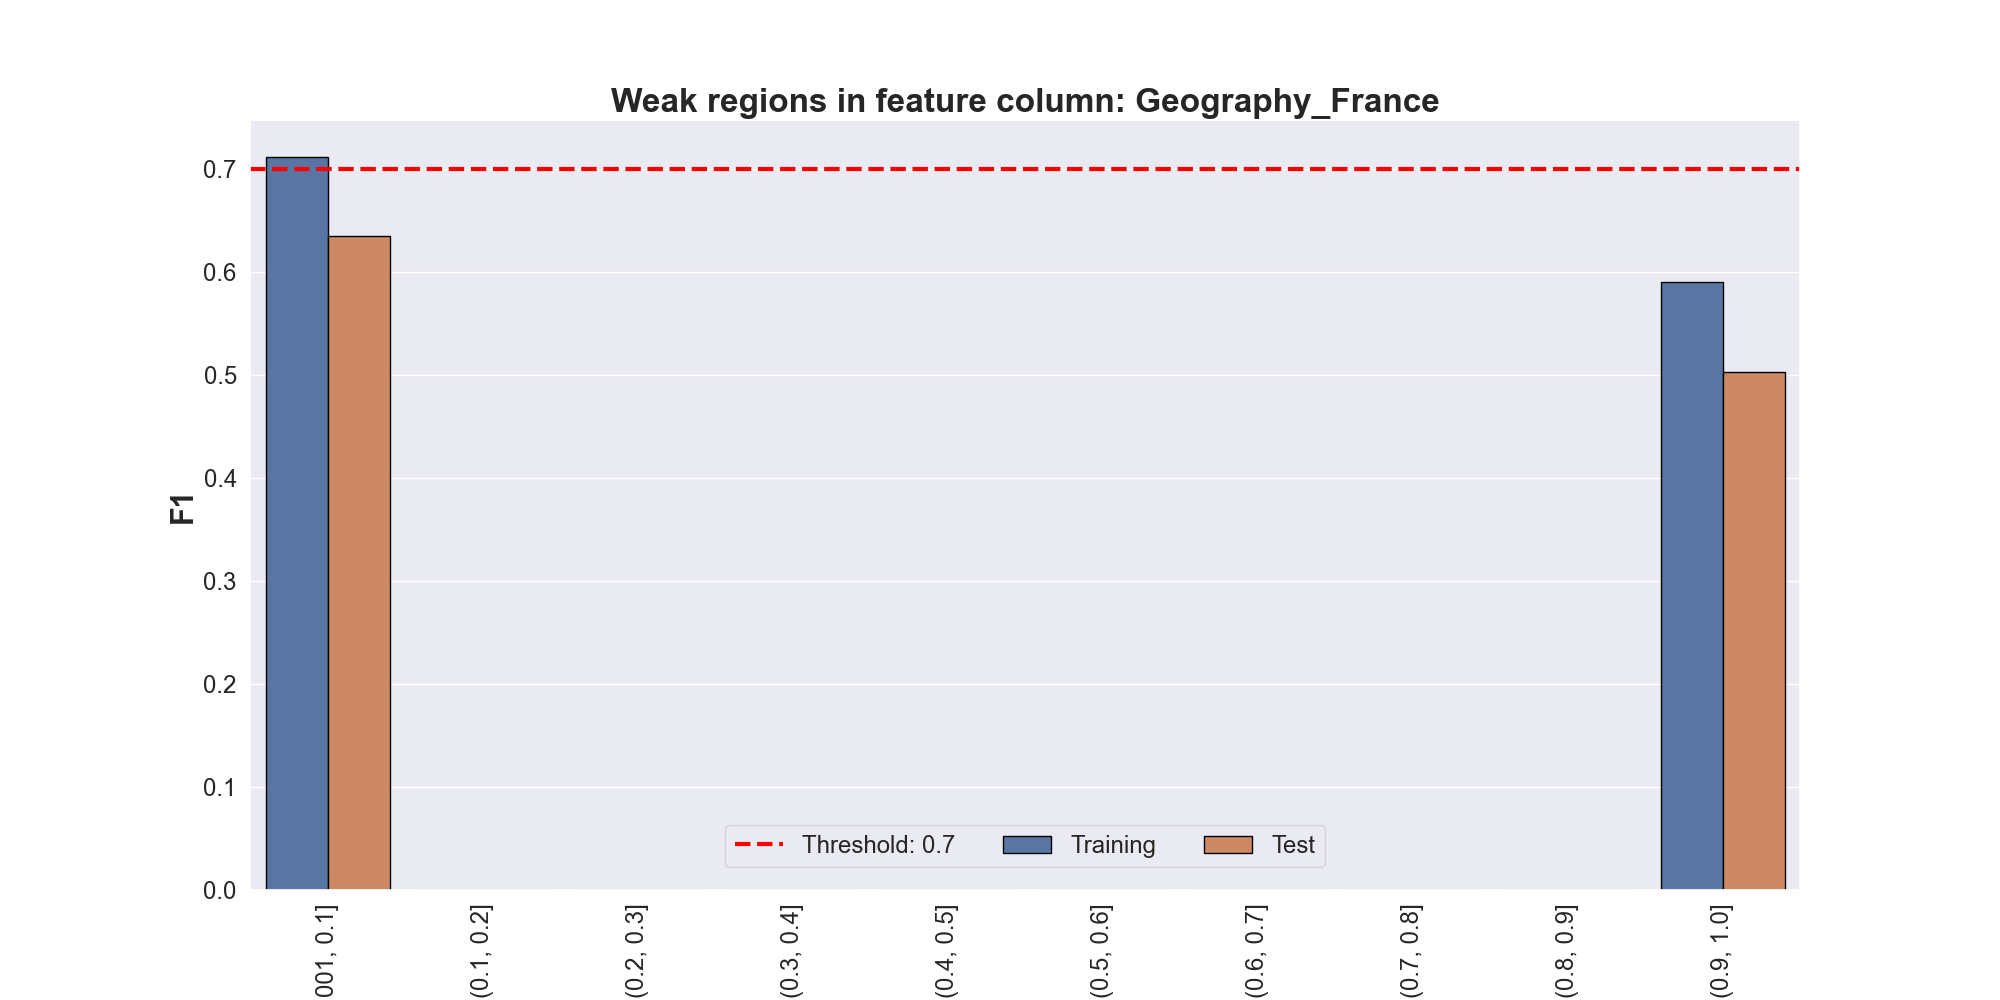
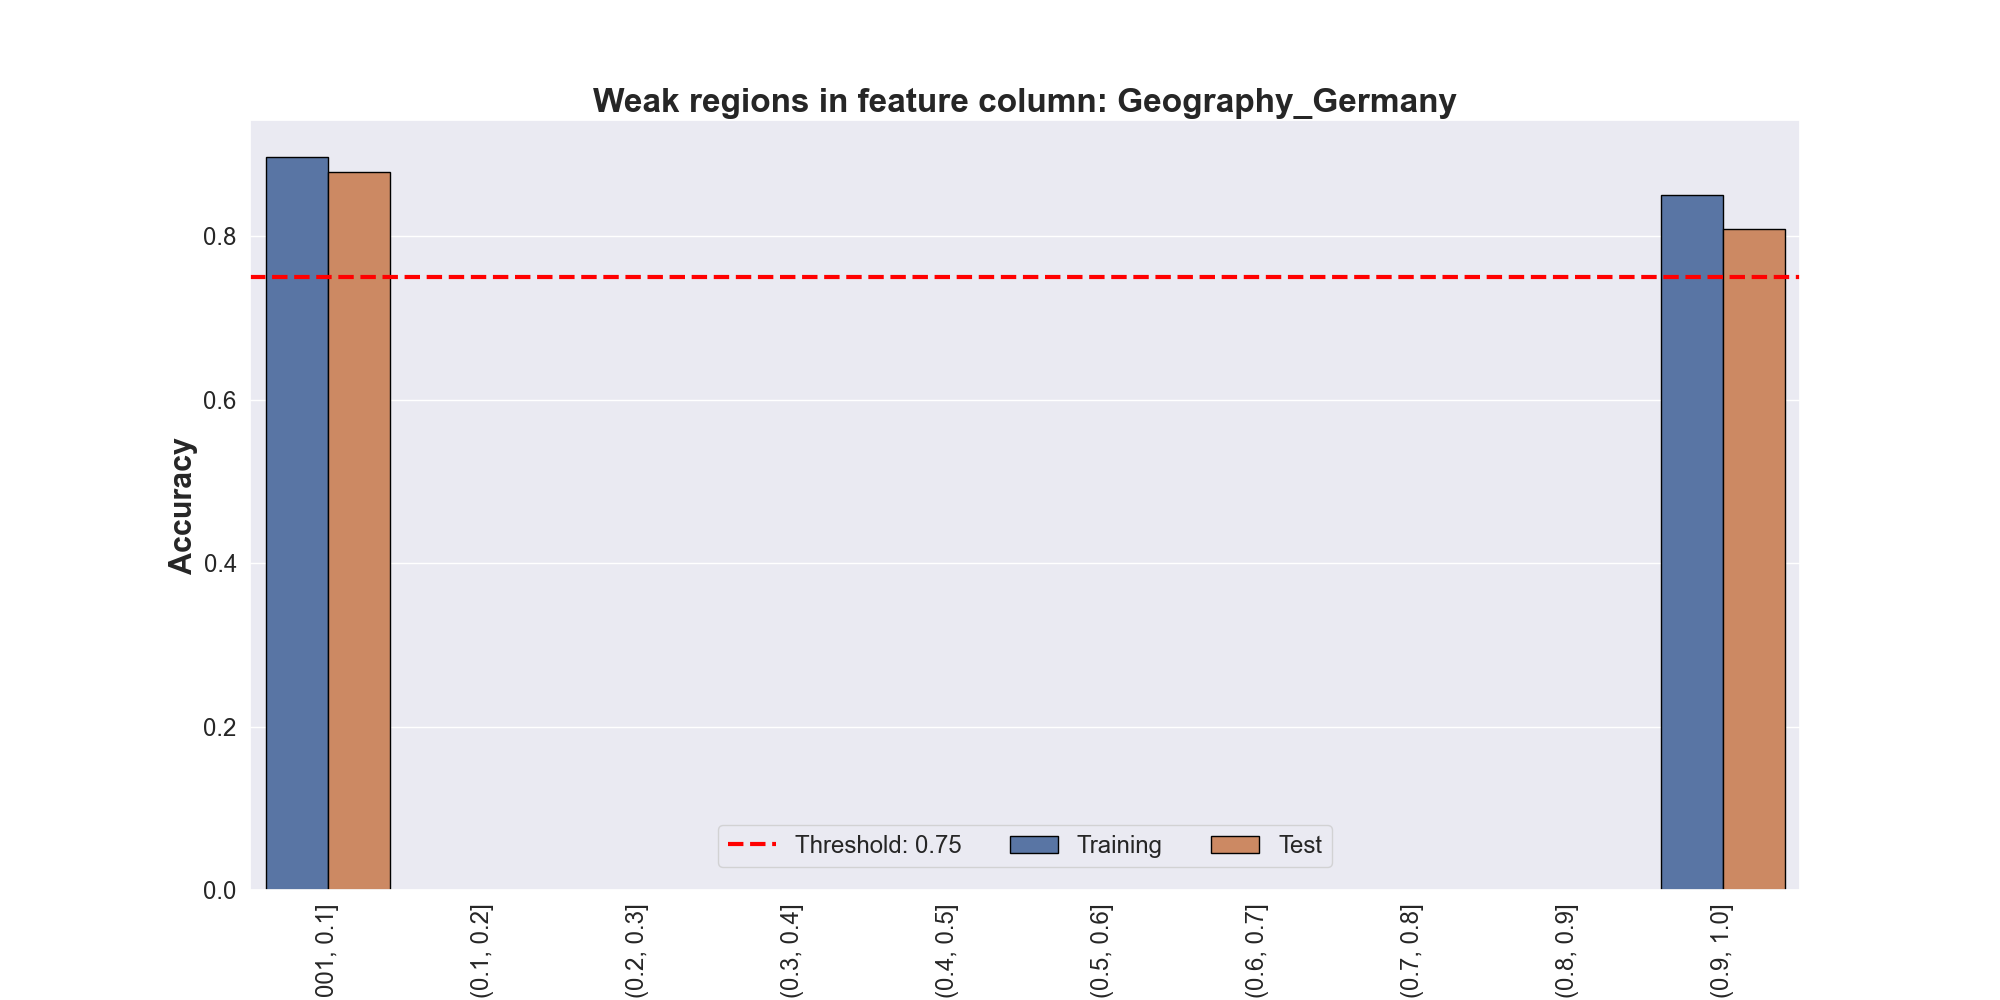
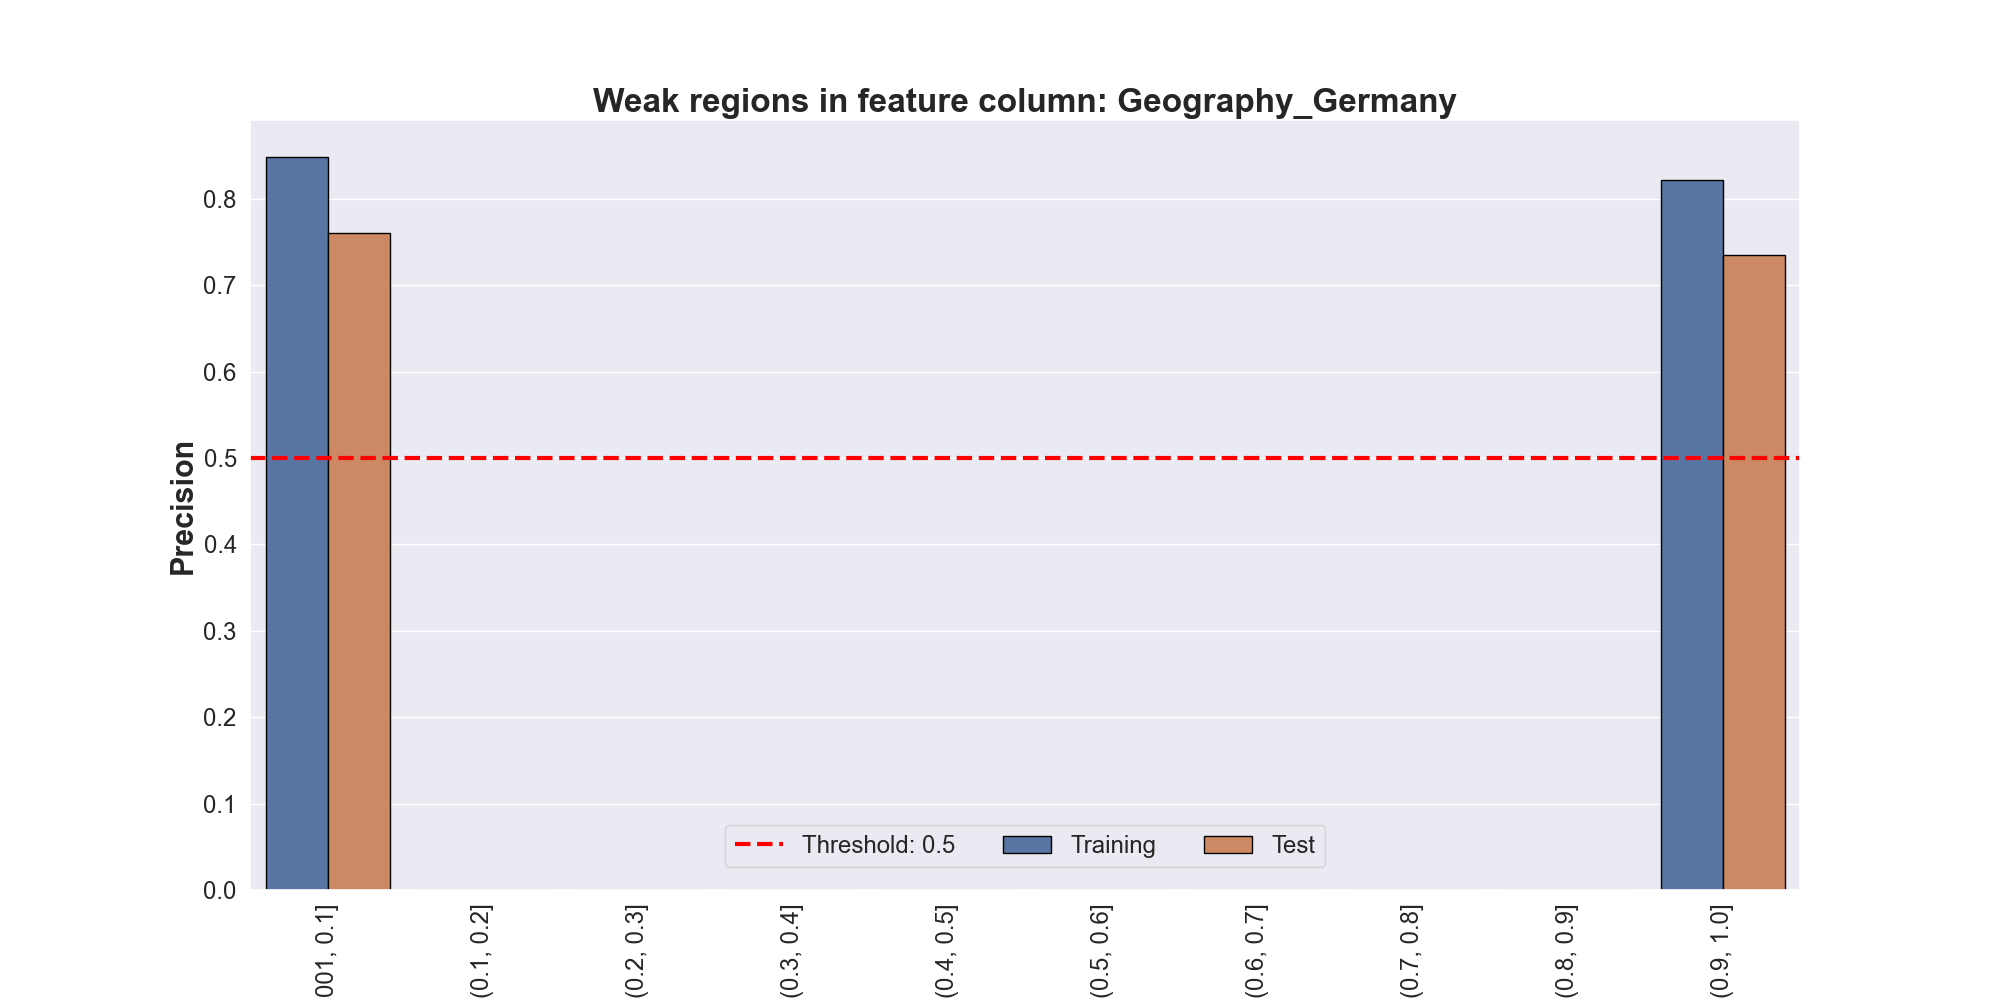
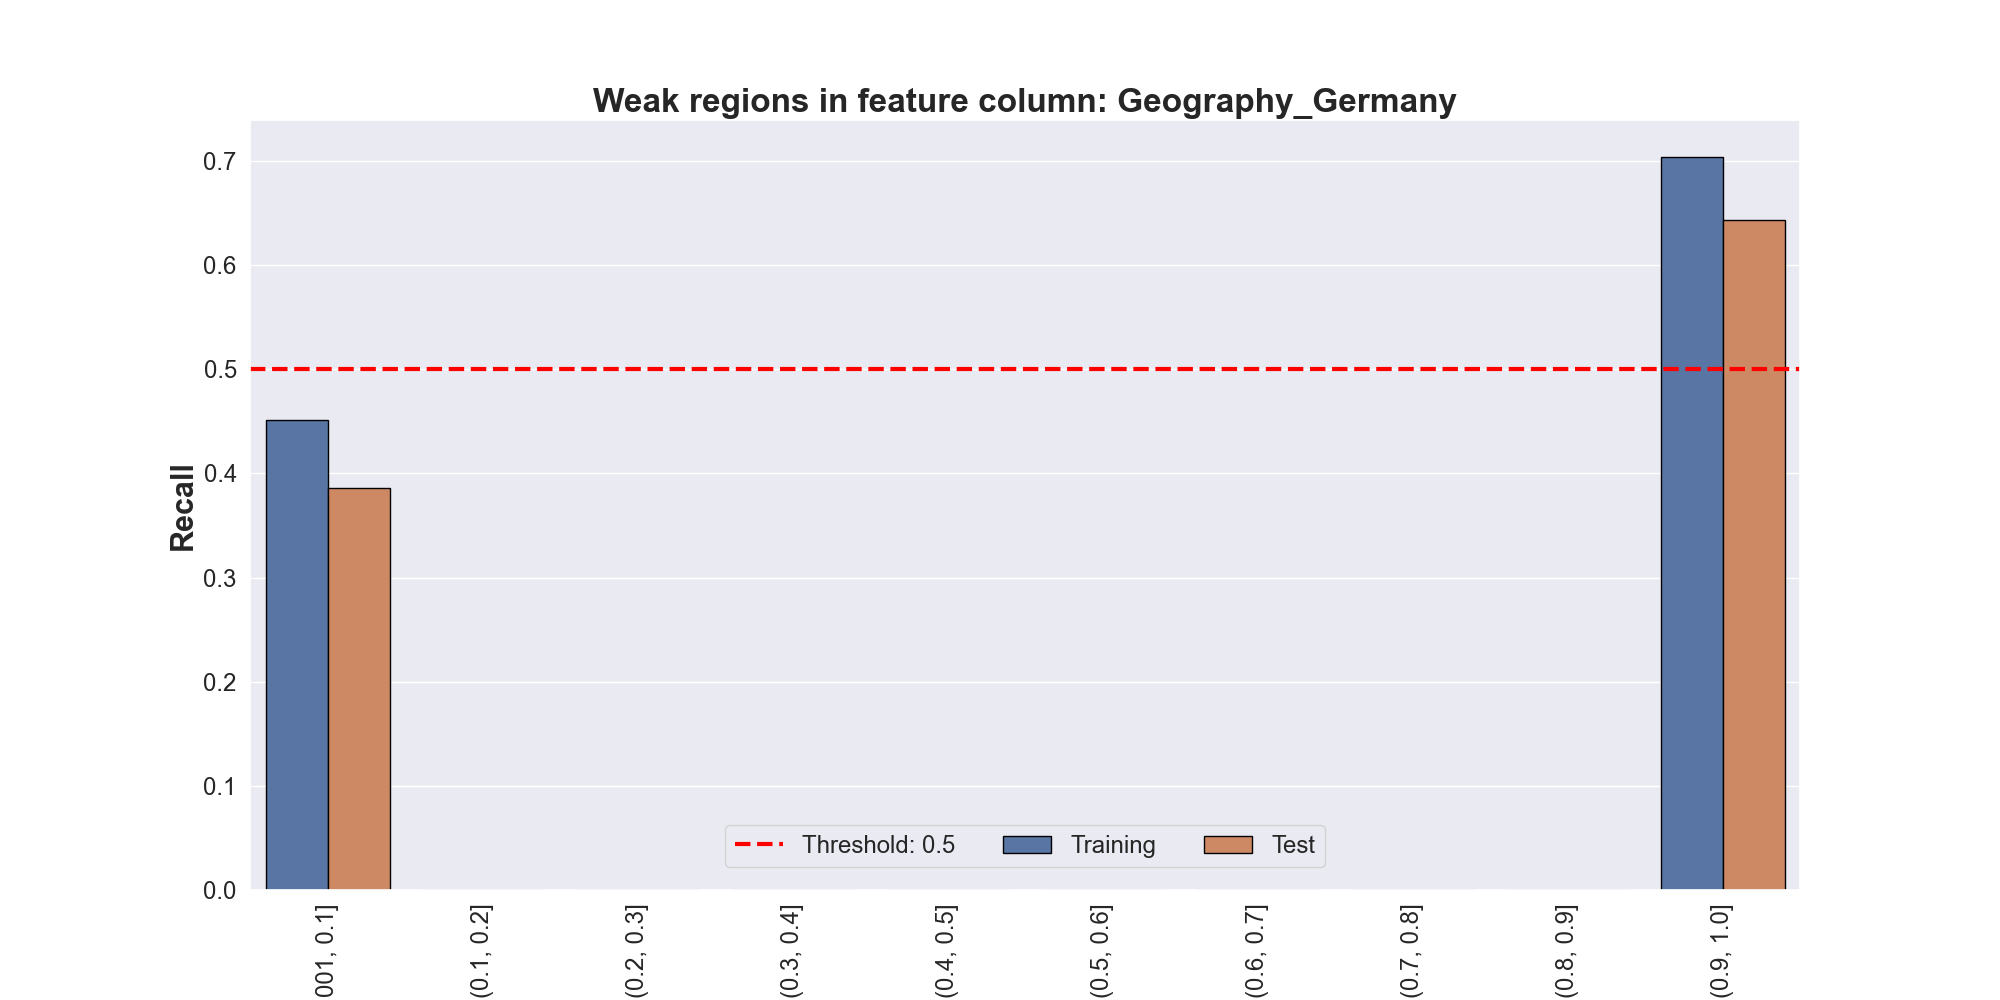
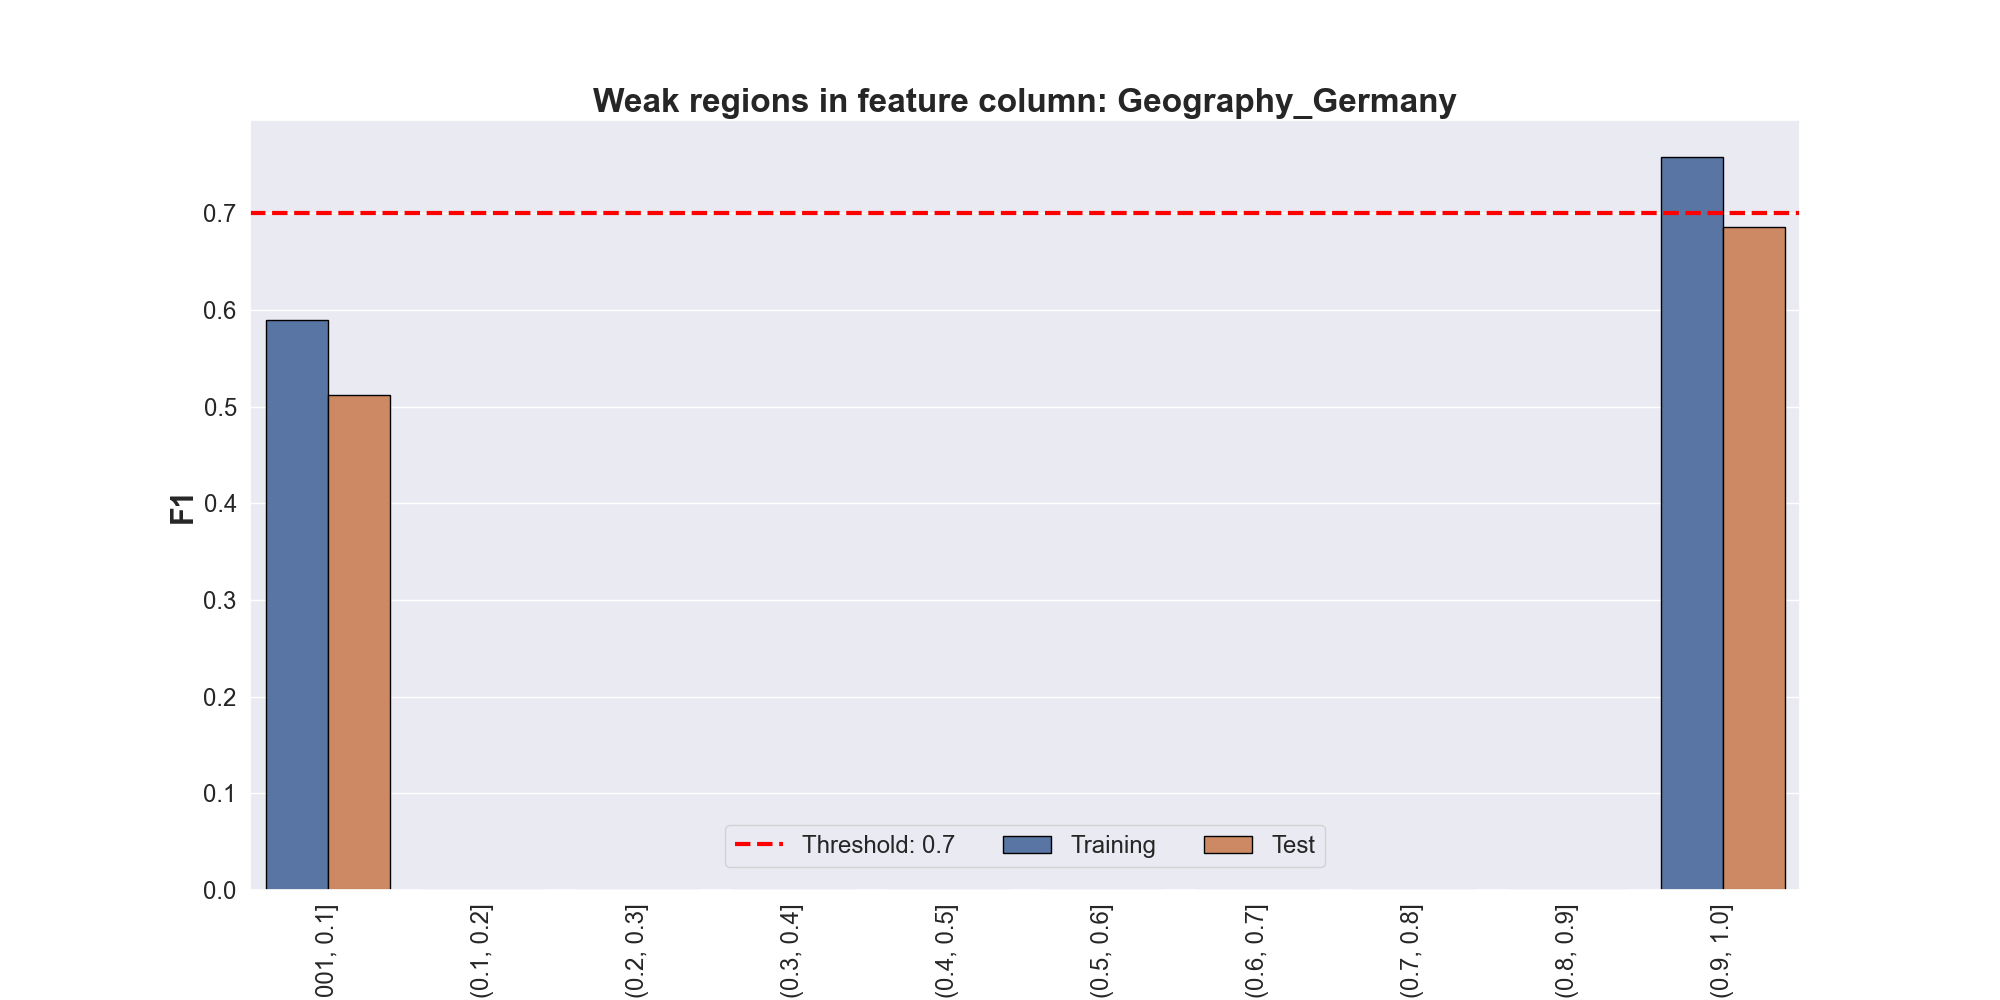
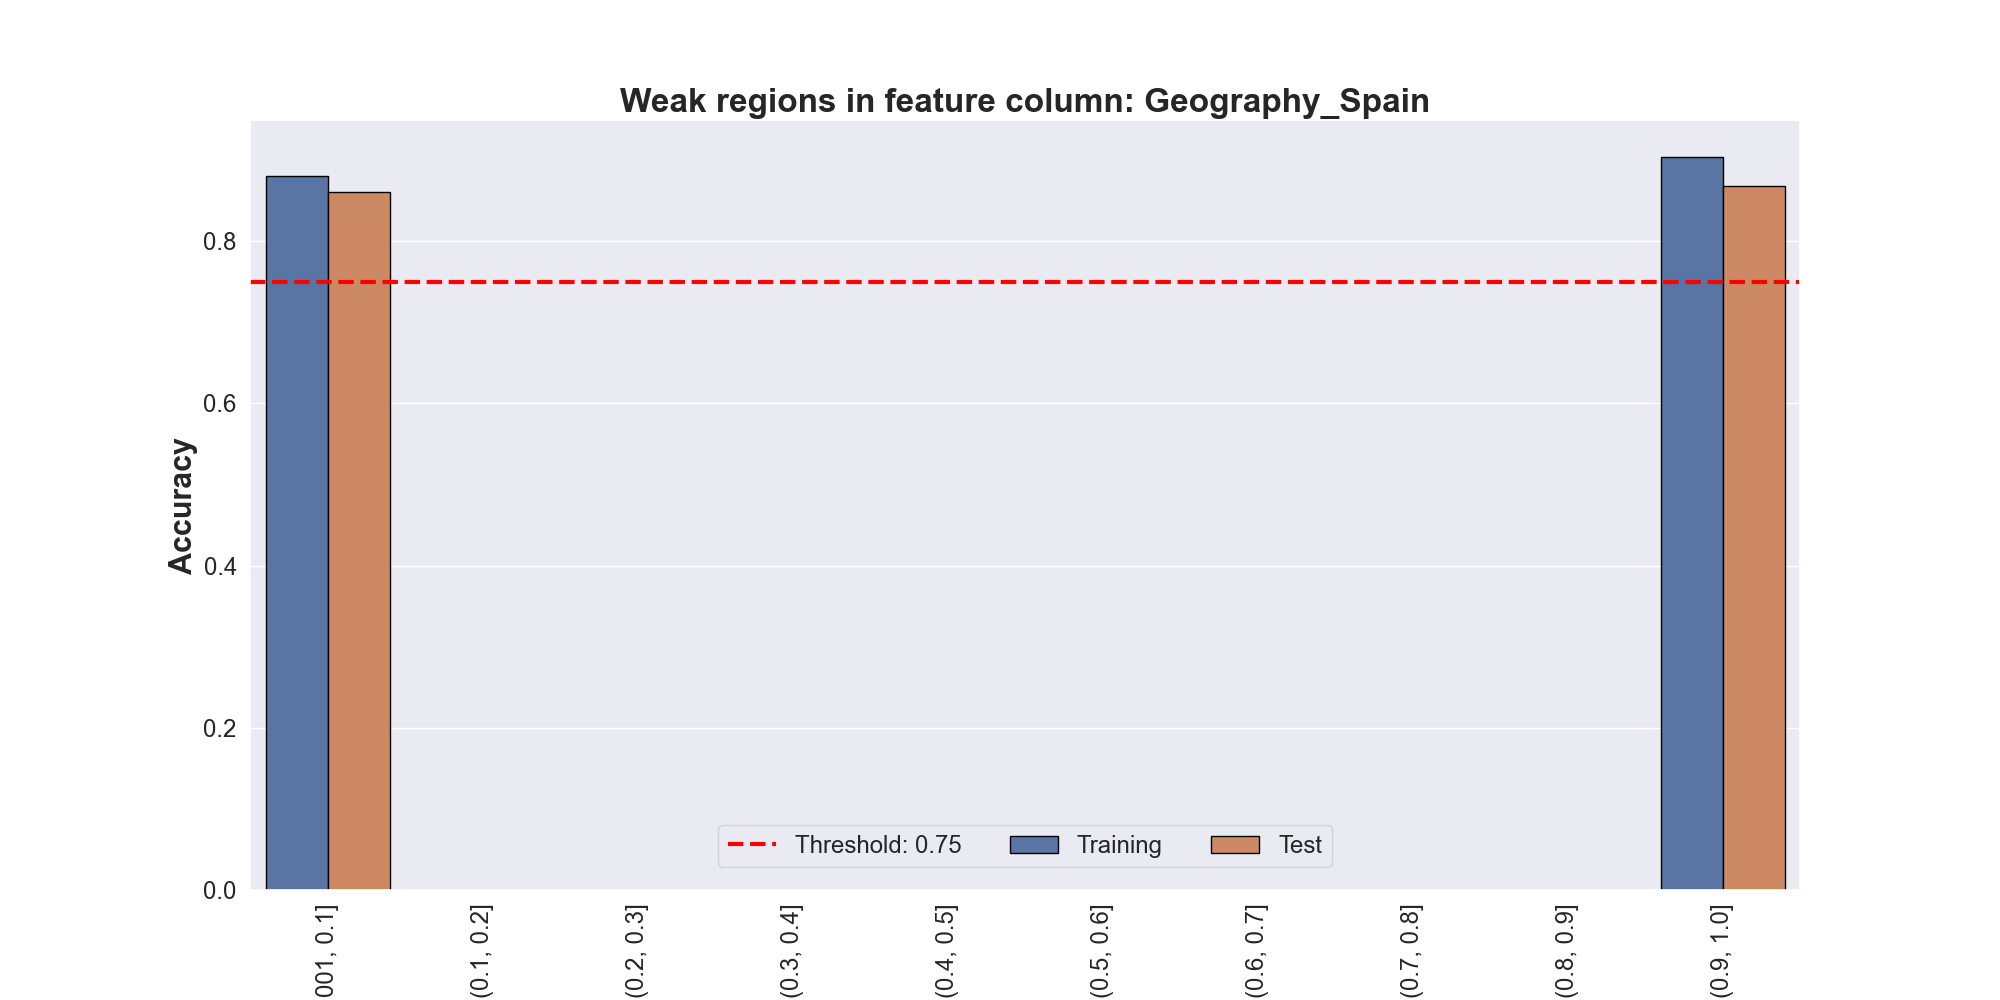
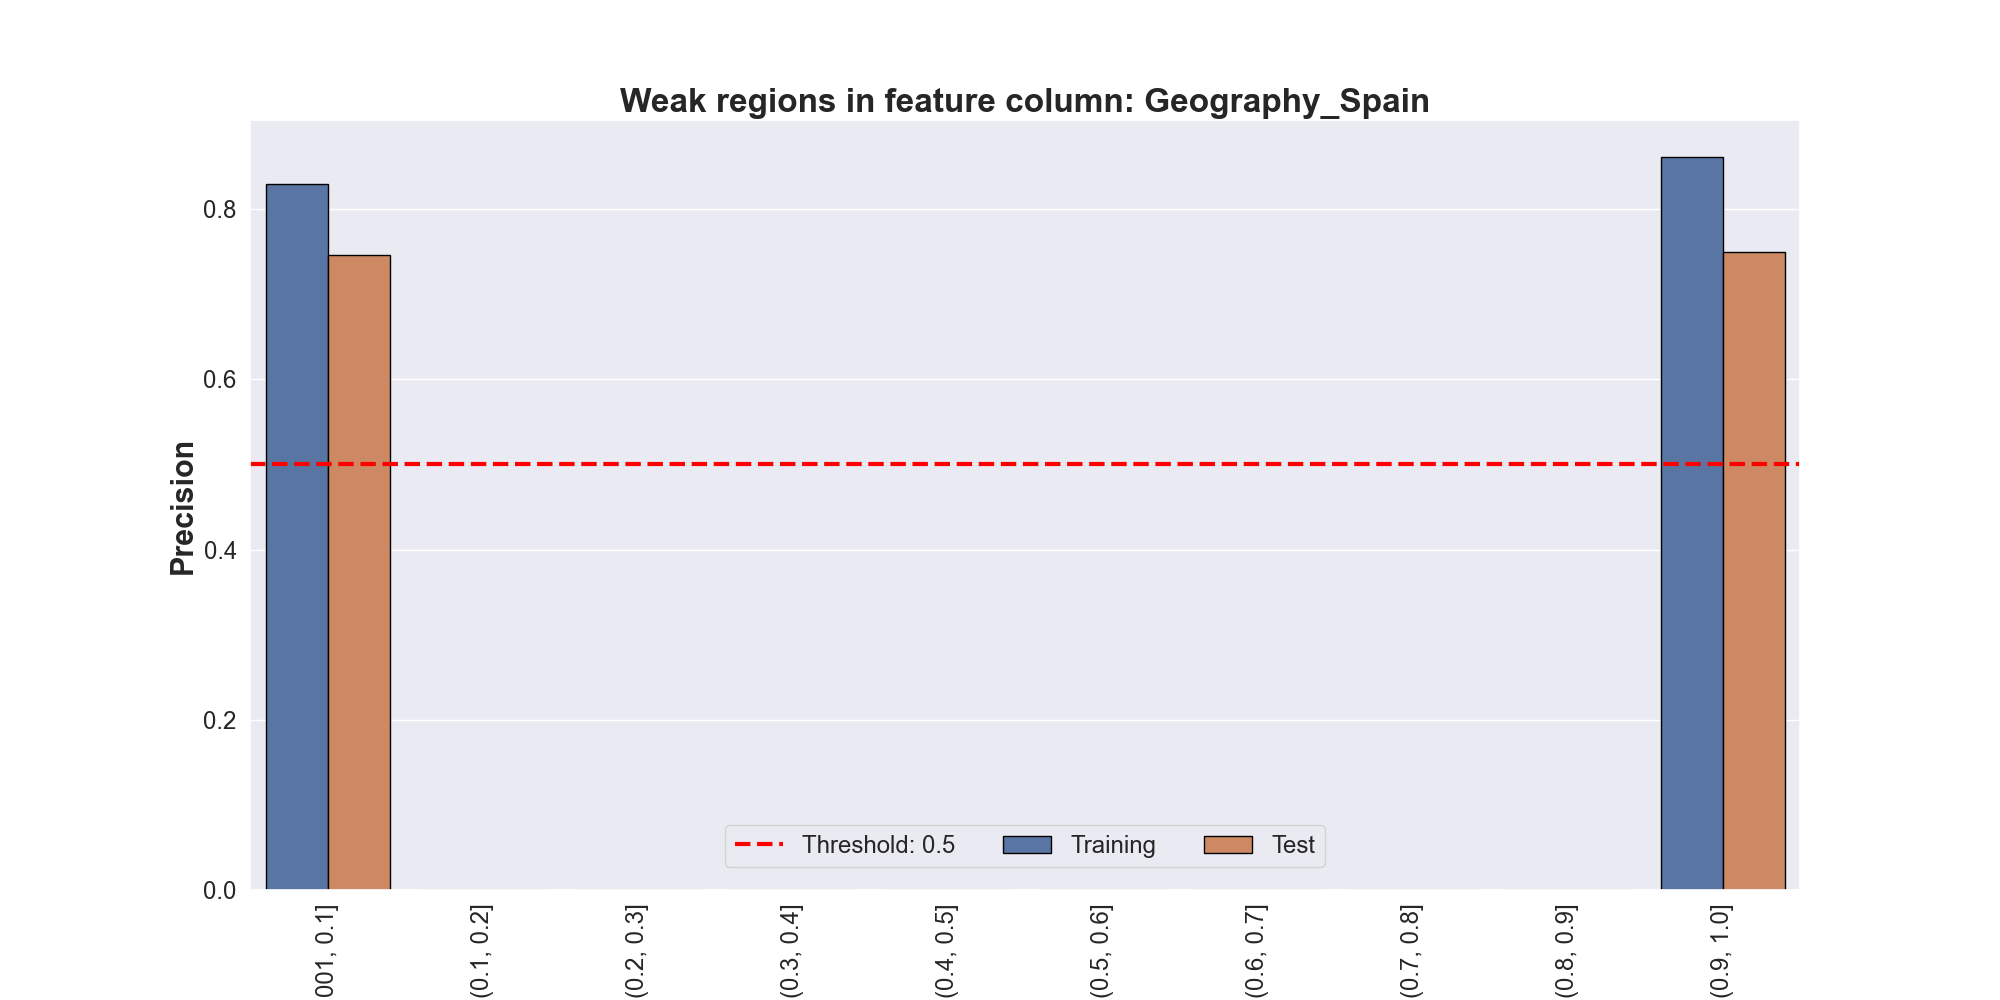
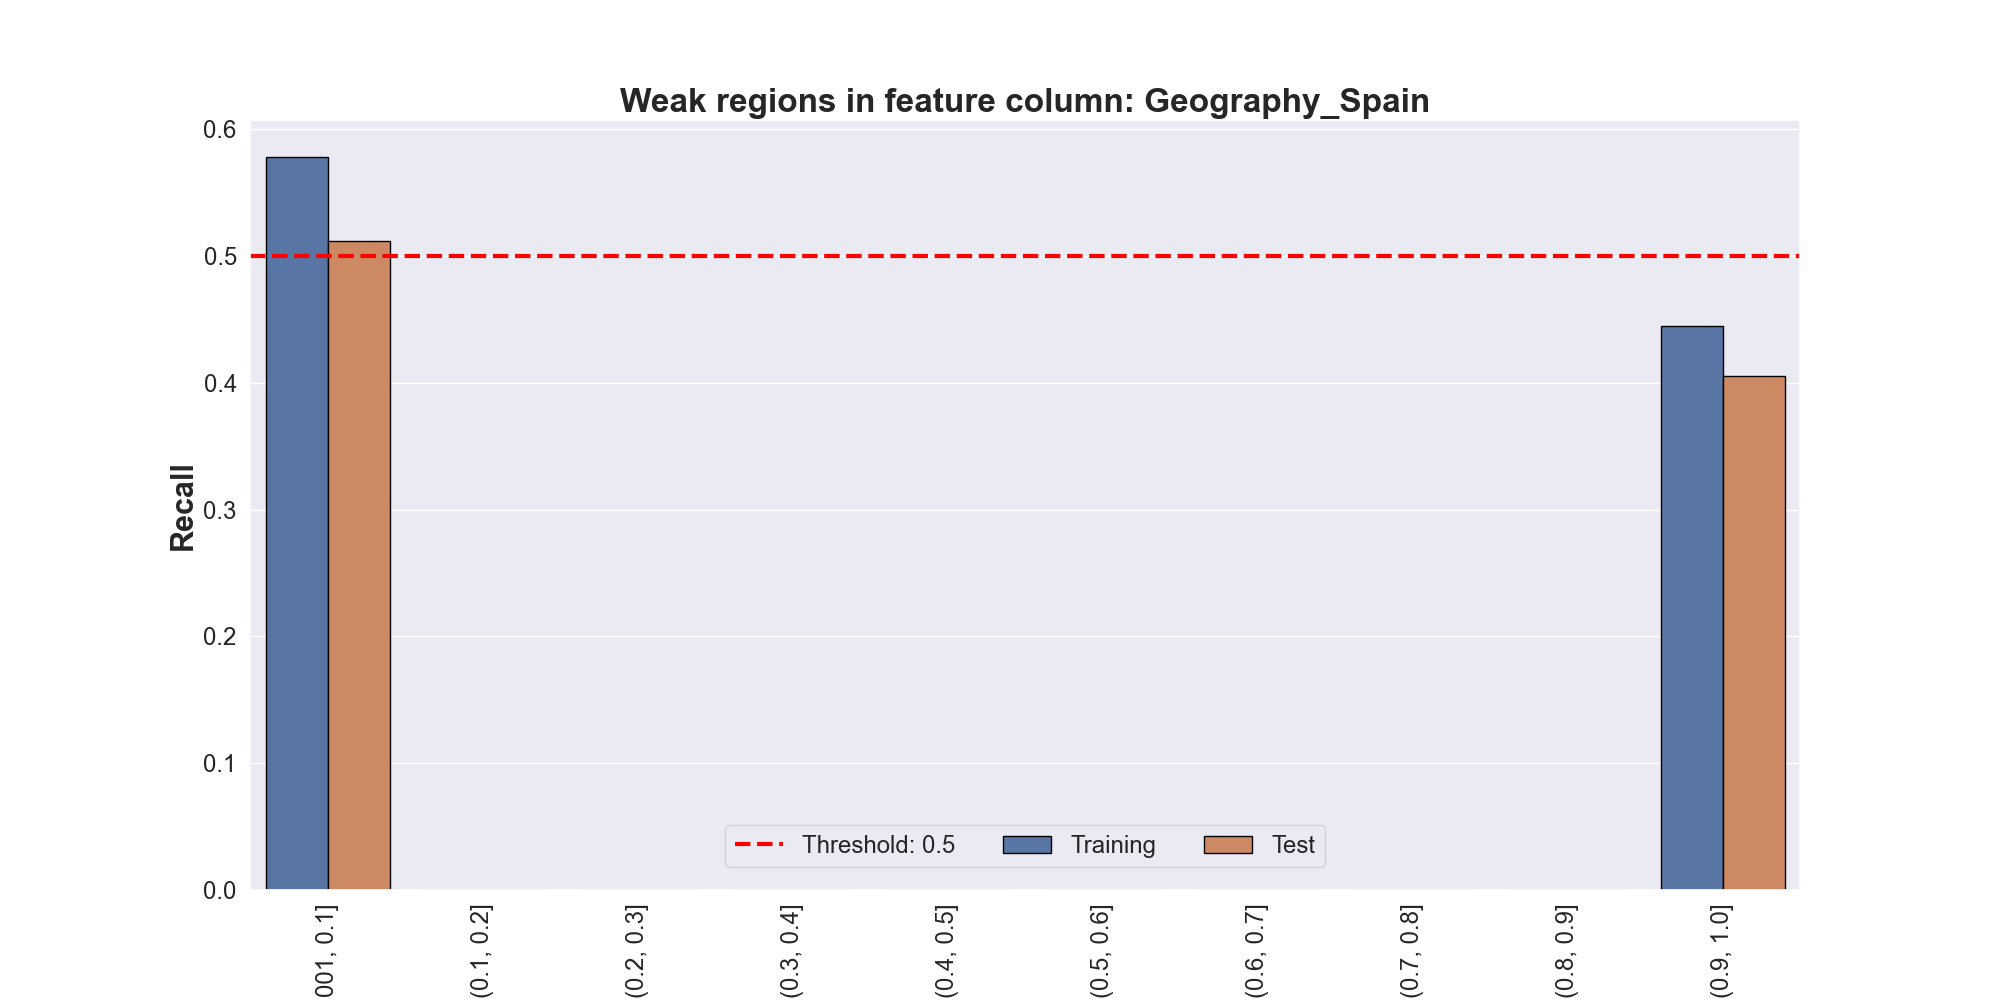
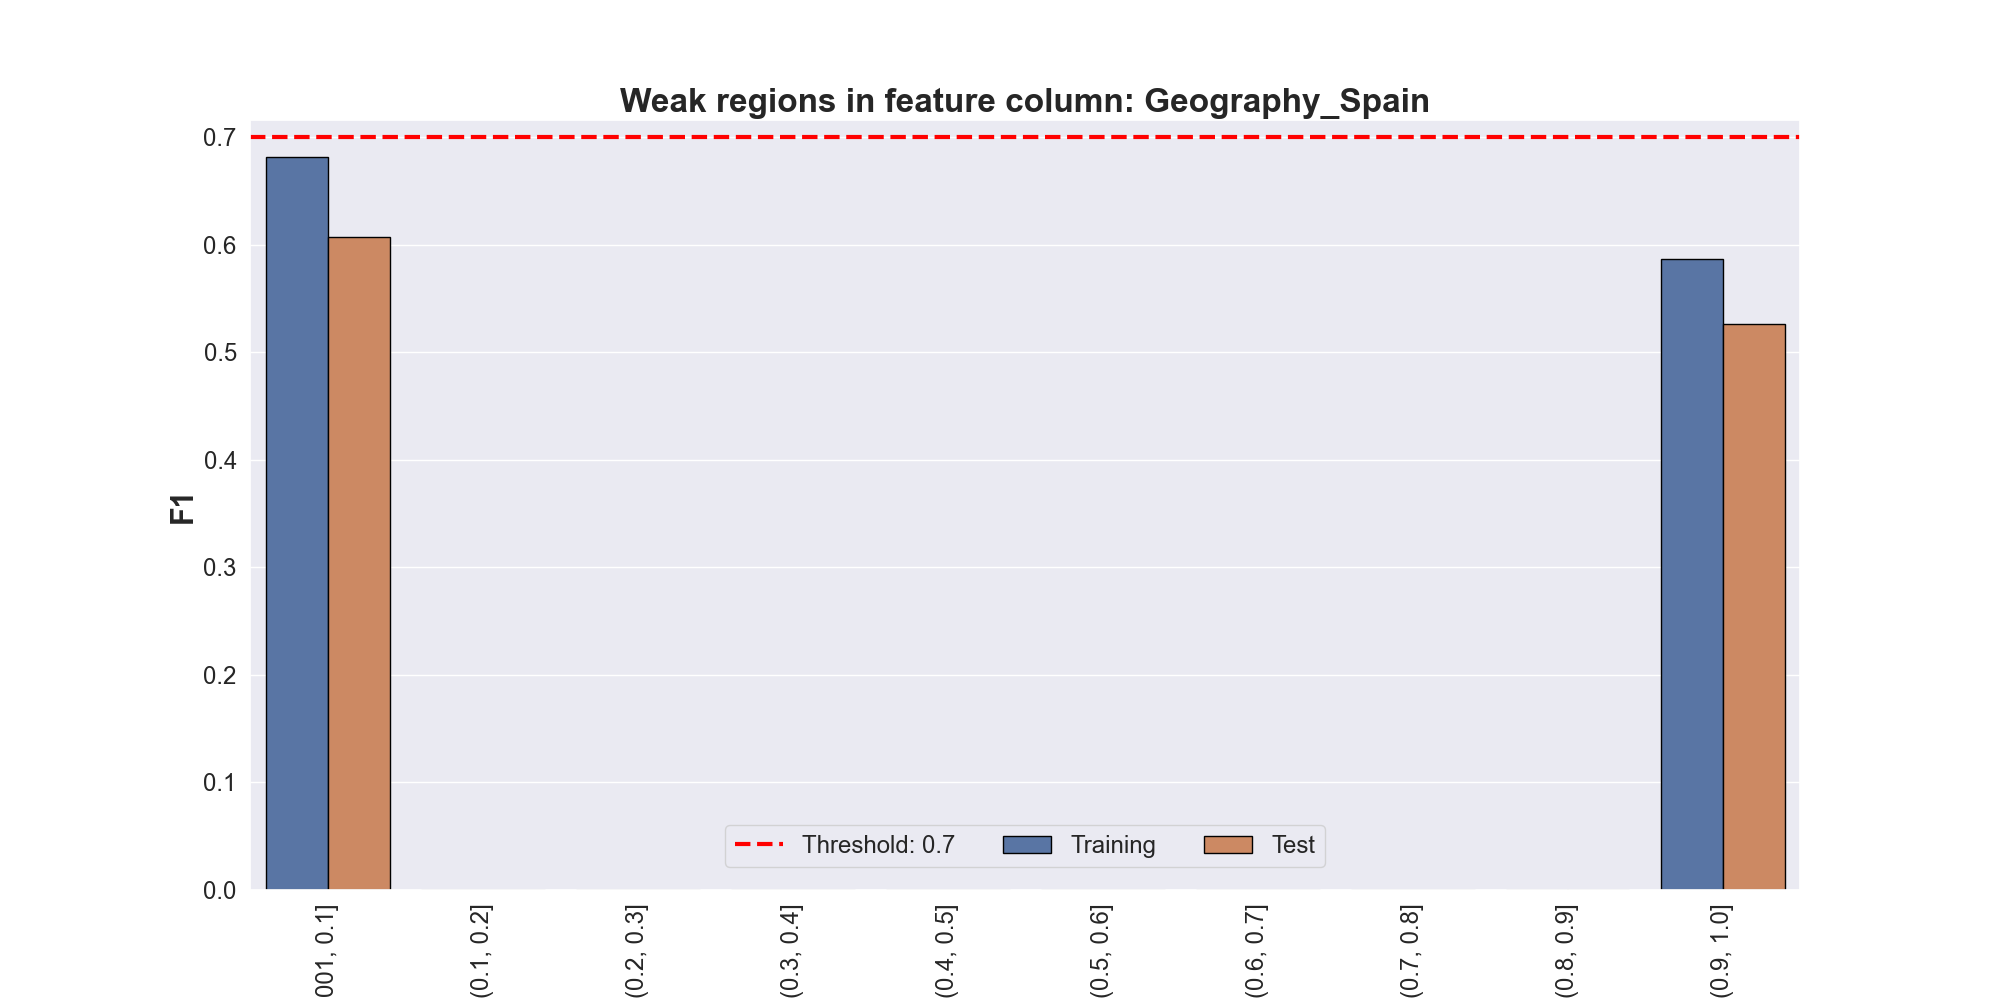

In [10]:
ws_diagnostic.test_results.show()

In [14]:
ws_diagnostic.test_results.test_results.results

[TestResult(test_name='accuracy', column='Gender', passed=False, values={'slice': ['(-0.001, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', '(0.5, 0.6]', '(0.6, 0.7]', '(0.7, 0.8]', '(0.8, 0.9]', '(0.9, 1.0]', '(-0.001, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', '(0.5, 0.6]', '(0.6, 0.7]', '(0.7, 0.8]', '(0.8, 0.9]', '(0.9, 1.0]'], 'shape': [2633, 0, 0, 0, 0, 0, 0, 0, 0, 2167, 882, 0, 0, 0, 0, 0, 0, 0, 0, 718], 'accuracy': [0.899354348651728, nan, nan, nan, nan, nan, nan, nan, nan, 0.8698661744347024, 0.8832199546485261, nan, nan, nan, nan, nan, nan, nan, nan, 0.8356545961002786], 'precision': [0.8175438596491228, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8478260869565217, 0.7282608695652174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7603305785123967], 'recall': [0.5224215246636771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5799256505576208, 0.46206896551724136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5082872928176796], 'f1': [0.6374829001367989, 0